<a href="https://colab.research.google.com/github/sofyakhlopkova/-1/blob/main/aromatniy_hackathon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importы**

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 6.1 MB/s eta 0:00:00


In [ ]:
!pip -q install rdkit umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.2/36.2 MB 14.9 MB/s eta 0:00:00


In [ ]:
!pip install deepchem

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 552.4/552.4 kB 6.6 MB/s eta 0:00:00


In [ ]:
!pip install pubchempy

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 5.8 MB/s eta 0:00:00


In [ ]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 19.2 MB/s eta 0:00:00


In [ ]:
!pip install SMOTE

In [ ]:
!pip install imbalanced-learn

In [ ]:
import torch
import numpy as np
import pickle

from sklearn.model_selection import cross_val_score, train_test_split
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder

import pubchempy as pcp
import pandas as pd
import time

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from torchvision.transforms import v2

import torchsummary

from multiprocessing.pool import ThreadPool
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

import optuna

import matplotlib.pyplot as plt
from matplotlib import colors, pyplot as plt

from sklearn.model_selection import train_test_split, GroupKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import mean_absolute_error, r2_score, accuracy_score
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import classification_report, f1_score

from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.DataStructs import ConvertToNumpyArray

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

**Проверка доступности GPU**

In [ ]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is not available.  Training on CPU ...


**Для воспроизводимости**

In [ ]:
!python --version
from importlib.metadata import version
for b in ['torch', 'torchvision', 'tqdm', 'matplotlib', 'seaborn', 'Pillow']:
    print(b + ' version: '+ version(b))

Python 3.12.12
torch version: 2.8.0+cu126
torchvision version: 0.23.0+cu126
tqdm version: 4.67.1
matplotlib version: 3.10.0
seaborn version: 0.13.2
Pillow version: 11.3.0


**Data load**

In [ ]:
!unzip -q /content/data_smell.zip

In [ ]:
df = pd.read_csv('train_dataset.csv')

**Data observation**

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2082 entries, 0 to 2081
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Pubchem_ID     2082 non-null   int64
 1   taste_cluster  2082 non-null   int64
dtypes: int64(2)
memory usage: 32.7 KB


In [ ]:
df.describe()

,Pubchem_ID,taste_cluster
count,2.082000e+03,2082.000000
mean,-5.042564e+09,2.535062
std,5.831236e+10,2.217394
min,-9.553489e+11,0.000000
25%,1.357300e+04,0.000000
50%,8.236650e+04,2.000000
75%,3.085511e+06,4.000000
max,1.519865e+08,7.000000


**Dublicates check**

In [ ]:
df['Pubchem_ID'].nunique()

2082

**Исправление опечаток**

In [ ]:
df['Pubchem_ID'] = [abs(x) for x in df['Pubchem_ID']]

In [ ]:
ids = df['Pubchem_ID']

valid_items = (ids < 1_000_000_000) # по данным на 2021 год max значение cid: 111,566,432

valid_df = df[valid_items].copy()
invalid_df = df[~valid_items].copy()

In [ ]:
invalid_df

,Pubchem_ID,taste_cluster
2,491960711349,3
326,521801045481,3
450,923209957509,3
484,715392619320,4
734,411945882527,4
839,769823381108,2
842,824509018158,3
938,210999474125,4
1275,441877084569,2
1394,539027388368,0


**Получение дескрипторов из PubChem**

In [ ]:
def get_smiles_batch(identifiers, id_type='cid', delay=0.2):
    """
    Parameters:
    - identifiers: список ID
    - id_type: 'cid'
    - delay: задержка между запросами (чтобы не заблокировали)
    """
    results = []

    for identifier in tqdm(identifiers, desc="get SMILES"):
        try:
            compound = pcp.Compound.from_cid(identifier)

            if compound:
                smiles_data = {
                    'original_id': identifier,
                    'canonical_smiles': compound.canonical_smiles,
                    'isomeric_smiles': compound.isomeric_smiles,
                    'iupac_name': compound.iupac_name,
                    'molecular_formula': compound.molecular_formula,
                    'molecular_weight': compound.molecular_weight,
                    'cid': compound.cid
                }
            else:
                smiles_data = {
                    'original_id': identifier,
                    'canonical_smiles': None,
                    'isomeric_smiles': None,
                    'iupac_name': None,
                    'molecular_formula': None,
                    'molecular_weight': None,
                    'cid': None
                }

        except Exception as e:
            print(f"error for {identifier}: {e}")
            smiles_data = {
                'original_id': identifier,
                'canonical_smiles': None,
                'isomeric_smiles': None,
                'iupac_name': None,
                'molecular_formula': None,
                'molecular_weight': None,
                'cid': None
            }

        results.append(smiles_data)
        time.sleep(delay)  # чтобы не делать слишком много запросов быстро

    return pd.DataFrame(results)

In [ ]:
identifiers = valid_df['Pubchem_ID'].tolist()

smiles_df = get_smiles_batch(identifiers, id_type='cid')
print(smiles_df.head())

get SMILES:   0%|          | 0/2064 [00:00<?, ?it/s]/tmp/ipython-input-3962561877.py:17: PubChemPyDeprecationWarning: canonical_smiles is deprecated: Use connectivity_smiles instead
  'canonical_smiles': compound.canonical_smiles,
/tmp/ipython-input-3962561877.py:18: PubChemPyDeprecationWarning: isomeric_smiles is deprecated: Use smiles instead
  'isomeric_smiles': compound.isomeric_smiles,
get SMILES: 100%|██████████| 2064/2064 [15:55<00:00,  2.16it/s]

   original_id           canonical_smiles  \
0        95609              CCC(C(=O)CC)O   
1       104224          CCCCCCCCCCC(OC)OC   
2      5284499       CCCCCCCCC=CCCCCCCCCO   
3        10886           CCCCCC(=O)OCCCCC   
4     12978217  CC=CC(=O)C1C(C=CCC1(C)C)C   

                        isomeric_smiles  \
0                         CCC(C(=O)CC)O   
1                     CCCCCCCCCCC(OC)OC   
2                CCCCCCCC/C=C\CCCCCCCCO   
3                      CCCCCC(=O)OCCCCC   
4  C/C=C/C(=O)[C@@H]1[C@H](C=CCC1(C)C)C   

                                          iupac_name molecular_formula  \
0                               4-hydroxyhexan-3-one           C6H12O2   
1                              1,1-dimethoxyundecane          C13H28O2   
2                              (Z)-octadec-9-en-1-ol           C18H36O   
3                                   pentyl hexanoate          C11H22O2   
4  (E)-1-[(1R,2S)-2,6,6-trimethylcyclohex-3-en-1-...           C13H20O   

   molecular_weight      

**Получение дескрипторов (RDkit)**

In [ ]:
from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors, Lipinski

In [ ]:
def get_descriptors(smiles_list):

    all_descriptors = []
    valid_smiles = []

    for smiles in smiles_list:

      mol = Chem.MolFromSmiles(smiles)

      if mol is not None:

          descriptors = {}

          descriptors['MolLogP'] = Descriptors.MolLogP(mol)

          descriptors['TPSA'] = Descriptors.TPSA(mol)

          descriptors['MolWt'] = Descriptors.MolWt(mol)
          descriptors['HeavyAtomCount'] = Descriptors.HeavyAtomCount(mol)

          descriptors['NumAromaticRings'] = Descriptors.NumAromaticRings(mol)
          descriptors['NumAromaticHeterocycles'] = Descriptors.NumAromaticHeterocycles(mol)
          descriptors['NumHeteroatoms'] = Descriptors.NumHeteroatoms(mol)

          descriptors['SlogP_VSA1'] = Descriptors.SlogP_VSA1(mol)
          descriptors['EState_VSA1'] = Descriptors.EState_VSA1(mol)

          descriptors['NumRotatableBonds'] = Descriptors.NumRotatableBonds(mol)

          descriptors['RingCount'] = Descriptors.RingCount(mol)

          descriptors['Lipinski_HDonors'] = Lipinski.NumHDonors(mol)
          descriptors['Lipinski_HAcceptors'] = Lipinski.NumHAcceptors(mol)

          # Добавим еще несколько важных дескрипторов
          descriptors['FractionCSP3'] = Descriptors.FractionCSP3(mol)
          descriptors['NumAliphaticRings'] = Descriptors.NumAliphaticRings(mol)
          descriptors['NumSaturatedRings'] = Descriptors.NumSaturatedRings(mol)
          descriptors['BalabanJ'] = Descriptors.BalabanJ(mol)

          all_descriptors.append(descriptors)
          valid_smiles.append(smiles)

    if all_descriptors:
        descriptors_df = pd.DataFrame(all_descriptors)
        descriptors_df['smiles'] = valid_smiles
        return descriptors_df
    else:
        return pd.DataFrame()

In [ ]:
smiles_list = smiles_df['canonical_smiles']
mol_descriptors = get_descriptors(smiles_list)

In [ ]:
mol_descriptors

,MolLogP,TPSA,MolWt,HeavyAtomCount,NumAromaticRings,NumAromaticHeterocycles,NumHeteroatoms,SlogP_VSA1,EState_VSA1,NumRotatableBonds,RingCount,Lipinski_HDonors,Lipinski_HAcceptors,FractionCSP3,NumAliphaticRings,NumSaturatedRings,BalabanJ,smiles
0,0.7364,37.30,116.160,8,0,0,2,0.0,6.103966,3,0,1,2,0.833333,0,0,3.459729,CCC(C(=O)CC)O
1,4.1361,18.46,216.365,15,0,0,2,0.0,0.000000,11,0,0,2,1.000000,0,0,3.036227,CCCCCCCCCCC(OC)OC
2,6.0162,20.23,268.485,19,0,0,1,0.0,0.000000,15,0,1,1,0.888889,0,0,3.007722,CCCCCCCCC=CCCCCCCCCO
3,3.3001,26.30,186.295,13,0,0,2,0.0,0.000000,8,0,0,2,0.909091,0,0,3.105083,CCCCCC(=O)OCCCCC
4,3.3700,17.07,192.302,14,0,0,1,0.0,0.000000,2,1,0,1,0.615385,1,0,2.927966,CC=CC(=O)C1C(C=CCC1(C)C)C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2059,4.0803,26.30,214.349,15,0,0,2,0.0,0.000000,10,0,0,2,0.923077,0,0,2.954540,CCCCCCCCCCOC(=O)CC
2060,2.3742,26.30,182.263,13,0,0,2,0.0,0.000000,2,2,0,2,0.909091,2,2,2.269285,CC1(C2CCC1(C(C2)OC=O)C)C
2061,2.6860,26.30,170.252,12,0,0,2,0.0,0.000000,7,0,0,2,0.700000,0,0,3.134308,CCCCCCC(=O)OCC=C
2062,2.5419,26.30,194.274,14,0,0,2,0.0,0.000000,2,3,0,2,0.750000,3,1,2.002136,CC(=O)OCC1=CCC2CC1C2(C)C


**Добавление target col к df дескрипторов**

In [ ]:
final_df = mol_descriptors.copy()
final_df['taste_cluster'] = valid_df['taste_cluster'].values[:len(mol_descriptors)]

In [ ]:
final_df

,MolLogP,TPSA,MolWt,HeavyAtomCount,NumAromaticRings,NumAromaticHeterocycles,NumHeteroatoms,SlogP_VSA1,EState_VSA1,NumRotatableBonds,...,Morgan_1014,Morgan_1015,Morgan_1016,Morgan_1017,Morgan_1018,Morgan_1019,Morgan_1020,Morgan_1021,Morgan_1022,Morgan_1023
0,0.7364,37.30,116.160,8,0,0,2,0.0,6.103966,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4.1361,18.46,216.365,15,0,0,2,0.0,0.000000,11,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,6.0162,20.23,268.485,19,0,0,1,0.0,0.000000,15,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3.3001,26.30,186.295,13,0,0,2,0.0,0.000000,8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.3700,17.07,192.302,14,0,0,1,0.0,0.000000,2,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2059,4.0803,26.30,214.349,15,0,0,2,0.0,0.000000,10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2060,2.3742,26.30,182.263,13,0,0,2,0.0,0.000000,2,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2061,2.6860,26.30,170.252,12,0,0,2,0.0,0.000000,7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2062,2.5419,26.30,194.274,14,0,0,2,0.0,0.000000,2,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


**Баланс классов**

In [ ]:
print(final_df['taste_cluster'].value_counts(normalize=True) * 100)

taste_cluster
0    25.678295
3    19.476744
1    14.341085
4    13.856589
2    10.658915
7     9.786822
6     4.118217
5     2.083333
Name: proportion, dtype: float64


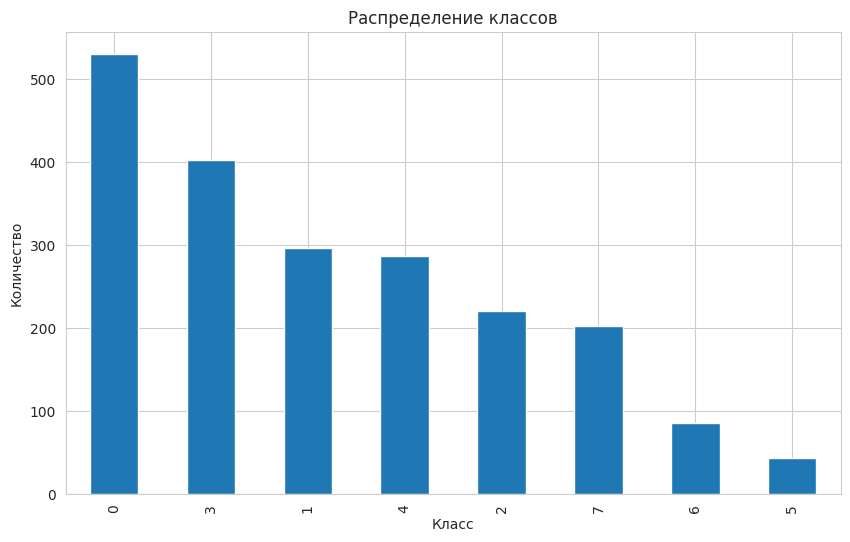

In [ ]:
plt.figure(figsize=(10, 6))
final_df['taste_cluster'].value_counts().plot(kind='bar')
plt.title('Распределение классов')
plt.xlabel('Класс')
plt.ylabel('Количество')
plt.show()

**Вывод:** дисбаланс => необходимо будет использовать методы балансировки

**Train классических моделей (RF, LightGBM, XGBoost, CatBoost)**

In [ ]:
def train_all_models(X, y, test_size=0.2, random_state=42):

    # Предобработка данных
    X = np.array(X)

    # Разделяем данные
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )

    # Масштабируем признаки (кроме tree-based моделей это не обязательно)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    # Инициализация моделей
    models = {
        'RandomForest': RandomForestClassifier(
            n_estimators=100,
            class_weight='balanced', # балансировка
            random_state=random_state,
            n_jobs=-1
        ),
        'LightGBM': LGBMClassifier(
            n_estimators=100,
            random_state=random_state,
            n_jobs=-1,
            verbose=-1  # убираем лишние логи
        ),
        'XGBoost': XGBClassifier(
            n_estimators=100,
            class_weight='balanced', # балансировка
            random_state=random_state,
            n_jobs=-1,
            eval_metric='mlogloss'
        ),
        'CatBoost': CatBoostClassifier(
            iterations=100,
            random_state=random_state,
            verbose=False,  # убираем логи
            thread_count=-1
        )
    }

    # Обучение и оценка
    results = {}

    for name, model in models.items():
        print(f" Обучение {name}...")

        # Для tree-based моделей используем немасштабированные данные
        if name in ['RandomForest', 'LightGBM', 'XGBoost', 'CatBoost']:
            X_tr, X_vl = X_train, X_val
        else:
            X_tr, X_vl = X_train_scaled, X_val_scaled

        # Обучение
        model.fit(X_tr, y_train)

        # Предсказания
        y_pred = model.predict(X_vl)
        y_pred_proba = model.predict_proba(X_vl)

        # Оценка качества
        from sklearn.metrics import accuracy_score, f1_score, classification_report

        accuracy = accuracy_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred, average='macro')

        results[name] = {
            'model': model,
            'accuracy': accuracy,
            'f1_score': f1,
            'predictions': y_pred,
            'probabilities': y_pred_proba
        }

        print(f" {name}: Accuracy = {accuracy:.4f}, F1 = {f1:.4f}")

    return results, models

In [ ]:
X = final_df.drop('taste_cluster', axis=1)

X_no_smiles = X.copy()
X_no_smiles = X_no_smiles.drop('smiles', axis=1)

y = final_df['taste_cluster']

results, models = train_all_models(X_no_smiles, y)

 Обучение RandomForest...
 RandomForest: Accuracy = 0.3874, F1 = 0.3481
 Обучение LightGBM...


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:28:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "class_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


 LightGBM: Accuracy = 0.3898, F1 = 0.3534
 Обучение XGBoost...
 XGBoost: Accuracy = 0.3753, F1 = 0.3442
 Обучение CatBoost...
 CatBoost: Accuracy = 0.4140, F1 = 0.3859


RandomForest: Accuracy = 0.3874, F1 = 0.3481

LightGBM: Accuracy = 0.3898, F1 = 0.3534

XGBoost: Accuracy = 0.3753, F1 = 0.3442

**CatBoost: Accuracy = 0.4140, F1 = 0.3859**

**Балансированные ансамбли**

In [ ]:
from imblearn.ensemble import BalancedRandomForestClassifier, EasyEnsembleClassifier
from imblearn.ensemble import BalancedBaggingClassifier

# Специальные балансированные ансамбли
brf = BalancedRandomForestClassifier(
    n_estimators=100,
    random_state=42,
    replacement=True
)

bbc = BalancedBaggingClassifier(
    n_estimators=100,
    random_state=42,
    replacement=True
)

In [ ]:
# Разделяем данные
X_train, X_test, y_train, y_test = train_test_split(
    X_no_smiles, y, test_size=0.2, random_state=42, stratify=y
)

# Обучаем модели
brf.fit(X_train, y_train)
bbc.fit(X_train, y_train)

# Предсказания
y_pred_brf = brf.predict(X_test)
y_pred_bbc = bbc.predict(X_test)

print("=== BalancedRandomForest ===")
print(classification_report(y_test, y_pred_brf))
print(f"F1-weighted: {f1_score(y_test, y_pred_brf, average='weighted'):.3f}")
print(f"F1-macro: {f1_score(y_test, y_pred_brf, average='macro'):.3f}")

print("\n=== BalancedBaggingClassifier ===")
print(classification_report(y_test, y_pred_bbc))
print(f"F1-weighted: {f1_score(y_test, y_pred_bbc, average='weighted'):.3f}")
print(f"F1-macro: {f1_score(y_test, y_pred_bbc, average='macro'):.3f}")

=== BalancedRandomForest ===
              precision    recall  f1-score   support

           0       0.62      0.42      0.50       106
           1       0.37      0.32      0.35        59
           2       0.36      0.48      0.41        44
           3       0.39      0.17      0.24        81
           4       0.45      0.51      0.48        57
           5       0.24      0.67      0.35         9
           6       0.22      0.59      0.32        17
           7       0.26      0.40      0.32        40

    accuracy                           0.39       413
   macro avg       0.36      0.45      0.37       413
weighted avg       0.43      0.39      0.39       413

F1-weighted: 0.387
F1-macro: 0.371

=== BalancedBaggingClassifier ===
              precision    recall  f1-score   support

           0       0.57      0.43      0.49       106
           1       0.32      0.27      0.29        59
           2       0.39      0.50      0.44        44
           3       0.36      0.19

**Вывод:** нет значительного улучшения, продолжаем эксперименты с RF, LightGBM, XGBoost, CatBoost

**Оптимизация гиперпараметров классических моделей (Optuna)**

In [ ]:
def optimize_models(X, y, n_trials=50):

    def objective(trial):
        model_name = trial.suggest_categorical('model', ['LightGBM', 'XGBoost', 'RandomForest'])

        if model_name == 'LightGBM':
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
                'num_leaves': trial.suggest_int('num_leaves', 20, 150),
                'max_depth': trial.suggest_int('max_depth', 3, 12),
                'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
                'subsample': trial.suggest_float('subsample', 0.6, 1.0),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            }
            model = LGBMClassifier(**params, random_state=42, verbose=-1)

        elif model_name == 'XGBoost':
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
                'max_depth': trial.suggest_int('max_depth', 3, 12),
                'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
                'subsample': trial.suggest_float('subsample', 0.6, 1.0),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
                'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
                'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
            }
            model = XGBClassifier(**params, class_weight='balanced', random_state=42)

        else:  # RandomForest
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
                'max_depth': trial.suggest_int('max_depth', 5, 20),
                'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
                'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
                'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
            }
            model = RandomForestClassifier(**params, class_weight='balanced', random_state=42, n_jobs=-1)

        scores = cross_val_score(model, X, y, cv=3, scoring='f1_weighted', n_jobs=-1)
        return scores.mean()

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials)

    print(f"Лучшие параметры: F1 = {study.best_value:.4f}")
    return study.best_params

In [ ]:
best_params = optimize_models(X_no_smiles, y, n_trials=30)

[I 2025-11-17 08:34:36,148] A new study created in memory with name: no-name-48f90ff3-aa97-4074-bbad-c59eb74cb90d
[I 2025-11-17 08:34:50,614] Trial 0 finished with value: 0.41736721021800843 and parameters: {'model': 'XGBoost', 'n_estimators': 669, 'learning_rate': 0.022227161959230374, 'max_depth': 8, 'min_child_weight': 4, 'subsample': 0.878552395502781, 'colsample_bytree': 0.7693011138775033, 'reg_alpha': 8.328897893647789e-07, 'reg_lambda': 0.0005192121401713364}. Best is trial 0 with value: 0.41736721021800843.
[I 2025-11-17 08:35:01,511] Trial 1 finished with value: 0.40808252682358814 and parameters: {'model': 'LightGBM', 'n_estimators': 507, 'learning_rate': 0.02128425871999777, 'num_leaves': 110, 'max_depth': 8, 'min_child_samples': 53, 'subsample': 0.6351317157946501, 'colsample_bytree': 0.6634132437999185}. Best is trial 0 with value: 0.41736721021800843.
[I 2025-11-17 08:35:04,524] Trial 2 finished with value: 0.3784617462768134 and parameters: {'model': 'RandomForest', 'n_

Лучшие параметры: F1 = 0.4288


Лучшие параметры: F1 = 0.4288

**Получение дескрипторов функциональных групп (FG)**

In [ ]:
def get_fg_descriptors(smiles_list):

    all_descriptors = []
    valid_smiles = []

    for smiles in smiles_list:

      mol = Chem.MolFromSmiles(smiles)

      if mol is not None:

          descriptors = {}

          functional_groups = {
                'CarboxylicAcid': len(mol.GetSubstructMatches(Chem.MolFromSmarts('C(=O)O'))),
                'Ester': len(mol.GetSubstructMatches(Chem.MolFromSmarts('C(=O)O[C]'))),
                'Amide': len(mol.GetSubstructMatches(Chem.MolFromSmarts('C(=O)N'))),
                'Amine': len(mol.GetSubstructMatches(Chem.MolFromSmarts('[N;!$(N=*)]'))),
                'Alcohol': len(mol.GetSubstructMatches(Chem.MolFromSmarts('[OH]'))),
                'Ketone': len(mol.GetSubstructMatches(Chem.MolFromSmarts('C(=O)C'))),
                'Aldehyde': len(mol.GetSubstructMatches(Chem.MolFromSmarts('C(=O)[H]'))),
                'Nitro': len(mol.GetSubstructMatches(Chem.MolFromSmarts('[N+](=O)[O-]'))),
                'Halogen': len(mol.GetSubstructMatches(Chem.MolFromSmarts('[F,Cl,Br,I]'))),
                'Sulfur': len(mol.GetSubstructMatches(Chem.MolFromSmarts('[S]'))),
            }

          descriptors.update(functional_groups)
          all_descriptors.append(descriptors)

          valid_smiles.append(smiles)

    if all_descriptors:
        descriptors_df = pd.DataFrame(all_descriptors)
        descriptors_df['smiles'] = valid_smiles
        return descriptors_df
    else:
        return pd.DataFrame()

In [ ]:
functional_df = get_fg_descriptors(smiles_list)

**Train на FG дескрипторах**

In [ ]:
fg_df = functional_df.copy()
fg_df['taste_cluster'] = valid_df['taste_cluster'].values[:len(functional_df)]

In [ ]:
X_fg = fg_df.drop('taste_cluster', axis=1)

X_no_smiles_fg = X_fg.copy()
X_no_smiles_fg = X_no_smiles_fg.drop('smiles', axis=1)

y_fg = fg_df['taste_cluster']

results, models = train_all_models(X_no_smiles_fg, y_fg)

 Обучение RandomForest...
 RandomForest: Accuracy = 0.2688, F1 = 0.2287
 Обучение LightGBM...
 LightGBM: Accuracy = 0.3487, F1 = 0.1655
 Обучение XGBoost...
 XGBoost: Accuracy = 0.3584, F1 = 0.1742
 Обучение CatBoost...
 CatBoost: Accuracy = 0.3511, F1 = 0.1679


In [ ]:
best_params = optimize_models(X_no_smiles_fg, y_fg, n_trials=30)

[I 2025-11-17 09:15:57,920] A new study created in memory with name: no-name-c1701fbd-6d59-4694-b02a-d54de91db086
[I 2025-11-17 09:16:03,156] Trial 0 finished with value: 0.2342885971798687 and parameters: {'model': 'XGBoost', 'n_estimators': 360, 'learning_rate': 0.011189847050847182, 'max_depth': 4, 'min_child_weight': 1, 'subsample': 0.7822263100199252, 'colsample_bytree': 0.9271065366668036, 'reg_alpha': 2.156465475872627e-06, 'reg_lambda': 0.0013546391371396119}. Best is trial 0 with value: 0.2342885971798687.
[I 2025-11-17 09:16:11,084] Trial 1 finished with value: 0.22822443939380996 and parameters: {'model': 'LightGBM', 'n_estimators': 590, 'learning_rate': 0.022424419863086555, 'num_leaves': 117, 'max_depth': 3, 'min_child_samples': 49, 'subsample': 0.6007031911546238, 'colsample_bytree': 0.832060208519366}. Best is trial 0 with value: 0.2342885971798687.
[I 2025-11-17 09:16:17,179] Trial 2 finished with value: 0.2261994693174827 and parameters: {'model': 'RandomForest', 'n_es

Лучшие параметры: F1 = 0.2392


Лучшие параметры: F1 = 0.2392

**Получение Morgan дескрипторов**

In [ ]:
from rdkit.Chem import AllChem, MACCSkeys

In [ ]:
def get_morgan_descriptors(smiles_list, radius=2, n_bits=1024):

    morgan_fps = []
    failed_smiles = []

    for i, smiles in enumerate(smiles_list):
        if i % 500 == 0:
            print(f"Обработано {i}/{len(smiles_list)} молекул...")

        mol = Chem.MolFromSmiles(smiles)

        try:
            fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
            fp_array = np.zeros(n_bits)
            for idx in fp.GetOnBits():
                fp_array[idx] = 1
            morgan_fps.append(fp_array)
        except Exception as e:
            print(f"  Ошибка для SMILES {smiles}: {e}")
            fp_array = np.zeros(n_bits)
            morgan_fps.append(fp_array)
            failed_smiles.append(smiles)

    if failed_smiles:
        print(f"Не удалось обработать {len(failed_smiles)} SMILES")
        print("Примеры проблемных SMILES:", failed_smiles[:5])

    morgan_columns = [f'Morgan_{i}' for i in range(n_bits)]
    morgan_df = pd.DataFrame(morgan_fps, columns=morgan_columns)

    return morgan_df

In [ ]:
morgan_df = get_morgan_descriptors(smiles_list, radius=2, n_bits=1024)

Обработано 0/2064 молекул...
Обработано 500/2064 молекул...
Обработано 1000/2064 молекул...
Обработано 1500/2064 молекул...
Обработано 2000/2064 молекул...


[06:13:39] DEPRECATION WARNING: please use MorganGenerator
[06:13:39] DEPRECATION WARNING: please use MorganGenerator
[06:13:39] DEPRECATION WARNING: please use MorganGenerator
[06:13:39] DEPRECATION WARNING: please use MorganGenerator
[06:13:39] DEPRECATION WARNING: please use MorganGenerator
[06:13:39] DEPRECATION WARNING: please use MorganGenerator
[06:13:39] DEPRECATION WARNING: please use MorganGenerator
[06:13:39] DEPRECATION WARNING: please use MorganGenerator
[06:13:39] DEPRECATION WARNING: please use MorganGenerator
[06:13:39] DEPRECATION WARNING: please use MorganGenerator
[06:13:39] DEPRECATION WARNING: please use MorganGenerator
[06:13:39] DEPRECATION WARNING: please use MorganGenerator
[06:13:39] DEPRECATION WARNING: please use MorganGenerator
[06:13:39] DEPRECATION WARNING: please use MorganGenerator
[06:13:39] DEPRECATION WARNING: please use MorganGenerator
[06:13:39] DEPRECATION WARNING: please use MorganGenerator
[06:13:39] DEPRECATION WARNING: please use MorganGenerat

**Train на Morgan дескрипторах**

In [ ]:
morgan_df = morgan_df.copy()
morgan_df['taste_cluster'] = valid_df['taste_cluster'].values[:len(morgan_df)]

In [ ]:
X_morgan = morgan_df.drop('taste_cluster', axis=1)

y_morgan = morgan_df['taste_cluster']

results, models = train_all_models(X_morgan, y_morgan)

 Обучение RandomForest...
 RandomForest: Accuracy = 0.3995, F1 = 0.3290
 Обучение LightGBM...
 LightGBM: Accuracy = 0.4044, F1 = 0.3630
 Обучение XGBoost...
 XGBoost: Accuracy = 0.4237, F1 = 0.3736
 Обучение CatBoost...
 CatBoost: Accuracy = 0.3971, F1 = 0.3573


RandomForest: Accuracy = 0.3995, F1 = 0.3290

LightGBM: Accuracy = 0.4044, F1 = 0.3630

**XGBoost: Accuracy = 0.4237, F1 = 0.3736**

CatBoost: Accuracy = 0.3971, F1 = 0.3573

In [ ]:
best_params = optimize_models(X_morgan, y_morgan, n_trials=30)

[I 2025-11-17 09:56:42,378] A new study created in memory with name: no-name-1c56531e-4d88-46aa-9edd-9dce02542729
[I 2025-11-17 09:57:54,708] Trial 0 finished with value: 0.40259484982484794 and parameters: {'model': 'XGBoost', 'n_estimators': 502, 'learning_rate': 0.02392176967516708, 'max_depth': 8, 'min_child_weight': 5, 'subsample': 0.6608592222087979, 'colsample_bytree': 0.6238271333235971, 'reg_alpha': 0.003886687998960466, 'reg_lambda': 2.8664366684973752e-08}. Best is trial 0 with value: 0.40259484982484794.
[I 2025-11-17 09:59:04,815] Trial 1 finished with value: 0.39808086343475013 and parameters: {'model': 'XGBoost', 'n_estimators': 568, 'learning_rate': 0.12509213597700947, 'max_depth': 10, 'min_child_weight': 3, 'subsample': 0.8358115799371996, 'colsample_bytree': 0.8754665031589143, 'reg_alpha': 0.006719032369480597, 'reg_lambda': 1.1368508631104283e-06}. Best is trial 0 with value: 0.40259484982484794.
[I 2025-11-17 10:00:05,086] Trial 2 finished with value: 0.3774792773

Лучшие параметры: F1 = 0.4193


Лучшие параметры: F1 = 0.4193

**Получение MACCS дескрипторов**

In [ ]:
from rdkit.Chem import AllChem, MACCSkeys

In [ ]:
def get_maccs_keys(smiles_list):

    maccs_fps = []

    for i, smiles in enumerate(smiles_list):
        if i % 500 == 0:
            print(f"Обработано {i}/{len(smiles_list)} молекул...")

        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            fp = np.zeros(166)
            maccs_fps.append(fp)
            continue

        try:
            fp = MACCSkeys.GenMACCSKeys(mol)
            fp_array = np.zeros(166)
            for idx in range(166):
                if fp[idx]:
                    fp_array[idx] = 1
            maccs_fps.append(fp_array)
        except:
            fp_array = np.zeros(166)
            maccs_fps.append(fp_array)

    maccs_columns = [f'MACCS_{i}' for i in range(166)]
    return pd.DataFrame(maccs_fps, columns=maccs_columns)

In [ ]:
maccs_df = get_maccs_keys(smiles_list)

Обработано 0/2064 молекул...
Обработано 500/2064 молекул...
Обработано 1000/2064 молекул...
Обработано 1500/2064 молекул...
Обработано 2000/2064 молекул...


**Train на MACCS дескрипторах**

In [ ]:
maccs_df = maccs_df.copy()
maccs_df['taste_cluster'] = valid_df['taste_cluster'].values[:len(maccs_df)]

In [ ]:
X_maccs = maccs_df.drop('taste_cluster', axis=1)

y_maccs = maccs_df['taste_cluster']

results, models = train_all_models(X_maccs, y_maccs)

 Обучение RandomForest...
 RandomForest: Accuracy = 0.3874, F1 = 0.3515
 Обучение LightGBM...


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [06:13:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "class_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


 LightGBM: Accuracy = 0.3753, F1 = 0.3262
 Обучение XGBoost...
 XGBoost: Accuracy = 0.3874, F1 = 0.3445
 Обучение CatBoost...
 CatBoost: Accuracy = 0.4237, F1 = 0.3718


RandomForest: Accuracy = 0.3874, F1 = 0.3515

LightGBM: Accuracy = 0.3753, F1 = 0.3262

XGBoost: Accuracy = 0.3874, F1 = 0.3445

**CatBoost: Accuracy = 0.4237, F1 = 0.3718**

In [ ]:
best_params = optimize_models(X_maccs, y_maccs, n_trials=30)

[I 2025-11-17 10:10:19,788] A new study created in memory with name: no-name-dbd3eca0-b5c3-4d5f-a8c5-ed8a74c81f5c
[I 2025-11-17 10:10:30,848] Trial 0 finished with value: 0.4040772045120217 and parameters: {'model': 'XGBoost', 'n_estimators': 455, 'learning_rate': 0.03999024956139073, 'max_depth': 6, 'min_child_weight': 1, 'subsample': 0.9882355714342573, 'colsample_bytree': 0.8529774814283145, 'reg_alpha': 1.3804244940632375e-08, 'reg_lambda': 1.1123613325984756e-07}. Best is trial 0 with value: 0.4040772045120217.
[I 2025-11-17 10:10:43,683] Trial 1 finished with value: 0.4062771157678768 and parameters: {'model': 'XGBoost', 'n_estimators': 554, 'learning_rate': 0.05210578460926277, 'max_depth': 5, 'min_child_weight': 10, 'subsample': 0.6776545131038512, 'colsample_bytree': 0.7162558620600356, 'reg_alpha': 0.0022501188116422557, 'reg_lambda': 0.004947171281127371}. Best is trial 1 with value: 0.4062771157678768.
[I 2025-11-17 10:11:09,394] Trial 2 finished with value: 0.3991595930328

Лучшие параметры: F1 = 0.4305


Лучшие параметры: F1 = 0.4305

**Получение Daylight (RDKit's RDKFingerprint) дескрипторов**

In [ ]:
def get_daylight_fingerprints(smiles_list, fpSize=1024, minPath=1, maxPath=7):

    daylight_fps = []
    failed_smiles = []

    for i, smiles in enumerate(smiles_list):
        if i % 500 == 0:
            print(f"Обработано {i}/{len(smiles_list)} молекул...")

        mol = Chem.MolFromSmiles(smiles)

        fp = Chem.RDKFingerprint(mol,
                                   minPath=minPath,
                                   maxPath=maxPath,
                                   fpSize=fpSize,
                                   nBitsPerHash=2)
        fp_array = np.zeros(fpSize)
        for idx in fp.GetOnBits():
            fp_array[idx] = 1
        daylight_fps.append(fp_array)

    daylight_columns = [f'Daylight_{i}' for i in range(fpSize)]
    daylight_df = pd.DataFrame(daylight_fps, columns=daylight_columns)

    return daylight_df

In [ ]:
daylight_df = get_daylight_fingerprints(smiles_list)

Обработано 0/2064 молекул...
Обработано 500/2064 молекул...
Обработано 1000/2064 молекул...
Обработано 1500/2064 молекул...
Обработано 2000/2064 молекул...


**Train на Daylight дескрипторах**

In [ ]:
daylight_df = daylight_df.copy()
daylight_df['taste_cluster'] = valid_df['taste_cluster'].values[:len(daylight_df)]

In [ ]:
X_daylight = daylight_df.drop('taste_cluster', axis=1)

y_daylight = daylight_df['taste_cluster']

results, models = train_all_models(X_daylight, y_daylight)

 Обучение RandomForest...
 RandomForest: Accuracy = 0.3777, F1 = 0.3318
 Обучение LightGBM...
 LightGBM: Accuracy = 0.3995, F1 = 0.3484
 Обучение XGBoost...
 XGBoost: Accuracy = 0.3826, F1 = 0.3342
 Обучение CatBoost...
 CatBoost: Accuracy = 0.4383, F1 = 0.3985


RandomForest: Accuracy = 0.3777, F1 = 0.3318

LightGBM: Accuracy = 0.3995, F1 = 0.3484

XGBoost: Accuracy = 0.3826, F1 = 0.3342

**CatBoost: Accuracy = 0.4383, F1 = 0.3985**

In [ ]:
best_params = optimize_models(X_daylight, y_daylight, n_trials=30)

[I 2025-11-17 10:29:03,643] A new study created in memory with name: no-name-ebb992fd-3fec-452e-8e93-3ab3b65e3da3
[I 2025-11-17 10:29:12,592] Trial 0 finished with value: 0.40197930501307194 and parameters: {'model': 'RandomForest', 'n_estimators': 503, 'max_depth': 6, 'min_samples_split': 17, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.40197930501307194.
[I 2025-11-17 10:29:18,659] Trial 1 finished with value: 0.39565047516200386 and parameters: {'model': 'RandomForest', 'n_estimators': 443, 'max_depth': 17, 'min_samples_split': 5, 'min_samples_leaf': 10, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.40197930501307194.
[I 2025-11-17 10:29:37,312] Trial 2 finished with value: 0.39840205462414274 and parameters: {'model': 'XGBoost', 'n_estimators': 118, 'learning_rate': 0.015040438913272633, 'max_depth': 6, 'min_child_weight': 5, 'subsample': 0.6647815814011417, 'colsample_bytree': 0.6908468183665656, 'reg_alpha': 0.028930032851129002, 'reg_lam

Лучшие параметры: F1 = 0.4292


Лучшие параметры: F1 = 0.4292

**Сравнение размеров наборов дескрипторов**

In [ ]:
print(f"\nРазмеры наборов дескрипторов:")
print(f"Molecular descriptors: {final_df.shape}")
print(f"Functional groups: {functional_df.shape}")
print(f"Morgan fingerprints: {morgan_df.shape}")
print(f"MACCS keys: {maccs_df.shape}")
print(f"Daylight fingerprints: {daylight_df.shape}")

# Объединяем все дескрипторы
all_descriptors = pd.concat([final_df, functional_df, morgan_df, maccs_df, daylight_df], axis=1)
print(f"Всего дескрипторов: {all_descriptors.shape}")


Размеры дескрипторов:
Molecular descriptors: (2064, 19)
Functional groups: (2064, 11)
Morgan fingerprints: (2064, 1025)
MACCS keys: (2064, 167)
Daylight fingerprints: (2064, 1025)
Всего дескрипторов: (2064, 2247)


**Подбор комбинаций дескрипторов**

In [ ]:
descriptor_sets = {
    'Daylight': daylight_df,
    'MACCS': maccs_df,
    'Morgan_Fingerprints': morgan_df,
    'Functional_Groups': fg_df,
    'Molecular_Descriptors': final_df
}

Molecular_Descriptors + MACCS

- небольшое кол-во дескрипторов => более быстрый подбор гиперпараметров

- есть как непрерывные свойства, так и паттерны структуры)

In [ ]:
mol_features = descriptor_sets['Molecular_Descriptors'].drop('smiles', axis=1).select_dtypes(include=[np.number])

maccs_features = descriptor_sets['MACCS'].drop('taste_cluster', axis=1).select_dtypes(include=[np.number])

final_df = pd.concat([mol_features, maccs_features], axis=1)

X = final_df.drop('taste_cluster', axis=1)
y_final = final_df['taste_cluster']

results, models = train_all_models(X, y_final)

 Обучение RandomForest...
 RandomForest: Accuracy = 0.4310, F1 = 0.3958
 Обучение LightGBM...


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [06:14:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "class_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


 LightGBM: Accuracy = 0.4068, F1 = 0.3802
 Обучение XGBoost...
 XGBoost: Accuracy = 0.4455, F1 = 0.4266
 Обучение CatBoost...
 CatBoost: Accuracy = 0.4528, F1 = 0.4331


RandomForest: Accuracy = 0.4310, F1 = 0.3958

LightGBM: Accuracy = 0.4068, F1 = 0.3802

XGBoost: Accuracy = 0.4455, F1 = 0.4266

**CatBoost: Accuracy = 0.4528, F1 = 0.4331**


In [ ]:
best_params = optimize_models(X, y_final, n_trials=30)

[I 2025-11-17 11:55:10,361] A new study created in memory with name: no-name-1e330212-f898-4f4f-83c3-3b7ee60c7e6f
[I 2025-11-17 11:55:35,793] Trial 0 finished with value: 0.4204360885935084 and parameters: {'model': 'XGBoost', 'n_estimators': 551, 'learning_rate': 0.2203594031456238, 'max_depth': 9, 'min_child_weight': 8, 'subsample': 0.6847453045013061, 'colsample_bytree': 0.7062105797507638, 'reg_alpha': 0.0004910667500639977, 'reg_lambda': 0.551185566509686}. Best is trial 0 with value: 0.4204360885935084.
[I 2025-11-17 11:56:37,146] Trial 1 finished with value: 0.4472387608658224 and parameters: {'model': 'XGBoost', 'n_estimators': 934, 'learning_rate': 0.011981898916969718, 'max_depth': 12, 'min_child_weight': 2, 'subsample': 0.7014325724380194, 'colsample_bytree': 0.9059427319952971, 'reg_alpha': 0.00012828924714676555, 'reg_lambda': 1.4240934762530846e-05}. Best is trial 1 with value: 0.4472387608658224.
[I 2025-11-17 11:56:46,028] Trial 2 finished with value: 0.4279265615130982

Лучшие параметры: F1 = 0.4568


Лучшие параметры: **F1 = 0.4568**

Параметры: {'model': 'XGBoost', 'n_estimators': 469, 'learning_rate': 0.018178038693680947, 'max_depth': 11, 'min_child_weight': 8, 'subsample': 0.7246557270256099, 'colsample_bytree': 0.9125800981272568, 'reg_alpha': 0.05665157807560248, 'reg_lambda': 0.003361903890616946}.

Далее именно эта модель будет использоваться для ensemble с CNN !

**Анализ feature importances**

In [ ]:
best_params = {
    'n_estimators': 469,
    'learning_rate': 0.018178038693680947,
    'max_depth': 11,
    'min_child_weight': 8,
    'subsample': 0.7246557270256099,
    'colsample_bytree': 0.9125800981272568,
    'reg_alpha': 0.05665157807560248,
    'reg_lambda': 0.003361903890616946,
    'random_state': 42
}

In [ ]:
# Обучаем модель
final_model = XGBClassifier(**best_params)
final_model.fit(X, y_final)

# Топ-10 признаков
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': final_model.feature_importances_
}).sort_values('importance', ascending=False)

In [ ]:
import seaborn as sns

/tmp/ipython-input-373731922.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=top_10, y='feature', x='importance',


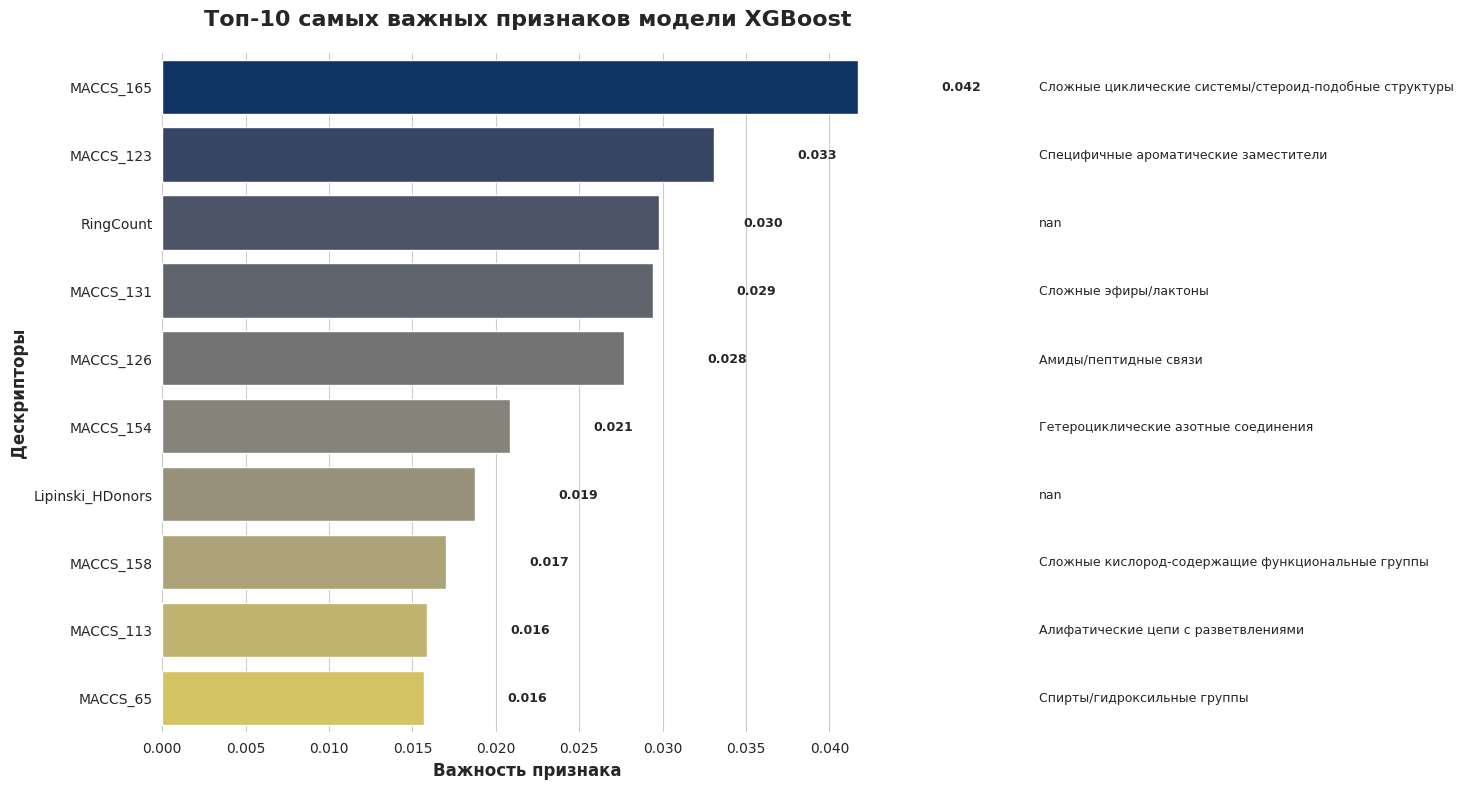

In [ ]:
# Словарь расшифровки
specific_maccs_decoder = {
    'MACCS_165': 'Сложные циклические системы/стероид-подобные структуры',
    'MACCS_123': 'Специфичные ароматические заместители',
    'MACCS_131': 'Сложные эфиры/лактоны',
    'MACCS_126': 'Амиды/пептидные связи',
    'MACCS_154': 'Гетероциклические азотные соединения',
    'MACCS_158': 'Сложные кислород-содержащие функциональные группы',
    'MACCS_113': 'Алифатические цепи с разветвлениями',
    'MACCS_65': 'Спирты/гидроксильные группы',
    'MACCS_105': 'Карбонильные группы в специфичном окружении',
    'MACCS_163': 'Полициклические ароматические системы'
}

# Настройка
plt.figure(figsize=(15, 8))
sns.set_style("whitegrid")

# Топ-10 признаков
top_10 = feature_importance.head(10).copy()

# Добавляем расшифровку
top_10['feature_decoded'] = top_10['feature'].map(specific_maccs_decoder)

# Создаем plot с оригинальными названиями
ax = sns.barplot(data=top_10, y='feature', x='importance',
                palette='cividis')

# Кастомизация
plt.title('Топ-10 самых важных признаков модели XGBoost',
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Важность признака', fontsize=12, fontweight='bold')
plt.ylabel('Дескрипторы', fontsize=12, fontweight='bold')

# Добавляем значения и расшифровку в аннотации
for i, (idx, row) in enumerate(top_10.iterrows()):
    # Значение важности
    ax.text(row['importance'] + 0.005, i, f'{row["importance"]:.3f}',
            va='center', fontsize=9, fontweight='bold')

    # Расшифровка как аннотация справа
    ax.text(1.2, i, row['feature_decoded'],
            va='center', fontsize=9, transform=ax.get_yaxis_transform(),
            bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7))

# Увеличиваем пространство для аннотаций
plt.subplots_adjust(right=0.7)

# Убираем рамку
sns.despine(left=True, bottom=True)

plt.tight_layout()
plt.show()

Molecular_Descriptors + MACCS

- больше features

In [ ]:
# Берем признаки из Molecular_Descriptors (без taste_cluster)
mol_features = descriptor_sets['Molecular_Descriptors'].drop('smiles', axis=1).select_dtypes(include=[np.number])

# Берем признаки из MACCS (без taste_cluster)
morgan_features = descriptor_sets['Morgan_Fingerprints'].drop('taste_cluster', axis=1).select_dtypes(include=[np.number])

# Конкатенируем только признаки
final_df = pd.concat([mol_features, morgan_features], axis=1)
y = final_df['taste_cluster']

# Проверяем данные
X = final_df.drop('taste_cluster', axis=1)
y_final = final_df['taste_cluster']

# Запускаем обучение
results, models = train_all_models(X, y_final)

 Обучение RandomForest...
 RandomForest: Accuracy = 0.4479, F1 = 0.3768
 Обучение LightGBM...


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [06:19:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "class_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


 LightGBM: Accuracy = 0.4600, F1 = 0.4471
 Обучение XGBoost...
 XGBoost: Accuracy = 0.4528, F1 = 0.4312
 Обучение CatBoost...
 CatBoost: Accuracy = 0.4504, F1 = 0.4095


RandomForest: Accuracy = 0.4479, F1 = 0.3768

**LightGBM: Accuracy = 0.4600, F1 = 0.4471**

XGBoost: Accuracy = 0.4528, F1 = 0.4312

CatBoost: Accuracy = 0.4504, F1 = 0.4095

In [ ]:
best_params = optimize_models(X, y_final, n_trials=30)

[I 2025-11-18 00:28:22,298] A new study created in memory with name: no-name-092c701b-0ccb-41c2-9c94-5e739ff8051f
[I 2025-11-18 00:28:41,597] Trial 0 finished with value: 0.43455042591398385 and parameters: {'model': 'LightGBM', 'n_estimators': 968, 'learning_rate': 0.09639575192734254, 'num_leaves': 90, 'max_depth': 11, 'min_child_samples': 7, 'subsample': 0.7508635759196125, 'colsample_bytree': 0.8754996063892795}. Best is trial 0 with value: 0.43455042591398385.
[I 2025-11-18 00:29:43,078] Trial 1 finished with value: 0.42519530807197886 and parameters: {'model': 'XGBoost', 'n_estimators': 852, 'learning_rate': 0.1106576559468295, 'max_depth': 10, 'min_child_weight': 5, 'subsample': 0.8366468619737185, 'colsample_bytree': 0.6939081638063299, 'reg_alpha': 3.140794319304485e-07, 'reg_lambda': 5.157158512824547e-06}. Best is trial 0 with value: 0.43455042591398385.
[I 2025-11-18 00:30:16,051] Trial 2 finished with value: 0.4195212592255726 and parameters: {'model': 'RandomForest', 'n_e

Лучшие параметры: F1 = 0.4484


F1 = 0.4484 < 0.4568 (Molecular_Descriptors + MACCS)

**Multi-layer CNN**

Каждый тип молекулярных дескрипторов содержит принципиально разную информацию, и multi-input CNN обрабатывает их оптимальным способом:

MACCS Keys (167 бинарных признаков) - Dense слои, так как это простые бинарные признаки наличия/отсутствия структурных фрагментов.

Morgan Fingerprints (1024 бинарных) - обрабатываются через Conv1D слои, потому что эти "отпечатки" можно рассматривать как последовательные паттерны молекулярной структуры.

RDKit Descriptors (19 непрерывных) - физико-химические свойства обрабатываются через Dense слои, так как это числовые характеристики в разных масштабах.

In [ ]:
!pip install tensorflow.keras

In [ ]:
morgan_features = descriptor_sets['Morgan_Fingerprints'].drop('taste_cluster', axis=1)
maccs_features = maccs_df.drop('taste_cluster', axis=1)

# Конкатенируем только признаки
cnn_df = pd.concat([mol_features, maccs_features, morgan_features], axis=1)
y = cnn_df['taste_cluster']

# Проверяем данные
X = cnn_df.drop('taste_cluster', axis=1)
y_cnn = cnn_df['taste_cluster']

**Стартовые параметры:**

- MACCS + Morgan
- Dense: 512 + 256 (ReLU, Dropout: 0.4, 0.3)
- Conv1D: 128 + 256 + 512 (Dropout: 0.2, 0.2)

Общий классификатор: 512 + 256 + 128 (Dropout: 0.5, 0.3, ReLU)

- Adam: lr=0.001

In [139]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv1D, GlobalMaxPooling1D, Dropout, Concatenate, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

def prepare_data(df):
    """Подготовка данных для multi-input модели"""

    # Разделяем на признаки и целевую переменную
    X_maccs = df.filter(regex='MACCS').values  # MACCS фичи
    X_morgan = df.filter(regex='Morgan').values  # Morgan fingerprints
    y = df['taste_cluster'].values  # Целевая переменная

    # Кодируем целевую переменную
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    y_categorical = to_categorical(y_encoded)

    # Нормализуем данные
    scaler_maccs = StandardScaler()
    scaler_morgan = StandardScaler()

    X_maccs_scaled = scaler_maccs.fit_transform(X_maccs)
    X_morgan_scaled = scaler_morgan.fit_transform(X_morgan)

    return X_maccs_scaled, X_morgan_scaled, y_categorical, le

def create_cnn(num_classes, maccs_dim=167, morgan_dim=2048):
    """Создание multi-input CNN модели"""

    # Вход для разных типов дескрипторов
    maccs_input = Input(shape=(maccs_dim,), name='maccs_input')
    morgan_input = Input(shape=(morgan_dim,), name='morgan_input')

    # Ветка для MACCS (плотные слои)
    maccs_branch = Dense(512, activation='relu')(maccs_input)
    maccs_branch = Dropout(0.4)(maccs_branch)
    maccs_branch = Dense(256, activation='relu')(maccs_branch)
    maccs_branch = Dropout(0.3)(maccs_branch)

    # Ветка для Morgan (CNN)
    morgan_branch = Reshape((morgan_dim, 1))(morgan_input)
    morgan_branch = Conv1D(128, kernel_size=7, activation='relu', padding='same')(morgan_branch)
    morgan_branch = Dropout(0.3)(morgan_branch)
    morgan_branch = Conv1D(256, kernel_size=5, activation='relu', padding='same')(morgan_branch)
    morgan_branch = Dropout(0.3)(morgan_branch)
    morgan_branch = Conv1D(512, kernel_size=3, activation='relu', padding='same')(morgan_branch)
    morgan_branch = GlobalMaxPooling1D()(morgan_branch)

    # Объединение ветвей
    concatenated = Concatenate()([maccs_branch, morgan_branch])

    # Общий классификатор
    x = Dense(512, activation='relu')(concatenated)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='relu')(x)

    # Выходной слой
    outputs = Dense(num_classes, activation='softmax')(x)

    # Создание модели
    model = Model(inputs=[maccs_input, morgan_input], outputs=outputs)

    # Компиляция
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

def train_model(X_maccs, X_morgan, y, test_size=0.2, random_state=42):
    """Обучение multi-input модели"""

    # Разделение данных - исправлено stratify
    X_maccs_train, X_maccs_test, X_morgan_train, X_morgan_test, y_train, y_test = train_test_split(
        X_maccs, X_morgan, y, test_size=test_size, random_state=random_state,
        stratify=y.argmax(axis=1)  # stratify работает с классами, а не one-hot
    )

    # Создание модели
    num_classes = y.shape[1]
    model = create_cnn(num_classes, X_maccs.shape[1], X_morgan.shape[1])

    # Callbacks
    callbacks = [
        EarlyStopping(patience=15, restore_best_weights=True, monitor='val_loss'),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-7)
    ]

    # Обучение
    history = model.fit(
        [X_maccs_train, X_morgan_train],
        y_train,
        validation_data=([X_maccs_test, X_morgan_test], y_test),
        epochs=100,
        batch_size=32,
        callbacks=callbacks,
        verbose=1
    )

    return model, history, (X_maccs_test, X_morgan_test, y_test)

# Визуализация обучения
def plot_training_history(history):
    """Визуализация процесса обучения"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # График потерь
    ax1.plot(history.history['loss'], label='Training Loss')
    ax1.plot(history.history['val_loss'], label='Validation Loss')
    ax1.set_title('Model Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # График точности
    ax2.plot(history.history['accuracy'], label='Training Accuracy')
    ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax2.set_title('Model Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    plt.tight_layout()
    plt.show()

# Функция для оценки модели
def evaluate_model(model, X_maccs_test, X_morgan_test, y_test, label_encoder):
    """Оценка модели и вывод метрик"""
    from sklearn.metrics import classification_report, f1_score, confusion_matrix

    # Предсказания
    y_pred = model.predict([X_maccs_test, X_morgan_test])
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)

    # F1-score
    f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')
    print(f" Weighted F1 Score: {f1:.4f}")

    return f1

 Подготовка данных...
 Создание и обучение модели...
Epoch 1/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - accuracy: 0.2080 - loss: 2.0493 - val_accuracy: 0.3196 - val_loss: 1.8391 - learning_rate: 0.0010
Epoch 2/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.3353 - loss: 1.8130 - val_accuracy: 0.3390 - val_loss: 1.7294 - learning_rate: 0.0010
Epoch 3/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 0.3854 - loss: 1.6467 - val_accuracy: 0.3462 - val_loss: 1.6919 - learning_rate: 0.0010
Epoch 4/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 130s 2s/step - accuracy: 0.3704 - loss: 1.6365 - val_accuracy: 0.3656 - val_loss: 1.6235 - learning_rate: 0.0010
Epoch 5/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 0.4083 - loss: 1.5359 - val_accuracy: 0.3729 - val_loss: 1.5945 - learning_rate: 0.0010
Epoch 6/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.4417 - loss: 1.4985 - val_accuracy: 0.3874 - val_loss: 1.5779 - learning_rate: 0.0010
Epoch 7/100
52/52 ━━━━━━━━━━━━━━━━━━━

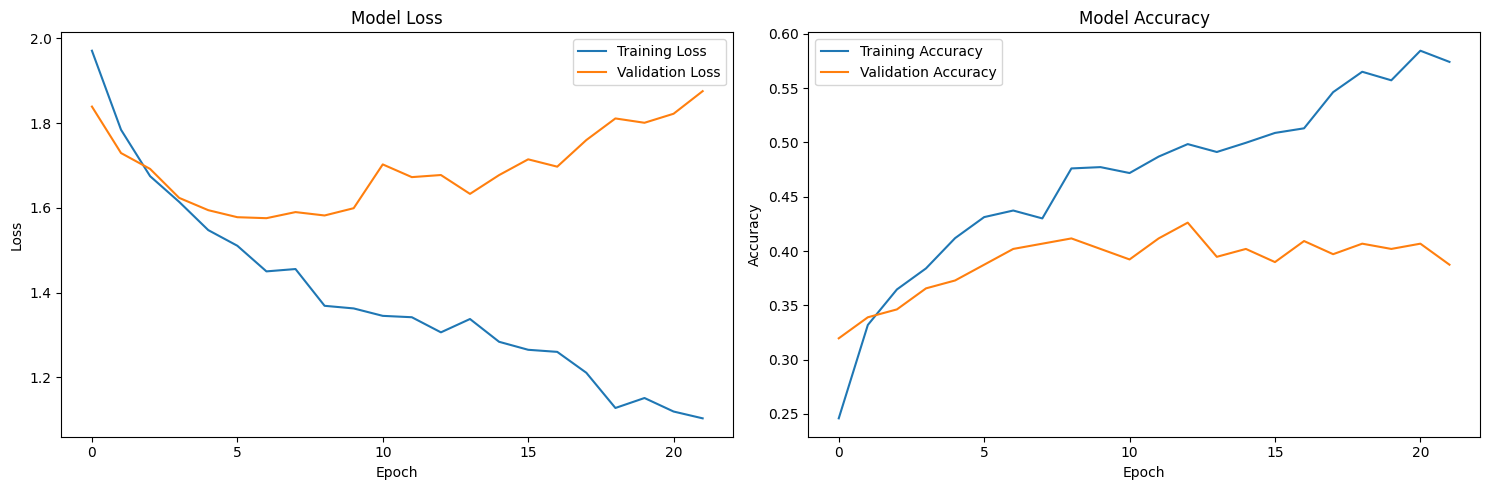

 Оценка модели...
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 594ms/step
 Weighted F1 Score: 0.3812

 Обучение завершено! Final F1: 0.3812


In [140]:
print(" Подготовка данных...")
X_maccs, X_morgan, y_categorical, label_encoder = prepare_data(cnn_df)

print(" Создание и обучение модели...")
model, history, test_data = train_model(X_maccs, X_morgan, y_categorical)

print(" Визуализация обучения...")
plot_training_history(history)

print(" Оценка модели...")
f1_score = evaluate_model(model, *test_data, label_encoder)

print(f"\n Обучение завершено! Final F1: {f1_score:.4f}")

F1 Score: 0.3812

есть переобучение

**Немного измененные параметры:**

- MACCS + Morgan
- compute_class_weight - для балансировки классов
- Dense: 512 + 256 (BatchNorm, LeakyReLU: alpha=0.01, Dropout: 0.2, 0.1)
- Conv1D: 128 + 256 + 512 (Dropout: 0.2, 0.2)

Общий классификатор: 512 + 256 + 128 (Dropout: 0.3, 0.2, LeakyReLU: 0.01)

- AdamW: lr=0.001, weight_decay=1e-5

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv1D, GlobalMaxPooling1D, Dropout, Concatenate, Reshape, LeakyReLU, BatchNormalization
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
import matplotlib.pyplot as plt

def get_class_weights(y_categorical):
    """Вычисление весов для несбалансированных классов"""
    y_classes = np.argmax(y_categorical, axis=1)
    class_weights = compute_class_weight(
        'balanced',
        classes=np.unique(y_classes),
        y=y_classes
    )
    return dict(enumerate(class_weights))

def prepare_data(df):
    """Подготовка данных для multi-input модели"""

    # Разделяем на признаки и целевую переменную
    X_maccs = df.filter(regex='MACCS').values  # MACCS фичи
    X_morgan = df.filter(regex='Morgan').values  # Morgan fingerprints
    y = df['taste_cluster'].values  # Целевая переменная

    # Кодируем целевую переменную
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    y_categorical = to_categorical(y_encoded)

    # Нормализуем данные
    scaler_maccs = StandardScaler()
    scaler_morgan = StandardScaler()

    X_maccs_scaled = scaler_maccs.fit_transform(X_maccs)
    X_morgan_scaled = scaler_morgan.fit_transform(X_morgan)

    return X_maccs_scaled, X_morgan_scaled, y_categorical, le

def create_cnn(num_classes, maccs_dim=167, morgan_dim=2048):
    """Создание multi-input CNN модели"""

    # Вход для разных типов дескрипторов
    maccs_input = Input(shape=(maccs_dim,), name='maccs_input')
    morgan_input = Input(shape=(morgan_dim,), name='morgan_input')

    # Ветка для MACCS (плотные слои)
    maccs_branch = Dense(512)(maccs_input)
    maccs_branch = BatchNormalization()(maccs_branch)
    maccs_branch = LeakyReLU(alpha=0.01)(maccs_branch)
    maccs_branch = Dropout(0.2)(maccs_branch)
    maccs_branch = Dense(256)(maccs_branch)
    maccs_branch = BatchNormalization()(maccs_branch)
    maccs_branch = LeakyReLU(alpha=0.01)(maccs_branch)
    maccs_branch = Dropout(0.1)(maccs_branch)

    # Ветка для Morgan (CNN)
    morgan_branch = Reshape((morgan_dim, 1))(morgan_input)
    morgan_branch = Conv1D(128, kernel_size=7, activation='relu', padding='same')(morgan_branch)
    morgan_branch = Dropout(0.2)(morgan_branch)
    morgan_branch = Conv1D(256, kernel_size=5, activation='relu', padding='same')(morgan_branch)
    morgan_branch = Dropout(0.2)(morgan_branch)
    morgan_branch = Conv1D(512, kernel_size=3, activation='relu', padding='same')(morgan_branch)
    morgan_branch = GlobalMaxPooling1D()(morgan_branch)

    # Объединение ветвей
    concatenated = Concatenate()([maccs_branch, morgan_branch])

    # Общий классификатор
    x = Dense(512)(concatenated)
    x = LeakyReLU(alpha=0.01)(x)
    x = Dropout(0.3)(x)
    x = Dense(256)(x)
    x = LeakyReLU(alpha=0.01)(x)
    x = Dropout(0.2)(x)
    x = Dense(128)(x)
    x = LeakyReLU(alpha=0.01)(x)

    # Выходной слой
    outputs = Dense(num_classes, activation='softmax')(x)

    # Создание модели
    model = Model(inputs=[maccs_input, morgan_input], outputs=outputs)

    # Компиляция
    model.compile(
        optimizer=AdamW(learning_rate=0.001, weight_decay=1e-5),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

def train_model(X_maccs, X_morgan, y, test_size=0.2, random_state=42):
    """Обучение multi-input модели"""

    # Разделение данных
    X_maccs_train, X_maccs_test, X_morgan_train, X_morgan_test, y_train, y_test = train_test_split(
        X_maccs, X_morgan, y, test_size=test_size, random_state=random_state,
        stratify=y.argmax(axis=1)
    )

    # Создание модели
    num_classes = y.shape[1]
    model = create_cnn(num_classes, X_maccs.shape[1], X_morgan.shape[1])

    class_weights = get_class_weights(y_train)

    # Callbacks
    callbacks = [
        EarlyStopping(patience=20, restore_best_weights=True, monitor='val_loss'),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-7)
    ]

    # Обучение
    history = model.fit(
        [X_maccs_train, X_morgan_train],
        y_train,
        validation_data=([X_maccs_test, X_morgan_test], y_test),
        epochs=100,
        batch_size=32,
        class_weight=class_weights,
        callbacks=callbacks,
        verbose=1
    )

    return model, history, (X_maccs_test, X_morgan_test, y_test)

# Визуализация обучения
def plot_training_history(history):
    """Визуализация процесса обучения"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # График потерь
    ax1.plot(history.history['loss'], label='Training Loss')
    ax1.plot(history.history['val_loss'], label='Validation Loss')
    ax1.set_title('Model Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # График точности
    ax2.plot(history.history['accuracy'], label='Training Accuracy')
    ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax2.set_title('Model Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    plt.tight_layout()
    plt.show()

# Функция для оценки модели
def evaluate_model(model, X_maccs_test, X_morgan_test, y_test, label_encoder):
    """Оценка модели и вывод метрик"""
    from sklearn.metrics import classification_report, f1_score

    # Предсказания
    y_pred = model.predict([X_maccs_test, X_morgan_test])
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)

    f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')
    print(f" F1 Score: {f1:.4f}")

    return f1

 Создание и обучение модели...
Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


52/52 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.1573 - loss: 2.0942 - val_accuracy: 0.3584 - val_loss: 1.8245 - learning_rate: 0.0010
Epoch 2/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - accuracy: 0.3118 - loss: 1.6317 - val_accuracy: 0.2833 - val_loss: 1.7852 - learning_rate: 0.0010
Epoch 3/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.3460 - loss: 1.5537 - val_accuracy: 0.3269 - val_loss: 1.7179 - learning_rate: 0.0010
Epoch 4/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 146s 2s/step - accuracy: 0.3563 - loss: 1.4564 - val_accuracy: 0.3245 - val_loss: 1.7046 - learning_rate: 0.0010
Epoch 5/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - accuracy: 0.4149 - loss: 1.3565 - val_accuracy: 0.3584 - val_loss: 1.6597 - learning_rate: 0.0010
Epoch 6/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 145s 2s/step - accuracy: 0.3902 - loss: 1.3610 - val_accuracy: 0.3414 - val_loss: 1.7743 - learning_rate: 0.0010
Epoch 7/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.4161 - loss: 1.3296 - val_accuracy: 0

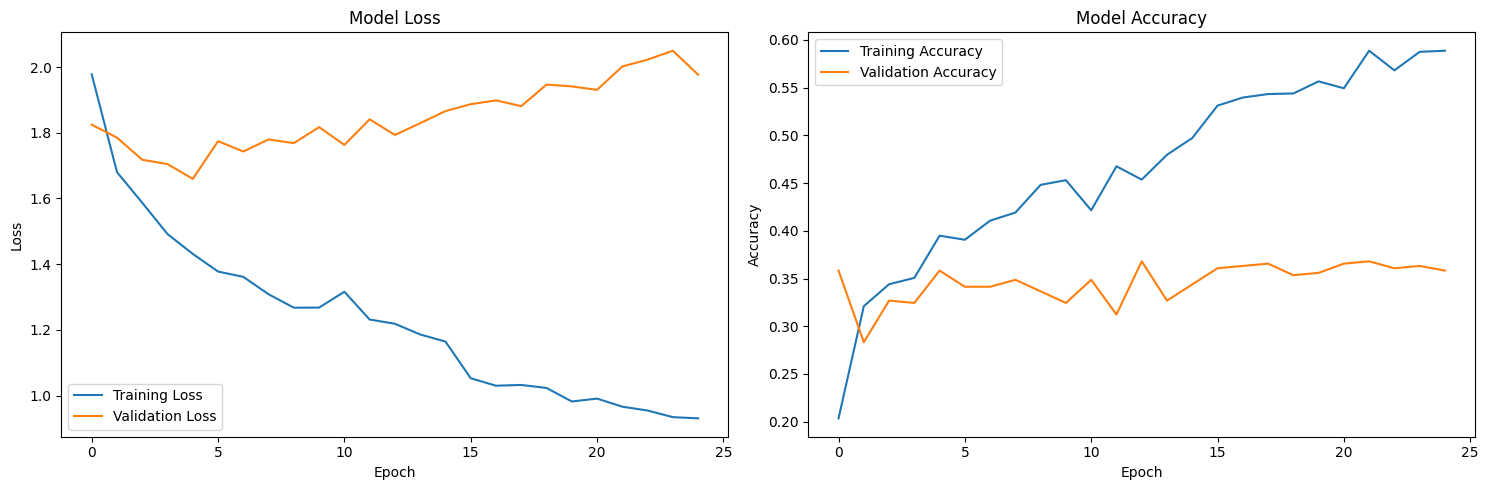

 Оценка модели...
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 463ms/step
 F1 Score: 0.3574

 Обучение завершено! Final F1: 0.3574


In [ ]:
X_maccs, X_morgan, y_categorical, label_encoder = prepare_data(cnn_df)

print(" Создание и обучение модели...")
model, history, test_data = train_model(X_maccs, X_morgan, y_categorical)

print(" Визуализация обучения...")
plot_training_history(history)

print(" Оценка модели...")
f1_score = evaluate_model(model, *test_data, label_encoder)

print(f"\n Обучение завершено! Final F1: {f1_score:.4f}")

Final F1: 0.3574

**Эксперименты с весами (без изменения других параметров)**

- MACCS + Morgan
- Dense: 512 + 256 (BatchNorm, LeakyReLU: alpha=0.01, Dropout: 0.2, 0.1)
- Conv1D: 128 + 256 + 512 (Dropout: 0.2, 0.2)

Общий классификатор: 512 + 256 + 128 (Dropout: 0.3, 0.2, LeakyReLU: 0.01)

- AdamW: lr=0.001, weight_decay=1e-5

Веса взяты обратно пропорционально частоте встречаемости классов:

In [ ]:
class_weights = {
    0: 0.8,   # 25.7% - немного уменьшен
    1: 1.2,   # 14.3% - немного усилен
    2: 1.5,   # 10.7% - усилен
    3: 1.0,   # 19.5% - нейтрально
    4: 1.3,   # 13.9% - немного усилен
    5: 3.5,   # 2.1% - сильно усилен
    6: 2.5,   # 4.1% - усилен
    7: 1.8    # 9.8% - усилен
}

In [ ]:
def prepare_data(df):
    """Подготовка данных для multi-input модели"""

    # Разделяем на признаки и целевую переменную
    X_maccs = df.filter(regex='MACCS').values  # MACCS фичи
    X_morgan = df.filter(regex='Morgan').values  # Morgan fingerprints
    y = df['taste_cluster'].values  # Целевая переменная

    # Кодируем целевую переменную
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    y_categorical = to_categorical(y_encoded)

    # Нормализуем данные
    scaler_maccs = StandardScaler()
    scaler_morgan = StandardScaler()

    X_maccs_scaled = scaler_maccs.fit_transform(X_maccs)
    X_morgan_scaled = scaler_morgan.fit_transform(X_morgan)

    return X_maccs_scaled, X_morgan_scaled, y_categorical, le

def create_cnn(num_classes, maccs_dim=167, morgan_dim=2048):
    """Создание multi-input CNN модели"""

    # Вход для разных типов дескрипторов
    maccs_input = Input(shape=(maccs_dim,), name='maccs_input')
    morgan_input = Input(shape=(morgan_dim,), name='morgan_input')

    # Ветка для MACCS (плотные слои)
    maccs_branch = Dense(512)(maccs_input)
    maccs_branch = BatchNormalization()(maccs_branch)
    maccs_branch = LeakyReLU(alpha=0.01)(maccs_branch)
    maccs_branch = Dropout(0.2)(maccs_branch)
    maccs_branch = Dense(256)(maccs_branch)
    maccs_branch = BatchNormalization()(maccs_branch)
    maccs_branch = LeakyReLU(alpha=0.01)(maccs_branch)
    maccs_branch = Dropout(0.1)(maccs_branch)

    # Ветка для Morgan (CNN)
    morgan_branch = Reshape((morgan_dim, 1))(morgan_input)
    morgan_branch = Conv1D(128, kernel_size=7, activation='relu', padding='same')(morgan_branch)
    morgan_branch = Dropout(0.2)(morgan_branch)
    morgan_branch = Conv1D(256, kernel_size=5, activation='relu', padding='same')(morgan_branch)
    morgan_branch = Dropout(0.2)(morgan_branch)
    morgan_branch = Conv1D(512, kernel_size=3, activation='relu', padding='same')(morgan_branch)
    morgan_branch = GlobalMaxPooling1D()(morgan_branch)

    # Объединение ветвей
    concatenated = Concatenate()([maccs_branch, morgan_branch])

    # Общий классификатор
    x = Dense(512)(concatenated)
    x = LeakyReLU(alpha=0.01)(x)
    x = Dropout(0.3)(x)
    x = Dense(256)(x)
    x = LeakyReLU(alpha=0.01)(x)
    x = Dropout(0.2)(x)
    x = Dense(128)(x)
    x = LeakyReLU(alpha=0.01)(x)

    # Выходной слой
    outputs = Dense(num_classes, activation='softmax')(x)

    # Создание модели
    model = Model(inputs=[maccs_input, morgan_input], outputs=outputs)

    # Компиляция
    model.compile(
        optimizer=AdamW(learning_rate=0.001, weight_decay=1e-5),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

def train_model(X_maccs, X_morgan, y, test_size=0.2, random_state=42):
    """Обучение multi-input модели"""

    # Разделение данных
    X_maccs_train, X_maccs_test, X_morgan_train, X_morgan_test, y_train, y_test = train_test_split(
        X_maccs, X_morgan, y, test_size=test_size, random_state=random_state,
        stratify=y.argmax(axis=1)
    )

    # Создание модели
    num_classes = y.shape[1]
    model = create_cnn(num_classes, X_maccs.shape[1], X_morgan.shape[1])

    class_weights = {
    0: 0.8,   # 25.7% - немного уменьшен
    1: 1.2,   # 14.3% - немного усилен
    2: 1.5,   # 10.7% - усилен
    3: 1.0,   # 19.5% - нейтрально
    4: 1.3,   # 13.9% - немного усилен
    5: 3.5,   # 2.1% - сильно усилен
    6: 2.5,   # 4.1% - усилен
    7: 1.8    # 9.8% - усилен
    }  # веса

    # Callbacks
    callbacks = [
        EarlyStopping(patience=20, restore_best_weights=True, monitor='val_loss'),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-7)
    ]

    # Обучение
    history = model.fit(
        [X_maccs_train, X_morgan_train],
        y_train,
        validation_data=([X_maccs_test, X_morgan_test], y_test),
        epochs=100,
        batch_size=32,
        class_weight=class_weights,
        callbacks=callbacks,
        verbose=1
    )

    return model, history, (X_maccs_test, X_morgan_test, y_test)

# Визуализация обучения
def plot_training_history(history):
    """Визуализация процесса обучения"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # График потерь
    ax1.plot(history.history['loss'], label='Training Loss')
    ax1.plot(history.history['val_loss'], label='Validation Loss')
    ax1.set_title('Model Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # График точности
    ax2.plot(history.history['accuracy'], label='Training Accuracy')
    ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax2.set_title('Model Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    plt.tight_layout()
    plt.show()

# Функция для оценки модели
def evaluate_model(model, X_maccs_test, X_morgan_test, y_test, label_encoder):
    """Оценка модели и вывод метрик"""
    from sklearn.metrics import classification_report, f1_score

    # Предсказания
    y_pred = model.predict([X_maccs_test, X_morgan_test])
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)

    f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')
    print(f" F1 Score: {f1:.4f}")

    return f1

 Создание и обучение модели...
Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


52/52 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - accuracy: 0.2213 - loss: 2.5886 - val_accuracy: 0.3027 - val_loss: 1.8816 - learning_rate: 0.0010
Epoch 2/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 145s 2s/step - accuracy: 0.3591 - loss: 2.1366 - val_accuracy: 0.4019 - val_loss: 1.6448 - learning_rate: 0.0010
Epoch 3/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - accuracy: 0.3831 - loss: 2.0021 - val_accuracy: 0.3705 - val_loss: 1.6870 - learning_rate: 0.0010
Epoch 4/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - accuracy: 0.4297 - loss: 1.8794 - val_accuracy: 0.3584 - val_loss: 1.6770 - learning_rate: 0.0010
Epoch 5/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.4182 - loss: 1.8518 - val_accuracy: 0.3898 - val_loss: 1.6178 - learning_rate: 0.0010
Epoch 6/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 138s 2s/step - accuracy: 0.4232 - loss: 1.7789 - val_accuracy: 0.3608 - val_loss: 1.6995 - learning_rate: 0.0010
Epoch 7/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - accuracy: 0.4597 - loss: 1.7310 - val_accuracy: 0.

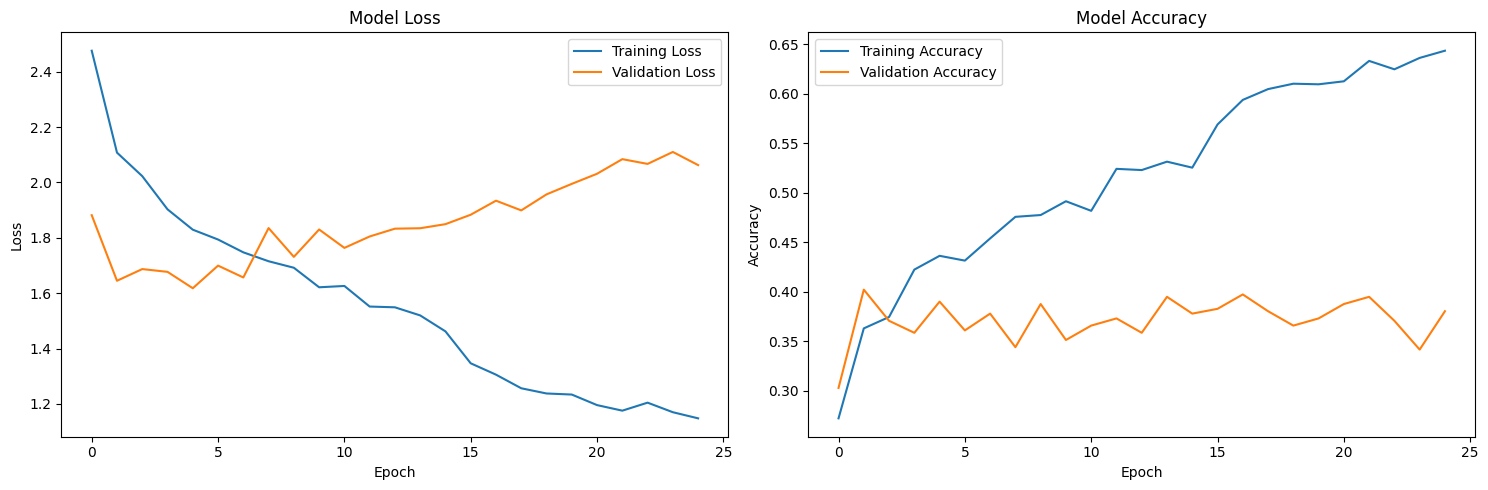

 Оценка модели...
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 483ms/step
 F1 Score: 0.3969

 Обучение завершено! Final F1: 0.3969


In [ ]:
X_maccs, X_morgan, y_categorical, label_encoder = prepare_data(cnn_df)

print(" Создание и обучение модели...")
model, history, test_data = train_model(X_maccs, X_morgan, y_categorical)

print(" Визуализация обучения...")
plot_training_history(history)

print(" Оценка модели...")
f1_score = evaluate_model(model, *test_data, label_encoder)

print(f"\n Обучение завершено! Final F1: {f1_score:.4f}")

**Final F1: 0.3969**

F1 показатель улучшился, но все еще есть сильное переобучение

**Эксперимент с усиленными весами (без изменения других параметров)**

- MACCS + Morgan
- compute_class_weight
- Dense: 512 + 256 (BatchNorm, LeakyReLU: alpha=0.01, Dropout: 0.2, 0.1)
- Conv1D: 128 + 256 + 512 (Dropout: 0.2, 0.2)

Общий классификатор: 512 + 256 + 128 (Dropout: 0.3, 0.2, LeakyReLU: 0.01)

- AdamW: lr=0.001, weight_decay=1e-5

In [ ]:
class_weights = {
    0: 0.57,  # 25.7% - самый большой класс
    1: 0.76,  # 14.3%
    2: 0.89,  # 10.7%
    3: 0.65,  # 19.5%
    4: 0.78,  # 13.9%
    5: 2.00,  # 2.1% - сильно усилен
    6: 1.42,  # 4.1% - усилен
    7: 0.92   # 9.8%
}

In [ ]:
def prepare_data(df):
    """Подготовка данных для multi-input модели"""

    # Разделяем на признаки и целевую переменную
    X_maccs = df.filter(regex='MACCS').values  # MACCS фичи
    X_morgan = df.filter(regex='Morgan').values  # Morgan fingerprints
    y = df['taste_cluster'].values  # Целевая переменная

    # Кодируем целевую переменную
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    y_categorical = to_categorical(y_encoded)

    # Нормализуем данные
    scaler_maccs = StandardScaler()
    scaler_morgan = StandardScaler()

    X_maccs_scaled = scaler_maccs.fit_transform(X_maccs)
    X_morgan_scaled = scaler_morgan.fit_transform(X_morgan)

    return X_maccs_scaled, X_morgan_scaled, y_categorical, le

def create_cnn(num_classes, maccs_dim=167, morgan_dim=2048):
    """Создание multi-input CNN модели"""

    # Вход для разных типов дескрипторов
    maccs_input = Input(shape=(maccs_dim,), name='maccs_input')
    morgan_input = Input(shape=(morgan_dim,), name='morgan_input')

    # Ветка для MACCS (плотные слои)
    maccs_branch = Dense(512)(maccs_input)
    maccs_branch = BatchNormalization()(maccs_branch)
    maccs_branch = LeakyReLU(alpha=0.01)(maccs_branch)
    maccs_branch = Dropout(0.2)(maccs_branch)
    maccs_branch = Dense(256)(maccs_branch)
    maccs_branch = BatchNormalization()(maccs_branch)
    maccs_branch = LeakyReLU(alpha=0.01)(maccs_branch)
    maccs_branch = Dropout(0.1)(maccs_branch)

    # Ветка для Morgan (CNN)
    morgan_branch = Reshape((morgan_dim, 1))(morgan_input)
    morgan_branch = Conv1D(128, kernel_size=7, activation='relu', padding='same')(morgan_branch)
    morgan_branch = Dropout(0.2)(morgan_branch)
    morgan_branch = Conv1D(256, kernel_size=5, activation='relu', padding='same')(morgan_branch)
    morgan_branch = Dropout(0.2)(morgan_branch)
    morgan_branch = Conv1D(512, kernel_size=3, activation='relu', padding='same')(morgan_branch)
    morgan_branch = GlobalMaxPooling1D()(morgan_branch)

    # Объединение ветвей
    concatenated = Concatenate()([maccs_branch, morgan_branch])

    # Общий классификатор
    x = Dense(512)(concatenated)
    x = LeakyReLU(alpha=0.01)(x)
    x = Dropout(0.3)(x)
    x = Dense(256)(x)
    x = LeakyReLU(alpha=0.01)(x)
    x = Dropout(0.2)(x)
    x = Dense(128)(x)
    x = LeakyReLU(alpha=0.01)(x)

    # Выходной слой
    outputs = Dense(num_classes, activation='softmax')(x)

    # Создание модели
    model = Model(inputs=[maccs_input, morgan_input], outputs=outputs)

    # Компиляция
    model.compile(
        optimizer=AdamW(learning_rate=0.001, weight_decay=1e-5),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

def train_model(X_maccs, X_morgan, y, test_size=0.2, random_state=42):
    """Обучение multi-input модели"""

    # Разделение данных
    X_maccs_train, X_maccs_test, X_morgan_train, X_morgan_test, y_train, y_test = train_test_split(
        X_maccs, X_morgan, y, test_size=test_size, random_state=random_state,
        stratify=y.argmax(axis=1)
    )

    # Создание модели
    num_classes = y.shape[1]
    model = create_cnn(num_classes, X_maccs.shape[1], X_morgan.shape[1])

    class_weights = {
    0: 0.57,  # 25.7% - самый большой класс
    1: 0.76,  # 14.3%
    2: 0.89,  # 10.7%
    3: 0.65,  # 19.5%
    4: 0.78,  # 13.9%
    5: 2.00,  # 2.1% - сильно усилен
    6: 1.42,  # 4.1% - усилен
    7: 0.92   # 9.8%
} # веса

    # Callbacks
    callbacks = [
        EarlyStopping(patience=20, restore_best_weights=True, monitor='val_loss'),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-7)
    ]

    # Обучение
    history = model.fit(
        [X_maccs_train, X_morgan_train],
        y_train,
        validation_data=([X_maccs_test, X_morgan_test], y_test),
        epochs=100,
        batch_size=32,
        class_weight=class_weights,
        callbacks=callbacks,
        verbose=1
    )

    return model, history, (X_maccs_test, X_morgan_test, y_test)

# Визуализация обучения
def plot_training_history(history):
    """Визуализация процесса обучения"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # График потерь
    ax1.plot(history.history['loss'], label='Training Loss')
    ax1.plot(history.history['val_loss'], label='Validation Loss')
    ax1.set_title('Model Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # График точности
    ax2.plot(history.history['accuracy'], label='Training Accuracy')
    ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax2.set_title('Model Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    plt.tight_layout()
    plt.show()

# Функция для оценки модели
def evaluate_model(model, X_maccs_test, X_morgan_test, y_test, label_encoder):
    """Оценка модели и вывод метрик"""
    from sklearn.metrics import classification_report, f1_score

    # Предсказания
    y_pred = model.predict([X_maccs_test, X_morgan_test])
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)

    f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')
    print(f" F1 Score: {f1:.4f}")

    return f1

 Создание и обучение модели...
Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


52/52 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - accuracy: 0.2799 - loss: 1.5352 - val_accuracy: 0.3777 - val_loss: 1.7281 - learning_rate: 0.0010
Epoch 2/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - accuracy: 0.3972 - loss: 1.2909 - val_accuracy: 0.3995 - val_loss: 1.6185 - learning_rate: 0.0010
Epoch 3/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.4365 - loss: 1.1916 - val_accuracy: 0.3559 - val_loss: 1.6508 - learning_rate: 0.0010
Epoch 4/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.4286 - loss: 1.1563 - val_accuracy: 0.3608 - val_loss: 1.5909 - learning_rate: 0.0010
Epoch 5/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 138s 2s/step - accuracy: 0.4394 - loss: 1.1269 - val_accuracy: 0.3923 - val_loss: 1.6511 - learning_rate: 0.0010
Epoch 6/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.4461 - loss: 1.0625 - val_accuracy: 0.3632 - val_loss: 1.6874 - learning_rate: 0.0010
Epoch 7/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - accuracy: 0.4761 - loss: 1.0640 - val_accuracy: 0.

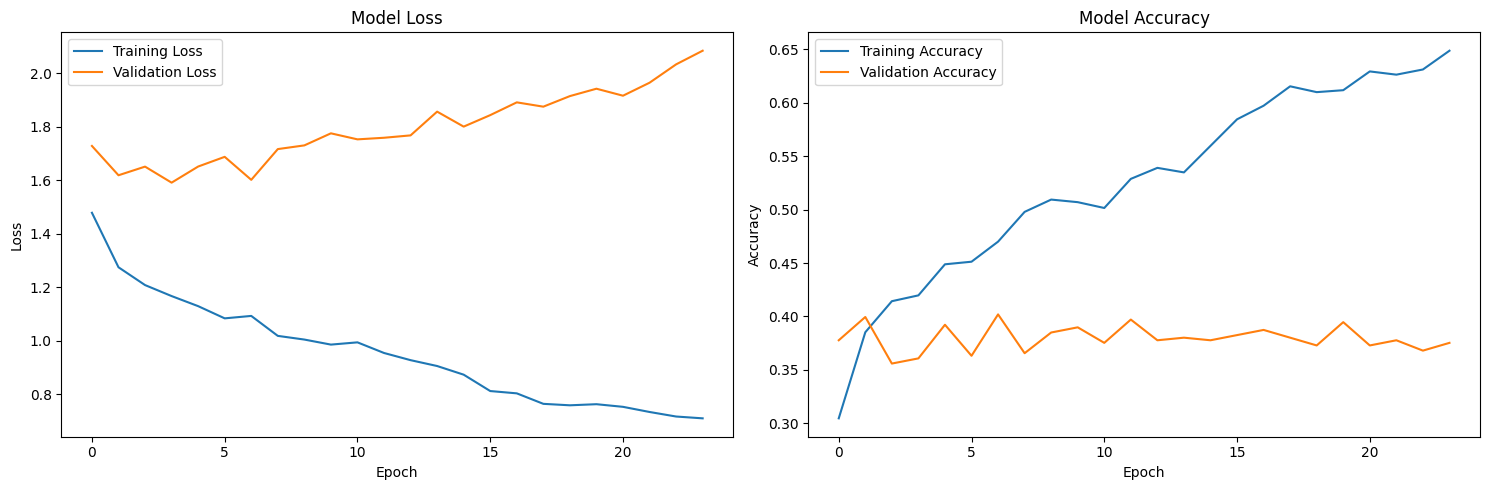

 Оценка модели...
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 480ms/step
 F1 Score: 0.3645

 Обучение завершено! Final F1: 0.3645


In [ ]:
X_maccs, X_morgan, y_categorical, label_encoder = prepare_data(cnn_df)

print(" Создание и обучение модели...")
model, history, test_data = train_model(X_maccs, X_morgan, y_categorical)

print(" Визуализация обучения...")
plot_training_history(history)

print(" Оценка модели...")
f1_score = evaluate_model(model, *test_data, label_encoder)

print(f"\n Обучение завершено! Final F1: {f1_score:.4f}")

Final F1: 0.3645

**Немного измененные параметры (без изменения весов):**

- MACCS + Morgan
- Dense: 512 + 256 (BatchNorm, ReLU, Dropout: 0.2, 0.1)
- Conv1D: 128 + 256 + 512 (Dropout: 0.2, 0.2)

Общий классификатор: 512 + 256 + 128 (Dropout: 0.3, 0.2, ReLU)

- Adam: lr=0.001

In [ ]:
class_weights = {
    0: 0.8,   # 25.7% - немного уменьшен
    1: 1.2,   # 14.3% - немного усилен
    2: 1.5,   # 10.7% - усилен
    3: 1.0,   # 19.5% - нейтрально
    4: 1.3,   # 13.9% - немного усилен
    5: 3.5,   # 2.1% - сильно усилен
    6: 2.5,   # 4.1% - усилен
    7: 1.8    # 9.8% - усилен
}

In [ ]:
from tensorflow.keras.optimizers import Adam

def prepare_data(df):
    """Подготовка данных для multi-input модели"""

    # Разделяем на признаки и целевую переменную
    X_maccs = df.filter(regex='MACCS').values  # MACCS фичи
    X_morgan = df.filter(regex='Morgan').values  # Morgan fingerprints
    y = df['taste_cluster'].values  # Целевая переменная

    # Кодируем целевую переменную
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    y_categorical = to_categorical(y_encoded)

    # Нормализуем данные
    scaler_maccs = StandardScaler()
    scaler_morgan = StandardScaler()

    X_maccs_scaled = scaler_maccs.fit_transform(X_maccs)
    X_morgan_scaled = scaler_morgan.fit_transform(X_morgan)

    return X_maccs_scaled, X_morgan_scaled, y_categorical, le

def create_cnn(num_classes, maccs_dim=167, morgan_dim=2048):
    """Создание multi-input CNN модели"""

    # Вход для разных типов дескрипторов
    maccs_input = Input(shape=(maccs_dim,), name='maccs_input')
    morgan_input = Input(shape=(morgan_dim,), name='morgan_input')

    # Ветка для MACCS (плотные слои)
    maccs_branch = Dense(512, activation='relu')(maccs_input)
    maccs_branch = Dropout(0.2)(maccs_branch)
    maccs_branch = Dense(256, activation='relu')(maccs_branch)
    maccs_branch = Dropout(0.1)(maccs_branch)

    # Ветка для Morgan (CNN)
    morgan_branch = Reshape((morgan_dim, 1))(morgan_input)
    morgan_branch = Conv1D(128, kernel_size=7, activation='relu', padding='same')(morgan_branch)
    morgan_branch = Dropout(0.2)(morgan_branch)
    morgan_branch = Conv1D(256, kernel_size=5, activation='relu', padding='same')(morgan_branch)
    morgan_branch = Dropout(0.2)(morgan_branch)
    morgan_branch = Conv1D(512, kernel_size=3, activation='relu', padding='same')(morgan_branch)
    morgan_branch = GlobalMaxPooling1D()(morgan_branch)

    # Объединение ветвей
    concatenated = Concatenate()([maccs_branch, morgan_branch])

    # Общий классификатор
    x = Dense(512, activation='relu')(concatenated)
    x = Dropout(0.3)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(128, activation='relu')(x)

    # Выходной слой
    outputs = Dense(num_classes, activation='softmax')(x)

    # Создание модели
    model = Model(inputs=[maccs_input, morgan_input], outputs=outputs)

    # Компиляция
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

def train_model(X_maccs, X_morgan, y, test_size=0.2, random_state=42):
    """Обучение multi-input модели"""

    # Разделение данных
    X_maccs_train, X_maccs_test, X_morgan_train, X_morgan_test, y_train, y_test = train_test_split(
        X_maccs, X_morgan, y, test_size=test_size, random_state=random_state,
        stratify=y.argmax(axis=1)
    )

    # Создание модели
    num_classes = y.shape[1]
    model = create_cnn(num_classes, X_maccs.shape[1], X_morgan.shape[1])

    class_weights = {
    0: 0.8,   # 25.7% - немного уменьшен
    1: 1.2,   # 14.3% - немного усилен
    2: 1.5,   # 10.7% - усилен
    3: 1.0,   # 19.5% - нейтрально
    4: 1.3,   # 13.9% - немного усилен
    5: 3.5,   # 2.1% - сильно усилен
    6: 2.5,   # 4.1% - усилен
    7: 1.8    # 9.8% - усилен
    } # веса

    # Callbacks
    callbacks = [
        EarlyStopping(patience=20, restore_best_weights=True, monitor='val_loss'),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-7)
    ]

    # Обучение
    history = model.fit(
        [X_maccs_train, X_morgan_train],
        y_train,
        validation_data=([X_maccs_test, X_morgan_test], y_test),
        epochs=100,
        batch_size=32,
        class_weight=class_weights,
        callbacks=callbacks,
        verbose=1
    )

    return model, history, (X_maccs_test, X_morgan_test, y_test)

# Визуализация обучения
def plot_training_history(history):
    """Визуализация процесса обучения"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # График потерь
    ax1.plot(history.history['loss'], label='Training Loss')
    ax1.plot(history.history['val_loss'], label='Validation Loss')
    ax1.set_title('Model Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # График точности
    ax2.plot(history.history['accuracy'], label='Training Accuracy')
    ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax2.set_title('Model Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    plt.tight_layout()
    plt.show()

# Функция для оценки модели
def evaluate_model(model, X_maccs_test, X_morgan_test, y_test, label_encoder):
    """Оценка модели и вывод метрик"""
    from sklearn.metrics import classification_report, f1_score

    # Предсказания
    y_pred = model.predict([X_maccs_test, X_morgan_test])
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)

    f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')
    print(f" F1 Score: {f1:.4f}")

    return f1

 Создание и обучение модели...
Epoch 1/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.1972 - loss: 2.6299 - val_accuracy: 0.3341 - val_loss: 1.8184 - learning_rate: 0.0010
Epoch 2/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - accuracy: 0.3734 - loss: 2.2019 - val_accuracy: 0.3584 - val_loss: 1.6619 - learning_rate: 0.0010
Epoch 3/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - accuracy: 0.3578 - loss: 1.9905 - val_accuracy: 0.3148 - val_loss: 1.7012 - learning_rate: 0.0010
Epoch 4/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 136s 2s/step - accuracy: 0.3953 - loss: 1.8736 - val_accuracy: 0.3680 - val_loss: 1.6537 - learning_rate: 0.0010
Epoch 5/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 0.3975 - loss: 1.8632 - val_accuracy: 0.3923 - val_loss: 1.7189 - learning_rate: 0.0010
Epoch 6/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 0.4491 - loss: 1.7869 - val_accuracy: 0.3874 - val_loss: 1.6776 - learning_rate: 0.0010
Epoch 7/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - accuracy:

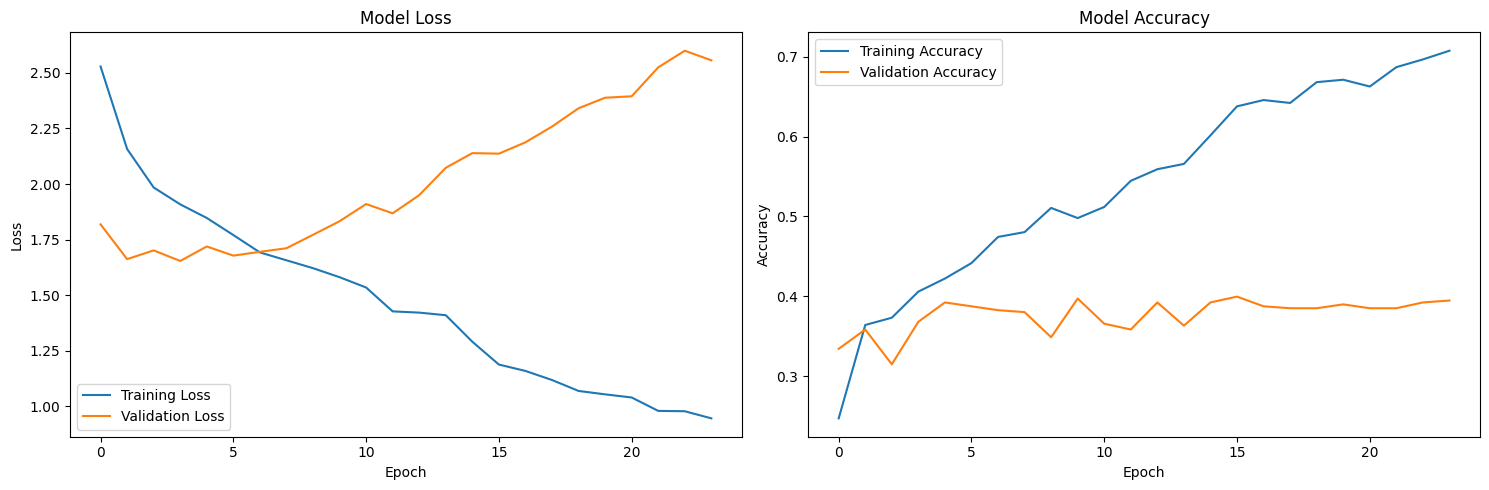

 Оценка модели...
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 445ms/step
 F1 Score: 0.3656

 Обучение завершено! Final F1: 0.3656


In [ ]:
X_maccs, X_morgan, y_categorical, label_encoder = prepare_data(cnn_df)

print(" Создание и обучение модели...")
model, history, test_data = train_model(X_maccs, X_morgan, y_categorical)

print(" Визуализация обучения...")
plot_training_history(history)

print(" Оценка модели...")
f1_score = evaluate_model(model, *test_data, label_encoder)

print(f"\n Обучение завершено! Final F1: {f1_score:.4f}")

Final F1: 0.3656

**Использование Rdkit дескрипторов**

In [ ]:
def prepare_data(df):
    """Подготовка данных для multi-input модели"""

    # Разделяем на признаки и целевую переменную
    X_maccs = df.filter(regex='MACCS').values  # MACCS фичи
    X_morgan = df.filter(regex='Morgan').values  # Morgan fingerprints

    # RDKit дескрипторы - все остальные числовые колонки
    exclude_columns = ['taste_cluster'] + list(df.filter(regex='MACCS|Morgan').columns)
    rdkit_columns = [col for col in df.columns if col not in exclude_columns and pd.api.types.is_numeric_dtype(df[col])]
    X_rdkit = df[rdkit_columns].values

    y = df['taste_cluster'].values  # Целевая переменная

    # Кодируем целевую переменную
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    y_categorical = to_categorical(y_encoded)

    # Нормализуем данные
    scaler_maccs = StandardScaler()
    scaler_morgan = StandardScaler()
    scaler_rdkit = StandardScaler()

    X_maccs_scaled = scaler_maccs.fit_transform(X_maccs)
    X_morgan_scaled = scaler_morgan.fit_transform(X_morgan)
    X_rdkit_scaled = scaler_rdkit.fit_transform(X_rdkit)

    return X_maccs_scaled, X_morgan_scaled, X_rdkit_scaled, y_categorical, le

In [ ]:
def create_cnn(num_classes, maccs_dim=167, morgan_dim=1025, rdkit_dim=None):
    """Создание multi-input CNN модели с RDKit дескрипторами"""

    # Вход для разных типов дескрипторов
    maccs_input = Input(shape=(maccs_dim,), name='maccs_input')
    morgan_input = Input(shape=(morgan_dim,), name='morgan_input')
    rdkit_input = Input(shape=(rdkit_dim,), name='rdkit_input')

    # Ветка для MACCS
    maccs_branch = Dense(256)(maccs_input)
    maccs_branch = BatchNormalization()(maccs_branch)
    maccs_branch = LeakyReLU(alpha=0.01)(maccs_branch)
    maccs_branch = Dropout(0.3)(maccs_branch)

    maccs_branch = Dense(128)(maccs_branch)
    maccs_branch = BatchNormalization()(maccs_branch)
    maccs_branch = LeakyReLU(alpha=0.01)(maccs_branch)
    maccs_branch = Dropout(0.2)(maccs_branch)

    # Ветка для Morgan (CNN)
    morgan_branch = Reshape((morgan_dim, 1))(morgan_input)
    morgan_branch = Conv1D(128, kernel_size=7, activation='relu', padding='same')(morgan_branch)
    morgan_branch = Dropout(0.2)(morgan_branch)
    morgan_branch = Conv1D(256, kernel_size=5, activation='relu', padding='same')(morgan_branch)
    morgan_branch = Dropout(0.2)(morgan_branch)
    morgan_branch = Conv1D(512, kernel_size=3, activation='relu', padding='same')(morgan_branch)
    morgan_branch = GlobalMaxPooling1D()(morgan_branch)

    # Ветка для RDKit
    rdkit_branch = Dense(512)(rdkit_input)
    rdkit_branch = BatchNormalization()(rdkit_branch)
    rdkit_branch = LeakyReLU(alpha=0.01)(rdkit_branch)
    rdkit_branch = Dropout(0.3)(rdkit_branch)

    rdkit_branch = Dense(256)(rdkit_branch)
    rdkit_branch = BatchNormalization()(rdkit_branch)
    rdkit_branch = LeakyReLU(alpha=0.01)(rdkit_branch)
    rdkit_branch = Dropout(0.2)(rdkit_branch)

    # Объединение всех ветвей
    concatenated = Concatenate()([maccs_branch, morgan_branch, rdkit_branch])

    # Общий классификатор
    x = Dense(512)(concatenated)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.01)(x)
    x = Dropout(0.4)(x)

    x = Dense(256)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.01)(x)
    x = Dropout(0.3)(x)

    x = Dense(128)(x)
    x = LeakyReLU(alpha=0.01)(x)

    # Выходной слой
    outputs = Dense(num_classes, activation='softmax')(x)

    # Создание модели
    model = Model(inputs=[maccs_input, morgan_input, rdkit_input], outputs=outputs)

    # Компиляция
    model.compile(
        optimizer=AdamW(learning_rate=0.0005, weight_decay=1e-5),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [ ]:
def train_model(X_maccs, X_morgan, X_rdkit, y, test_size=0.2, random_state=42):
    """Обучение multi-input модели с RDKit"""

    # Разделение данных
    X_maccs_train, X_maccs_test, X_morgan_train, X_morgan_test, X_rdkit_train, X_rdkit_test, y_train, y_test = train_test_split(
        X_maccs, X_morgan, X_rdkit, y, test_size=test_size, random_state=random_state,
        stratify=y.argmax(axis=1)
    )

    # Создание модели
    num_classes = y.shape[1]
    model = create_cnn(num_classes, X_maccs.shape[1], X_morgan.shape[1], X_rdkit.shape[1])

    # Веса классов
    class_weights = {
        0: 0.8, 1: 1.2, 2: 1.5, 3: 1.0,
        4: 1.3, 5: 3.5, 6: 2.5, 7: 1.8
    }

    # Callbacks
    callbacks = [
        EarlyStopping(patience=20, restore_best_weights=True, monitor='val_loss'),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-7)
    ]

    # Обучение
    history = model.fit(
        [X_maccs_train, X_morgan_train, X_rdkit_train],
        y_train,
        validation_data=([X_maccs_test, X_morgan_test, X_rdkit_test], y_test),
        epochs=100,
        batch_size=32,
        class_weight=class_weights,
        callbacks=callbacks,
        verbose=1
    )

    return model, history, (X_maccs_test, X_morgan_test, X_rdkit_test, y_test)

In [ ]:
X_maccs, X_morgan, X_rdkit, y_categorical, label_encoder = prepare_data(cnn_df)
model, history, test_data = train_model(X_maccs, X_morgan, X_rdkit, y_categorical)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - accuracy: 0.2223 - loss: 2.7919 - val_accuracy: 0.2155 - val_loss: 1.9813 - learning_rate: 5.0000e-04
Epoch 2/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.3178 - loss: 2.3056 - val_accuracy: 0.2930 - val_loss: 1.8491 - learning_rate: 5.0000e-04
Epoch 3/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.3161 - loss: 2.2212 - val_accuracy: 0.3487 - val_loss: 1.7589 - learning_rate: 5.0000e-04
Epoch 4/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 138s 2s/step - accuracy: 0.3371 - loss: 2.1496 - val_accuracy: 0.3099 - val_loss: 1.7284 - learning_rate: 5.0000e-04
Epoch 5/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.3831 - loss: 2.0735 - val_accuracy: 0.2857 - val_loss: 1.7963 - learning_rate: 5.0000e-04
Epoch 6/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 146s 2s/step - accuracy: 0.3784 - loss: 2.0510 - val_accuracy: 0.3269 - val_loss: 1.6671 - learning_rate: 5.0000e-04
Epoch 7/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 138s 2s/step - accuracy: 0.3

In [ ]:
def plot_training_history(history):
    """Визуализация процесса обучения для multi-input модели"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # График потерь
    ax1.plot(history.history['loss'], label='Training Loss')
    ax1.plot(history.history['val_loss'], label='Validation Loss')
    ax1.set_title('Model Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # График точности
    ax2.plot(history.history['accuracy'], label='Training Accuracy')
    ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax2.set_title('Model Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
def evaluate_model(model, test_data, label_encoder):
    """Оценка модели с тремя входами"""
    from sklearn.metrics import classification_report, f1_score

    # Распаковываем тестовые данные
    X_maccs_test, X_morgan_test, X_rdkit_test, y_test = test_data

    # Предсказания
    y_pred = model.predict([X_maccs_test, X_morgan_test, X_rdkit_test])
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)

    # F1-score
    f1 = f1_score(y_true_classes, y_pred_classes, average='macro')
    print(f" F1 Score: {f1:.4f}")

    return f1

 Визуализация обучения...


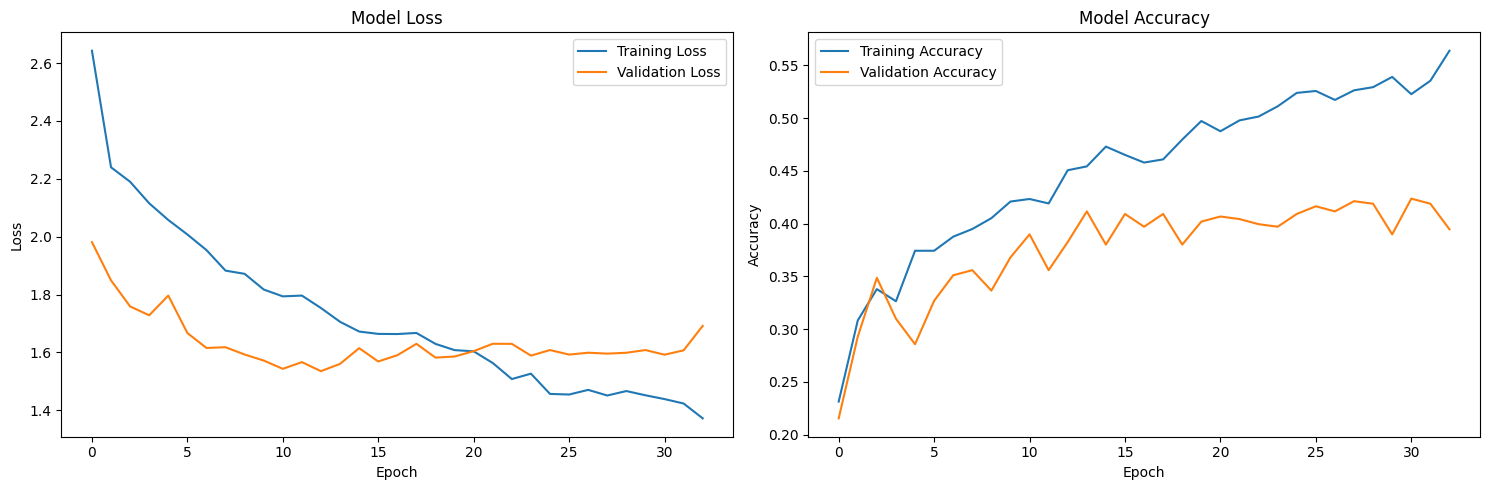

 Оценка модели...
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 431ms/step
 F1 Score: 0.3888

 Обучение завершено! Final F1: 0.3888


In [ ]:
print(" Визуализация обучения...")
plot_training_history(history)

print(" Оценка модели...")
f1_score = evaluate_model(model, test_data, label_encoder)

print(f"\n Обучение завершено! Final F1: {f1_score:.4f}")

**Final F1: 0.3888**

у данной модели наилучшая сходимость train и val => можно попробовать использовать для ансамблирования

**Ensemble: XGBoost + CNN**

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import f1_score, classification_report
from sklearn.linear_model import LogisticRegression
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from xgboost import XGBClassifier

# Параметры XGBoost
best_xgb_params = {
    'n_estimators': 469,
    'learning_rate': 0.018178038693680947,
    'max_depth': 11,
    'min_child_weight': 8,
    'subsample': 0.7246557270256099,
    'colsample_bytree': 0.9125800981272568,
    'reg_alpha': 0.05665157807560248,
    'reg_lambda': 0.003361903890616946,
    'random_state': 42
}

def prepare_stacking_data(cnn_df, test_size=0.2):
    """Подготовка данных для stacking"""

    # Разделяем данные
    train_df, test_df = train_test_split(
        cnn_df, test_size=test_size, random_state=42,
        stratify=cnn_df['taste_cluster']
    )

    # Для XGBoost - все фичи
    X_train_xgb = train_df.drop('taste_cluster', axis=1)
    X_test_xgb = test_df.drop('taste_cluster', axis=1)

    # Для CNN - разделенные фичи
    X_train_maccs = train_df.filter(regex='MACCS').values
    X_train_morgan = train_df.filter(regex='Morgan').values
    X_train_rdkit = train_df.drop(columns=['taste_cluster'] +
                                 list(train_df.filter(regex='MACCS|Morgan').columns)).values

    X_test_maccs = test_df.filter(regex='MACCS').values
    X_test_morgan = test_df.filter(regex='Morgan').values
    X_test_rdkit = test_df.drop(columns=['taste_cluster'] +
                               list(test_df.filter(regex='MACCS|Morgan').columns)).values

    # Целевая переменная
    le = LabelEncoder()
    y_train = le.fit_transform(train_df['taste_cluster'])
    y_test = le.transform(test_df['taste_cluster'])
    y_train_categorical = to_categorical(y_train)
    y_test_categorical = to_categorical(y_test)

    print(" Stacking данные подготовлены:")
    print(f"XGBoost: {X_train_xgb.shape}")
    print(f"CNN MACCS: {X_train_maccs.shape}")
    print(f"CNN Morgan: {X_train_morgan.shape}")
    print(f"CNN RDKit: {X_train_rdkit.shape}")
    print(f"Classes: {len(le.classes_)}")

    return (X_train_xgb, X_test_xgb,
            X_train_maccs, X_train_morgan, X_train_rdkit,
            X_test_maccs, X_test_morgan, X_test_rdkit,
            y_train, y_test, y_train_categorical, y_test_categorical, le)

def create_cnn(num_classes, maccs_dim=167, morgan_dim=1025, rdkit_dim=None):
    """Создание multi-input CNN модели"""
    from tensorflow.keras.layers import Input, Dense, Conv1D, GlobalMaxPooling1D, Dropout, Concatenate, Reshape, LeakyReLU, BatchNormalization
    from tensorflow.keras.models import Model
    from tensorflow.keras.optimizers import AdamW

    # Вход для разных типов дескрипторов
    maccs_input = Input(shape=(maccs_dim,), name='maccs_input')
    morgan_input = Input(shape=(morgan_dim,), name='morgan_input')
    rdkit_input = Input(shape=(rdkit_dim,), name='rdkit_input')

    # Ветка для MACCS
    maccs_branch = Dense(256)(maccs_input)
    maccs_branch = BatchNormalization()(maccs_branch)
    maccs_branch = LeakyReLU(alpha=0.01)(maccs_branch)
    maccs_branch = Dropout(0.3)(maccs_branch)

    maccs_branch = Dense(128)(maccs_branch)
    maccs_branch = BatchNormalization()(maccs_branch)
    maccs_branch = LeakyReLU(alpha=0.01)(maccs_branch)
    maccs_branch = Dropout(0.2)(maccs_branch)

    # Ветка для Morgan (CNN)
    morgan_branch = Reshape((morgan_dim, 1))(morgan_input)
    morgan_branch = Conv1D(128, kernel_size=7, activation='relu', padding='same')(morgan_branch)
    morgan_branch = Dropout(0.2)(morgan_branch)
    morgan_branch = Conv1D(256, kernel_size=5, activation='relu', padding='same')(morgan_branch)
    morgan_branch = Dropout(0.2)(morgan_branch)
    morgan_branch = Conv1D(512, kernel_size=3, activation='relu', padding='same')(morgan_branch)
    morgan_branch = GlobalMaxPooling1D()(morgan_branch)

    # Ветка для RDKit
    rdkit_branch = Dense(512)(rdkit_input)
    rdkit_branch = BatchNormalization()(rdkit_branch)
    rdkit_branch = LeakyReLU(alpha=0.01)(rdkit_branch)
    rdkit_branch = Dropout(0.3)(rdkit_branch)

    rdkit_branch = Dense(256)(rdkit_branch)
    rdkit_branch = BatchNormalization()(rdkit_branch)
    rdkit_branch = LeakyReLU(alpha=0.01)(rdkit_branch)
    rdkit_branch = Dropout(0.2)(rdkit_branch)

    # Объединение всех ветвей
    concatenated = Concatenate()([maccs_branch, morgan_branch, rdkit_branch])

    # Общий классификатор
    x = Dense(512)(concatenated)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.01)(x)
    x = Dropout(0.4)(x)

    x = Dense(256)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.01)(x)
    x = Dropout(0.3)(x)

    x = Dense(128)(x)
    x = LeakyReLU(alpha=0.01)(x)

    # Выходной слой
    outputs = Dense(num_classes, activation='softmax')(x)

    # Создание модели
    model = Model(inputs=[maccs_input, morgan_input, rdkit_input], outputs=outputs)

    # Компиляция
    model.compile(
        optimizer=AdamW(learning_rate=0.0005, weight_decay=1e-5),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

def train_base_models(X_train_xgb, X_train_maccs, X_train_morgan, X_train_rdkit, y_train, y_train_categorical, num_classes):
    """Обучение базовых моделей"""

    print(" Обучение XGBoost...")
    # XGBoost
    xgb_model = XGBClassifier(**best_xgb_params)
    xgb_model.fit(X_train_xgb, y_train)

    print(" Обучение CNN...")
    # CNN
    cnn_model = create_cnn(
        num_classes=num_classes,
        maccs_dim=X_train_maccs.shape[1],
        morgan_dim=X_train_morgan.shape[1],
        rdkit_dim=X_train_rdkit.shape[1]
    )

    # Веса классов для CNN
    from sklearn.utils.class_weight import compute_class_weight
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weights_dict = dict(enumerate(class_weights))

    # Callbacks
    from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
    callbacks = [
        EarlyStopping(patience=15, restore_best_weights=True, monitor='val_loss'),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-7)
    ]

    # Обучение CNN
    cnn_history = cnn_model.fit(
        [X_train_maccs, X_train_morgan, X_train_rdkit],
        y_train_categorical,
        validation_split=0.2,
        epochs=100,
        batch_size=32,
        class_weight=class_weights_dict,
        callbacks=callbacks,
        verbose=1
    )

    return xgb_model, cnn_model

def create_stacking_features(xgb_model, cnn_model, X_xgb, X_maccs, X_morgan, X_rdkit):
    """Создание features для мета-модели"""

    # Предсказания XGBoost
    xgb_probs = xgb_model.predict_proba(X_xgb)

    # Предсказания CNN
    cnn_probs = cnn_model.predict([X_maccs, X_morgan, X_rdkit])

    # Объединяем вероятности
    stacking_features = np.column_stack([xgb_probs, cnn_probs])

    print(f" Stacking features: {stacking_features.shape}")
    return stacking_features

def evaluate_stacking(stacking_model, stacking_features_test, y_test, xgb_model, cnn_model,
                     X_test_xgb, X_test_maccs, X_test_morgan, X_test_rdkit, le):
    """Оценка stacking ансамбля"""

    # Предсказания stacking
    stacking_preds = stacking_model.predict(stacking_features_test)

    # Предсказания базовых моделей
    xgb_preds = xgb_model.predict(X_test_xgb)
    cnn_preds = np.argmax(cnn_model.predict([X_test_maccs, X_test_morgan, X_test_rdkit]), axis=1)

    # Метрики
    stacking_f1 = f1_score(y_test, stacking_preds, average='macro')
    xgb_f1 = f1_score(y_test, xgb_preds, average='macro')
    cnn_f1 = f1_score(y_test, cnn_preds, average='macro')

    print("\n СРАВНЕНИЕ РЕЗУЛЬТАТОВ:")
    print(f"XGBoost F1: {xgb_f1:.4f}")
    print(f"CNN F1: {cnn_f1:.4f}")
    print(f"Stacking F1: {stacking_f1:.4f}")
    print(f"Улучшение: +{stacking_f1 - max(xgb_f1, cnn_f1):.4f}")

    return stacking_f1

In [ ]:
# 1. Подготовка данных
(X_train_xgb, X_test_xgb,
 X_train_maccs, X_train_morgan, X_train_rdkit,
 X_test_maccs, X_test_morgan, X_test_rdkit,
 y_train, y_test, y_train_categorical, y_test_categorical, le) = prepare_stacking_data(cnn_df)

# 2. Обучение базовых моделей
num_classes = len(le.classes_)
xgb_model, cnn_model = train_base_models(
    X_train_xgb, X_train_maccs, X_train_morgan, X_train_rdkit,
    y_train, y_train_categorical, num_classes
)

# 3. Создание stacking features
print(" Создание stacking features...")
stacking_features_train = create_stacking_features(
    xgb_model, cnn_model, X_train_xgb, X_train_maccs, X_train_morgan, X_train_rdkit
)
stacking_features_test = create_stacking_features(
    xgb_model, cnn_model, X_test_xgb, X_test_maccs, X_test_morgan, X_test_rdkit
)

# 4. Обучение мета-модели
print(" Обучение мета-модели...")
meta_model = LogisticRegression(
    multi_class='multinomial',
    solver='lbfgs',
    max_iter=1000,
    random_state=42
)
meta_model.fit(stacking_features_train, y_train)

# 5. Оценка
stacking_f1 = evaluate_stacking(
    meta_model, stacking_features_test, y_test, xgb_model, cnn_model,
    X_test_xgb, X_test_maccs, X_test_morgan, X_test_rdkit, le
)

print(f"\n STACKING ЗАВЕРШЕН!")
print(f" Final Stacking F1: {stacking_f1:.4f}")

# Класс для удобного использования
class StackingEnsemble:
    def __init__(self, xgb_model, cnn_model, meta_model):
        self.xgb_model = xgb_model
        self.cnn_model = cnn_model
        self.meta_model = meta_model

    def predict(self, X_xgb, X_maccs, X_morgan, X_rdkit):
        stacking_features = create_stacking_features(
            self.xgb_model, self.cnn_model, X_xgb, X_maccs, X_morgan, X_rdkit
        )
        return self.meta_model.predict(stacking_features)

    def predict_proba(self, X_xgb, X_maccs, X_morgan, X_rdkit):
        stacking_features = create_stacking_features(
            self.xgb_model, self.cnn_model, X_xgb, X_maccs, X_morgan, X_rdkit
        )
        return self.meta_model.predict_proba(stacking_features)

# Создаем финальный ансамбль
final_ensemble = StackingEnsemble(xgb_model, cnn_model, meta_model)

 Stacking данные подготовлены:
XGBoost: (1651, 1207)
CNN MACCS: (1651, 166)
CNN Morgan: (1651, 1024)
CNN RDKit: (1651, 17)
Classes: 8
 Обучение XGBoost...
 Обучение CNN...
Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


42/42 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.1948 - loss: 2.0845 - val_accuracy: 0.0181 - val_loss: 4.1860 - learning_rate: 5.0000e-04
Epoch 2/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step - accuracy: 0.2465 - loss: 1.8602 - val_accuracy: 0.1118 - val_loss: 2.7181 - learning_rate: 5.0000e-04
Epoch 3/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.2858 - loss: 1.6326 - val_accuracy: 0.1118 - val_loss: 2.8070 - learning_rate: 5.0000e-04
Epoch 4/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - accuracy: 0.3273 - loss: 1.5895 - val_accuracy: 0.1964 - val_loss: 2.0122 - learning_rate: 5.0000e-04
Epoch 5/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.3073 - loss: 1.6549 - val_accuracy: 0.2810 - val_loss: 1.8348 - learning_rate: 5.0000e-04
Epoch 6/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.3476 - loss: 1.4942 - val_accuracy: 0.2991 - val_loss: 1.8528 - learning_rate: 5.0000e-04
Epoch 7/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.3517 - loss: 1.49

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 428ms/step

 СРАВНЕНИЕ РЕЗУЛЬТАТОВ:
XGBoost F1: 0.4035
CNN F1: 0.4017
Stacking F1: 0.4392
Улучшение: +0.0357

 STACKING ЗАВЕРШЕН!
 Final Stacking F1: 0.4392


**Эксперимент с подобранными ранее весами для CNN**

In [ ]:
class_weights_dict = {
        0: 0.8, 1: 1.2, 2: 1.5, 3: 1.0,
        4: 1.3, 5: 3.5, 6: 2.5, 7: 1.8
    }

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import f1_score, classification_report
from sklearn.linear_model import LogisticRegression
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from xgboost import XGBClassifier

# Параметры XGBoost
best_xgb_params = {
    'n_estimators': 469,
    'learning_rate': 0.018178038693680947,
    'max_depth': 11,
    'min_child_weight': 8,
    'subsample': 0.7246557270256099,
    'colsample_bytree': 0.9125800981272568,
    'reg_alpha': 0.05665157807560248,
    'reg_lambda': 0.003361903890616946,
    'random_state': 42
}

def prepare_stacking_data(cnn_df, test_size=0.2):
    """Подготовка данных для stacking"""

    # Разделяем данные
    train_df, test_df = train_test_split(
        cnn_df, test_size=test_size, random_state=42,
        stratify=cnn_df['taste_cluster']
    )

    # Для XGBoost - все фичи
    X_train_xgb = train_df.drop('taste_cluster', axis=1)
    X_test_xgb = test_df.drop('taste_cluster', axis=1)

    # Для CNN - разделенные фичи
    X_train_maccs = train_df.filter(regex='MACCS').values
    X_train_morgan = train_df.filter(regex='Morgan').values
    X_train_rdkit = train_df.drop(columns=['taste_cluster'] +
                                 list(train_df.filter(regex='MACCS|Morgan').columns)).values

    X_test_maccs = test_df.filter(regex='MACCS').values
    X_test_morgan = test_df.filter(regex='Morgan').values
    X_test_rdkit = test_df.drop(columns=['taste_cluster'] +
                               list(test_df.filter(regex='MACCS|Morgan').columns)).values

    # Целевая переменная
    le = LabelEncoder()
    y_train = le.fit_transform(train_df['taste_cluster'])
    y_test = le.transform(test_df['taste_cluster'])
    y_train_categorical = to_categorical(y_train)
    y_test_categorical = to_categorical(y_test)

    print(" Stacking данные подготовлены:")
    print(f"XGBoost: {X_train_xgb.shape}")
    print(f"CNN MACCS: {X_train_maccs.shape}")
    print(f"CNN Morgan: {X_train_morgan.shape}")
    print(f"CNN RDKit: {X_train_rdkit.shape}")
    print(f"Classes: {len(le.classes_)}")

    return (X_train_xgb, X_test_xgb,
            X_train_maccs, X_train_morgan, X_train_rdkit,
            X_test_maccs, X_test_morgan, X_test_rdkit,
            y_train, y_test, y_train_categorical, y_test_categorical, le)

def create_cnn(num_classes, maccs_dim=167, morgan_dim=1025, rdkit_dim=None):
    """Создание multi-input CNN модели"""
    from tensorflow.keras.layers import Input, Dense, Conv1D, GlobalMaxPooling1D, Dropout, Concatenate, Reshape, LeakyReLU, BatchNormalization
    from tensorflow.keras.models import Model
    from tensorflow.keras.optimizers import AdamW

    # Вход для разных типов дескрипторов
    maccs_input = Input(shape=(maccs_dim,), name='maccs_input')
    morgan_input = Input(shape=(morgan_dim,), name='morgan_input')
    rdkit_input = Input(shape=(rdkit_dim,), name='rdkit_input')

    # Ветка для MACCS
    maccs_branch = Dense(256)(maccs_input)
    maccs_branch = BatchNormalization()(maccs_branch)
    maccs_branch = LeakyReLU(alpha=0.01)(maccs_branch)
    maccs_branch = Dropout(0.3)(maccs_branch)

    maccs_branch = Dense(128)(maccs_branch)
    maccs_branch = BatchNormalization()(maccs_branch)
    maccs_branch = LeakyReLU(alpha=0.01)(maccs_branch)
    maccs_branch = Dropout(0.2)(maccs_branch)

    # Ветка для Morgan (CNN)
    morgan_branch = Reshape((morgan_dim, 1))(morgan_input)
    morgan_branch = Conv1D(128, kernel_size=7, activation='relu', padding='same')(morgan_branch)
    morgan_branch = Dropout(0.2)(morgan_branch)
    morgan_branch = Conv1D(256, kernel_size=5, activation='relu', padding='same')(morgan_branch)
    morgan_branch = Dropout(0.2)(morgan_branch)
    morgan_branch = Conv1D(512, kernel_size=3, activation='relu', padding='same')(morgan_branch)
    morgan_branch = GlobalMaxPooling1D()(morgan_branch)

    # Ветка для RDKit
    rdkit_branch = Dense(512)(rdkit_input)
    rdkit_branch = BatchNormalization()(rdkit_branch)
    rdkit_branch = LeakyReLU(alpha=0.01)(rdkit_branch)
    rdkit_branch = Dropout(0.3)(rdkit_branch)

    rdkit_branch = Dense(256)(rdkit_branch)
    rdkit_branch = BatchNormalization()(rdkit_branch)
    rdkit_branch = LeakyReLU(alpha=0.01)(rdkit_branch)
    rdkit_branch = Dropout(0.2)(rdkit_branch)

    # Объединение всех ветвей
    concatenated = Concatenate()([maccs_branch, morgan_branch, rdkit_branch])

    # Общий классификатор
    x = Dense(512)(concatenated)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.01)(x)
    x = Dropout(0.4)(x)

    x = Dense(256)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.01)(x)
    x = Dropout(0.3)(x)

    x = Dense(128)(x)
    x = LeakyReLU(alpha=0.01)(x)

    # Выходной слой
    outputs = Dense(num_classes, activation='softmax')(x)

    # Создание модели
    model = Model(inputs=[maccs_input, morgan_input, rdkit_input], outputs=outputs)

    # Компиляция
    model.compile(
        optimizer=AdamW(learning_rate=0.0005, weight_decay=1e-5),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

def train_base_models(X_train_xgb, X_train_maccs, X_train_morgan, X_train_rdkit, y_train, y_train_categorical, num_classes):
    """Обучение базовых моделей"""

    print(" Обучение XGBoost...")
    # XGBoost
    xgb_model = XGBClassifier(**best_xgb_params)
    xgb_model.fit(X_train_xgb, y_train)

    print(" Обучение CNN...")
    # CNN
    cnn_model = create_cnn(
        num_classes=num_classes,
        maccs_dim=X_train_maccs.shape[1],
        morgan_dim=X_train_morgan.shape[1],
        rdkit_dim=X_train_rdkit.shape[1]
    )

    # Веса классов для CNN
    class_weights_dict = {
        0: 0.8, 1: 1.2, 2: 1.5, 3: 1.0,
        4: 1.3, 5: 3.5, 6: 2.5, 7: 1.8
    }

    # Callbacks
    from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
    callbacks = [
        EarlyStopping(patience=15, restore_best_weights=True, monitor='val_loss'),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-7)
    ]

    # Обучение CNN
    cnn_history = cnn_model.fit(
        [X_train_maccs, X_train_morgan, X_train_rdkit],
        y_train_categorical,
        validation_split=0.2,
        epochs=100,
        batch_size=32,
        class_weight=class_weights_dict,
        callbacks=callbacks,
        verbose=1
    )

    return xgb_model, cnn_model

def create_stacking_features(xgb_model, cnn_model, X_xgb, X_maccs, X_morgan, X_rdkit):
    """Создание features для мета-модели"""

    # Предсказания XGBoost
    xgb_probs = xgb_model.predict_proba(X_xgb)

    # Предсказания CNN
    cnn_probs = cnn_model.predict([X_maccs, X_morgan, X_rdkit])

    # Объединяем вероятности
    stacking_features = np.column_stack([xgb_probs, cnn_probs])

    print(f" Stacking features: {stacking_features.shape}")
    return stacking_features

def evaluate_stacking(stacking_model, stacking_features_test, y_test, xgb_model, cnn_model,
                     X_test_xgb, X_test_maccs, X_test_morgan, X_test_rdkit, le):
    """Оценка stacking ансамбля"""

    # Предсказания stacking
    stacking_preds = stacking_model.predict(stacking_features_test)

    # Предсказания базовых моделей
    xgb_preds = xgb_model.predict(X_test_xgb)
    cnn_preds = np.argmax(cnn_model.predict([X_test_maccs, X_test_morgan, X_test_rdkit]), axis=1)

    # Метрики
    stacking_f1 = f1_score(y_test, stacking_preds, average='macro')
    xgb_f1 = f1_score(y_test, xgb_preds, average='macro')
    cnn_f1 = f1_score(y_test, cnn_preds, average='macro')

    print("\n СРАВНЕНИЕ РЕЗУЛЬТАТОВ:")
    print(f"XGBoost F1: {xgb_f1:.4f}")
    print(f"CNN F1: {cnn_f1:.4f}")
    print(f"Stacking F1: {stacking_f1:.4f}")
    print(f"Улучшение: +{stacking_f1 - max(xgb_f1, cnn_f1):.4f}")

    return stacking_f1

Drop col 'smiles' т.к. не используется

In [ ]:
cnn_df = cnn_df.drop(['smiles'], axis=1)

In [ ]:
# 1. Подготовка данных
(X_train_xgb, X_test_xgb,
 X_train_maccs, X_train_morgan, X_train_rdkit,
 X_test_maccs, X_test_morgan, X_test_rdkit,
 y_train, y_test, y_train_categorical, y_test_categorical, le) = prepare_stacking_data(cnn_df)

# 2. Обучение базовых моделей
num_classes = len(le.classes_)
xgb_model, cnn_model = train_base_models(
    X_train_xgb, X_train_maccs, X_train_morgan, X_train_rdkit,
    y_train, y_train_categorical, num_classes
)

# 3. Создание stacking features
print(" Создание stacking features...")
stacking_features_train = create_stacking_features(
    xgb_model, cnn_model, X_train_xgb, X_train_maccs, X_train_morgan, X_train_rdkit
)
stacking_features_test = create_stacking_features(
    xgb_model, cnn_model, X_test_xgb, X_test_maccs, X_test_morgan, X_test_rdkit
)

# 4. Обучение мета-модели
print(" Обучение мета-модели...")
meta_model = LogisticRegression(
    multi_class='multinomial',
    solver='lbfgs',
    max_iter=1000,
    random_state=42
)
meta_model.fit(stacking_features_train, y_train)

# 5. Оценка
stacking_f1 = evaluate_stacking(
    meta_model, stacking_features_test, y_test, xgb_model, cnn_model,
    X_test_xgb, X_test_maccs, X_test_morgan, X_test_rdkit, le
)

print(f"\n STACKING ЗАВЕРШЕН!")
print(f" Final Stacking F1: {stacking_f1:.4f}")

# Класс для удобного использования
class StackingEnsemble:
    def __init__(self, xgb_model, cnn_model, meta_model):
        self.xgb_model = xgb_model
        self.cnn_model = cnn_model
        self.meta_model = meta_model

    def predict(self, X_xgb, X_maccs, X_morgan, X_rdkit):
        stacking_features = create_stacking_features(
            self.xgb_model, self.cnn_model, X_xgb, X_maccs, X_morgan, X_rdkit
        )
        return self.meta_model.predict(stacking_features)

    def predict_proba(self, X_xgb, X_maccs, X_morgan, X_rdkit):
        stacking_features = create_stacking_features(
            self.xgb_model, self.cnn_model, X_xgb, X_maccs, X_morgan, X_rdkit
        )
        return self.meta_model.predict_proba(stacking_features)

# Создаем финальный ансамбль
final_ensemble = StackingEnsemble(xgb_model, cnn_model, meta_model)

 Stacking данные подготовлены:
XGBoost: (1651, 1207)
CNN MACCS: (1651, 166)
CNN Morgan: (1651, 1024)
CNN RDKit: (1651, 17)
Classes: 8
 Обучение XGBoost...
 Обучение CNN...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.1816 - loss: 2.7544 - val_accuracy: 0.0574 - val_loss: 3.5251 - learning_rate: 5.0000e-04
Epoch 2/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - accuracy: 0.2803 - loss: 2.3791 - val_accuracy: 0.1027 - val_loss: 2.8891 - learning_rate: 5.0000e-04
Epoch 3/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.3260 - loss: 2.2341 - val_accuracy: 0.1420 - val_loss: 2.3476 - learning_rate: 5.0000e-04
Epoch 4/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.3638 - loss: 2.0733 - val_accuracy: 0.2085 - val_loss: 1.9851 - learning_rate: 5.0000e-04
Epoch 5/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 68s 2s/step - accuracy: 0.3749 - loss: 2.0569 - val_accuracy: 0.2054 - val_loss: 2.0005 - learning_rate: 5.0000e-04
Epoch 6/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step - accuracy: 0.3665 - loss: 2.0468 - val_accuracy: 0.2356 - val_loss: 1.8558 - learning_rate: 5.0000e-04
Epoch 7/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step - accuracy: 0.4129 

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 433ms/step

 СРАВНЕНИЕ РЕЗУЛЬТАТОВ:
XGBoost F1: 0.4035
CNN F1: 0.4039
Stacking F1: 0.4442
Улучшение: +0.0403

 STACKING ЗАВЕРШЕН!
 Final Stacking F1: 0.4442


Final Stacking F1: 0.4442

**Оптимизация meta-model ансамбля**

Drop col 'smiles' т.к. не используется

In [ ]:
cnn_df = cnn_df.drop(['smiles'], axis=1)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import f1_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from xgboost import XGBClassifier

# Параметры XGBoost
best_xgb_params = {
    'n_estimators': 469,
    'learning_rate': 0.018178038693680947,
    'max_depth': 11,
    'min_child_weight': 8,
    'subsample': 0.7246557270256099,
    'colsample_bytree': 0.9125800981272568,
    'reg_alpha': 0.05665157807560248,
    'reg_lambda': 0.003361903890616946,
    'random_state': 42
}

def optimize_meta_model(stacking_features_train, y_train, stacking_features_test, y_test):
    """Поиск лучшей мета-модели"""
    print(" Оптимизация мета-модели...")

    meta_models = {
        'logistic_lbfgs': LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state=42),
        'logistic_saga': LogisticRegression(penalty='l1', solver='saga', max_iter=1000, random_state=42),
        'random_forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'svm_linear': SVC(kernel='linear', probability=True, random_state=42),
        'svm_rbf': SVC(kernel='rbf', probability=True, random_state=42),
        'xgboost_meta': XGBClassifier(n_estimators=100, random_state=42)
    }

    best_f1 = 0
    best_model = None
    best_name = ""
    results = {}

    for name, model in meta_models.items():
        print(f"  Тестируем {name}...")
        try:
            model.fit(stacking_features_train, y_train)
            preds = model.predict(stacking_features_test)
            f1 = f1_score(y_test, preds, average='macro')
            results[name] = f1

            if f1 > best_f1:
                best_f1 = f1
                best_model = model
                best_name = name
                print(f"     Новый лучший: {name} (F1: {f1:.4f})")
        except Exception as e:
            print(f"     Ошибка с {name}: {e}")
            results[name] = 0

    print("\n Результаты мета-моделей:")
    for name, f1 in sorted(results.items(), key=lambda x: x[1], reverse=True):
        print(f"  {name}: {f1:.4f}")

    print(f" Лучшая мета-модель: {best_name} (F1: {best_f1:.4f})")
    return best_model, best_name, best_f1

# 1. Подготовка данных
(X_train_xgb, X_test_xgb,
 X_train_maccs, X_train_morgan, X_train_rdkit,
 X_test_maccs, X_test_morgan, X_test_rdkit,
 y_train, y_test, y_train_categorical, y_test_categorical, le) = prepare_stacking_data(cnn_df)

# 2. Обучение базовых моделей
num_classes = len(le.classes_)
xgb_model, cnn_model = train_base_models(
    X_train_xgb, X_train_maccs, X_train_morgan, X_train_rdkit,
    y_train, y_train_categorical, num_classes
)

# 3. Создание stacking features
print(" Создание stacking features...")
stacking_features_train = create_stacking_features(
    xgb_model, cnn_model, X_train_xgb, X_train_maccs, X_train_morgan, X_train_rdkit
)
stacking_features_test = create_stacking_features(
    xgb_model, cnn_model, X_test_xgb, X_test_maccs, X_test_morgan, X_test_rdkit
)

# 4. ОПТИМИЗАЦИЯ И ОБУЧЕНИЕ МЕТА-МОДЕЛИ
meta_model, best_meta_name, meta_f1 = optimize_meta_model(
    stacking_features_train, y_train, stacking_features_test, y_test
)

# 5. Переобучение лучшей мета-модели на всех тренировочных данных
print(f" Переобучение {best_meta_name} на всех данных...")
if best_meta_name.startswith('logistic'):
    meta_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state=42)
elif best_meta_name == 'random_forest':
    meta_model = RandomForestClassifier(n_estimators=100, random_state=42)
elif best_meta_name.startswith('svm'):
    kernel = 'linear' if 'linear' in best_meta_name else 'rbf'
    meta_model = SVC(kernel=kernel, probability=True, random_state=42)
elif best_meta_name == 'xgboost_meta':
    meta_model = XGBClassifier(n_estimators=100, random_state=42)

meta_model.fit(stacking_features_train, y_train)

# 6. Финальная оценка
stacking_f1 = evaluate_stacking(
    meta_model, stacking_features_test, y_test, xgb_model, cnn_model,
    X_test_xgb, X_test_maccs, X_test_morgan, X_test_rdkit, le
)

print(f"\n STACKING ЗАВЕРШЕН!")
print(f" Final Stacking F1: {stacking_f1:.4f}")
print(f" Лучшая мета-модель: {best_meta_name}")

# Класс для удобного использования
class StackingEnsemble:
    def __init__(self, xgb_model, cnn_model, meta_model):
        self.xgb_model = xgb_model
        self.cnn_model = cnn_model
        self.meta_model = meta_model

    def predict(self, X_xgb, X_maccs, X_morgan, X_rdkit):
        stacking_features = create_stacking_features(
            self.xgb_model, self.cnn_model, X_xgb, X_maccs, X_morgan, X_rdkit
        )
        return self.meta_model.predict(stacking_features)

    def predict_proba(self, X_xgb, X_maccs, X_morgan, X_rdkit):
        stacking_features = create_stacking_features(
            self.xgb_model, self.cnn_model, X_xgb, X_maccs, X_morgan, X_rdkit
        )
        return self.meta_model.predict_proba(stacking_features)

# Создаем финальный ансамбль
final_ensemble = StackingEnsemble(xgb_model, cnn_model, meta_model)
print(" Stacking ансамбль готов к использованию!")

 Stacking данные подготовлены:
XGBoost: (1651, 1207)
CNN MACCS: (1651, 166)
CNN Morgan: (1651, 1024)
CNN RDKit: (1651, 17)
Classes: 8
 Обучение XGBoost...
 Обучение CNN...
Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


42/42 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.1588 - loss: 2.7805 - val_accuracy: 0.0181 - val_loss: 4.0138 - learning_rate: 5.0000e-04
Epoch 2/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.2747 - loss: 2.3588 - val_accuracy: 0.0846 - val_loss: 2.6592 - learning_rate: 5.0000e-04
Epoch 3/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 0.3548 - loss: 2.1471 - val_accuracy: 0.1752 - val_loss: 2.2456 - learning_rate: 5.0000e-04
Epoch 4/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.3559 - loss: 2.0975 - val_accuracy: 0.2205 - val_loss: 2.0002 - learning_rate: 5.0000e-04
Epoch 5/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - accuracy: 0.3364 - loss: 2.0648 - val_accuracy: 0.3202 - val_loss: 1.7938 - learning_rate: 5.0000e-04
Epoch 6/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.3766 - loss: 1.9693 - val_accuracy: 0.3172 - val_loss: 1.8128 - learning_rate: 5.0000e-04
Epoch 7/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - accuracy: 0.3894 - loss: 1.92

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


  Тестируем svm_linear...
     Новый лучший: svm_linear (F1: 0.4585)
  Тестируем svm_rbf...
  Тестируем xgboost_meta...

 Результаты мета-моделей:
  svm_linear: 0.4585
  svm_rbf: 0.4328
  logistic_lbfgs: 0.4215
  xgboost_meta: 0.4175
  logistic_saga: 0.4141
  random_forest: 0.4130
 Лучшая мета-модель: svm_linear (F1: 0.4585)
 Переобучение svm_linear на всех данных...
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 465ms/step

 СРАВНЕНИЕ РЕЗУЛЬТАТОВ:
XGBoost F1: 0.4035
CNN F1: 0.3841
Stacking F1: 0.4585
Улучшение: +0.0549

 STACKING ЗАВЕРШЕН!
 Final Stacking F1: 0.4585
 Лучшая мета-модель: svm_linear
 Stacking ансамбль готов к использованию!


**Final Stacking F1: 0.4585**

Данный ансамбль будет использоваться для предсказания на тестовых данных !

**Получение предсказаний на тестовых данных**

In [ ]:
test_df = pd.read_csv('test_features.csv')

In [ ]:
test_df['Pubchem_ID'] = [abs(x) for x in test_df['Pubchem_ID']]

ids = test_df['Pubchem_ID']

valid_items = (ids < 1_000_000_000) # по данным на 2021 год max значение cid: 111,566,432

valid_test_df = test_df[valid_items].copy()
invalid_test_df = test_df[~valid_items].copy()

In [ ]:
identifiers = valid_test_df['Pubchem_ID'].tolist()

smiles_test_df = get_smiles_batch(identifiers, id_type='cid')

get SMILES:   0%|          | 0/888 [00:00<?, ?it/s]/tmp/ipython-input-3962561877.py:17: PubChemPyDeprecationWarning: canonical_smiles is deprecated: Use connectivity_smiles instead
  'canonical_smiles': compound.canonical_smiles,
/tmp/ipython-input-3962561877.py:18: PubChemPyDeprecationWarning: isomeric_smiles is deprecated: Use smiles instead
  'isomeric_smiles': compound.isomeric_smiles,
get SMILES: 100%|██████████| 888/888 [07:24<00:00,  2.00it/s]


In [ ]:
smiles_test_list = smiles_test_df['canonical_smiles']
mol_test_descriptors = get_descriptors(smiles_test_list)

In [ ]:
morgan_test_df = get_morgan_descriptors(smiles_test_list, radius=2, n_bits=1024)

Обработано 0/888 молекул...
Обработано 500/888 молекул...


[11:39:55] DEPRECATION WARNING: please use MorganGenerator
[11:39:55] DEPRECATION WARNING: please use MorganGenerator
[11:39:55] DEPRECATION WARNING: please use MorganGenerator
[11:39:55] DEPRECATION WARNING: please use MorganGenerator
[11:39:55] DEPRECATION WARNING: please use MorganGenerator
[11:39:55] DEPRECATION WARNING: please use MorganGenerator
[11:39:55] DEPRECATION WARNING: please use MorganGenerator
[11:39:55] DEPRECATION WARNING: please use MorganGenerator
[11:39:55] DEPRECATION WARNING: please use MorganGenerator
[11:39:55] DEPRECATION WARNING: please use MorganGenerator
[11:39:55] DEPRECATION WARNING: please use MorganGenerator
[11:39:55] DEPRECATION WARNING: please use MorganGenerator
[11:39:55] DEPRECATION WARNING: please use MorganGenerator
[11:39:55] DEPRECATION WARNING: please use MorganGenerator
[11:39:55] DEPRECATION WARNING: please use MorganGenerator
[11:39:55] DEPRECATION WARNING: please use MorganGenerator
[11:39:55] DEPRECATION WARNING: please use MorganGenerat

In [125]:
maccs_test_df = get_maccs_keys(smiles_test_list)

Обработано 0/888 молекул...
Обработано 500/888 молекул...


In [126]:
descriptor_test_sets = {
    'MACCS': maccs_test_df,
    'Morgan_Fingerprints': morgan_test_df,
    'Molecular_Descriptors': mol_test_descriptors
}

In [130]:
mol_test_features = descriptor_test_sets['Molecular_Descriptors'].select_dtypes(include=[np.number])

morgan_test_features = descriptor_test_sets['Morgan_Fingerprints'].select_dtypes(include=[np.number])

maccs_test_features = descriptor_test_sets['MACCS'].select_dtypes(include=[np.number])

final_test_df = pd.concat([mol_test_features, morgan_test_features, maccs_test_features], axis=1)

In [131]:
final_test_df

,MolLogP,TPSA,MolWt,HeavyAtomCount,NumAromaticRings,NumAromaticHeterocycles,NumHeteroatoms,SlogP_VSA1,EState_VSA1,NumRotatableBonds,...,MACCS_156,MACCS_157,MACCS_158,MACCS_159,MACCS_160,MACCS_161,MACCS_162,MACCS_163,MACCS_164,MACCS_165
0,1.68370,35.01,166.224,12,1,1,3,4.736863,0.0,3,...,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
1,3.43330,12.89,185.270,14,2,1,1,0.000000,0.0,2,...,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0
2,1.78162,26.30,150.177,11,1,0,2,0.000000,0.0,1,...,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
3,2.18230,26.30,178.231,13,1,0,2,0.000000,0.0,4,...,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
4,2.40170,17.07,140.226,10,0,0,1,0.000000,0.0,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
883,1.65584,25.78,136.198,10,1,1,2,0.000000,0.0,1,...,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0
884,1.18372,35.01,138.170,10,1,1,3,4.736863,0.0,2,...,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
885,7.22310,26.30,338.576,24,0,0,2,0.000000,0.0,16,...,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
886,3.12860,26.30,218.296,16,1,0,2,0.000000,0.0,6,...,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0


In [133]:
# Получаем правильный порядок фичей из обученной XGBoost модели
correct_feature_order = xgb_model.get_booster().feature_names

print("Правильный порядок фичей для XGBoost:")
print(f"Количество фичей: {len(correct_feature_order)}")
print("Первые 10 фичей:", correct_feature_order[:10])

# Переупорядочиваем тестовые данные в правильном порядке
X_test_xgb_ordered = final_test_df[correct_feature_order]

print(f"Исходный размер: {final_test_df.shape}")
print(f"Упорядоченный размер: {X_test_xgb_ordered.shape}")

# Проверяем, что порядок совпадает
print("Проверка порядка:")
print("Ожидаемые фичи:", correct_feature_order[:5])
print("Фактические фичи:", X_test_xgb_ordered.columns.tolist()[:5])

Правильный порядок фичей для XGBoost:
Количество фичей: 1207
Первые 10 фичей: ['MolLogP', 'TPSA', 'MolWt', 'HeavyAtomCount', 'NumAromaticRings', 'NumAromaticHeterocycles', 'NumHeteroatoms', 'SlogP_VSA1', 'EState_VSA1', 'NumRotatableBonds']
Исходный размер: (888, 1207)
Упорядоченный размер: (888, 1207)
Проверка порядка:
Ожидаемые фичи: ['MolLogP', 'TPSA', 'MolWt', 'HeavyAtomCount', 'NumAromaticRings']
Фактические фичи: ['MolLogP', 'TPSA', 'MolWt', 'HeavyAtomCount', 'NumAromaticRings']


**Получение предсказаний**

In [134]:
# Теперь получаем предсказания с правильно упорядоченными фичами
print("\nПолучение предсказаний с правильным порядком фичей...")

# Разделяем фичи (используем тот же порядок, что и при обучении)
X_test_maccs = X_test_xgb_ordered.filter(regex='MACCS').values
X_test_morgan = X_test_xgb_ordered.filter(regex='Morgan').values

# RDKit фичи - все кроме MACCS и Morgan
rdkit_columns = [col for col in X_test_xgb_ordered.columns
                if not col.startswith(('MACCS', 'Morgan'))]
X_test_rdkit = X_test_xgb_ordered[rdkit_columns].values

print(f"MACCS features: {X_test_maccs.shape}")
print(f"Morgan features: {X_test_morgan.shape}")
print(f"RDKit features: {X_test_rdkit.shape}")
print(f"XGBoost features: {X_test_xgb_ordered.shape}")

# Получаем предсказания
predictions = final_ensemble.predict(
    X_test_xgb_ordered,
    X_test_maccs,
    X_test_morgan,
    X_test_rdkit
)

# Получаем вероятности
probabilities = final_ensemble.predict_proba(
    X_test_xgb_ordered,
    X_test_maccs,
    X_test_morgan,
    X_test_rdkit
)

print(f" Успешно получено {len(predictions)} предсказаний")


Получение предсказаний с правильным порядком фичей...
MACCS features: (888, 166)
Morgan features: (888, 1024)
RDKit features: (888, 17)
XGBoost features: (888, 1207)
28/28 ━━━━━━━━━━━━━━━━━━━━ 18s 652ms/step
 Stacking features: (888, 16)
28/28 ━━━━━━━━━━━━━━━━━━━━ 13s 451ms/step
 Stacking features: (888, 16)
 Успешно получено 888 предсказаний


In [136]:
predicted_labels = le.inverse_transform(predictions)

**Загрузка данных в файл**

In [137]:
solution_df = pd.DataFrame({
    'taste_cluster': predicted_labels  # используем уже полученные предсказания
})

solution_df.to_csv('solution.csv', index=False)

**Эксперимент с упрощенной архитектурой (возврат к стартовым параметрам)**

(на тренировочных данных)

MACCS + Morgan

Dense: 512 + 256 (ReLU, Dropout: 0.4, 0.3)

Conv1D: 128 + 256 + 512 (Dropout: 0.2, 0.2)

Общий классификатор: 512 + 256 + 128 (Dropout: 0.5, 0.3, ReLU)

Adam: lr=0.001

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import f1_score, classification_report
from sklearn.linear_model import LogisticRegression
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from xgboost import XGBClassifier

# Параметры XGBoost
best_xgb_params = {
    'n_estimators': 469,
    'learning_rate': 0.018178038693680947,
    'max_depth': 11,
    'min_child_weight': 8,
    'subsample': 0.7246557270256099,
    'colsample_bytree': 0.9125800981272568,
    'reg_alpha': 0.05665157807560248,
    'reg_lambda': 0.003361903890616946,
    'random_state': 42
}

def prepare_stacking_data(cnn_df, test_size=0.2):
    """Подготовка данных для stacking"""

    # Разделяем данные
    train_df, test_df = train_test_split(
        cnn_df, test_size=test_size, random_state=42,
        stratify=cnn_df['taste_cluster']
    )

    # Для XGBoost - все фичи
    X_train_xgb = train_df.drop('taste_cluster', axis=1)
    X_test_xgb = test_df.drop('taste_cluster', axis=1)

    # Для CNN - разделенные фичи
    X_train_maccs = train_df.filter(regex='MACCS').values
    X_train_morgan = train_df.filter(regex='Morgan').values
    X_train_rdkit = train_df.drop(columns=['taste_cluster'] +
                                 list(train_df.filter(regex='MACCS|Morgan').columns)).values

    X_test_maccs = test_df.filter(regex='MACCS').values
    X_test_morgan = test_df.filter(regex='Morgan').values
    X_test_rdkit = test_df.drop(columns=['taste_cluster'] +
                               list(test_df.filter(regex='MACCS|Morgan').columns)).values

    # Целевая переменная
    le = LabelEncoder()
    y_train = le.fit_transform(train_df['taste_cluster'])
    y_test = le.transform(test_df['taste_cluster'])
    y_train_categorical = to_categorical(y_train)
    y_test_categorical = to_categorical(y_test)

    print(" Stacking данные подготовлены:")
    print(f"XGBoost: {X_train_xgb.shape}")
    print(f"CNN MACCS: {X_train_maccs.shape}")
    print(f"CNN Morgan: {X_train_morgan.shape}")
    print(f"CNN RDKit: {X_train_rdkit.shape}")
    print(f"Classes: {len(le.classes_)}")

    return (X_train_xgb, X_test_xgb,
            X_train_maccs, X_train_morgan, X_train_rdkit,
            X_test_maccs, X_test_morgan, X_test_rdkit,
            y_train, y_test, y_train_categorical, y_test_categorical, le)

def create_cnn(num_classes, maccs_dim=167, morgan_dim=1025, rdkit_dim=None):
    """Создание multi-input CNN модели"""
    from tensorflow.keras.layers import Input, Dense, Conv1D, GlobalMaxPooling1D, Dropout, Concatenate, Reshape, LeakyReLU, BatchNormalization
    from tensorflow.keras.models import Model
    from tensorflow.keras.optimizers import AdamW

    # Вход для разных типов дескрипторов
    maccs_input = Input(shape=(maccs_dim,), name='maccs_input')
    morgan_input = Input(shape=(morgan_dim,), name='morgan_input')
    rdkit_input = Input(shape=(rdkit_dim,), name='rdkit_input')

    # Ветка для MACCS
    maccs_branch = Dense(256, activation='relu')(maccs_input)
    maccs_branch = Dropout(0.4)(maccs_branch)
    maccs_branch = Dense(128, activation='relu')(maccs_branch)
    maccs_branch = Dropout(0.3)(maccs_branch)

    # Ветка для Morgan (CNN)
    morgan_branch = Reshape((morgan_dim, 1))(morgan_input)
    morgan_branch = Conv1D(128, kernel_size=7, activation='relu', padding='same')(morgan_branch)
    morgan_branch = Dropout(0.2)(morgan_branch)
    morgan_branch = Conv1D(256, kernel_size=5, activation='relu', padding='same')(morgan_branch)
    morgan_branch = Dropout(0.2)(morgan_branch)
    morgan_branch = Conv1D(512, kernel_size=3, activation='relu', padding='same')(morgan_branch)
    morgan_branch = GlobalMaxPooling1D()(morgan_branch)

    # Ветка для RDKit
    rdkit_branch = Dense(512, activation='relu')(rdkit_input)
    rdkit_branch = Dropout(0.4)(rdkit_branch)
    rdkit_branch = Dense(256, activation='relu')(rdkit_branch)
    rdkit_branch = Dropout(0.3)(rdkit_branch)

    # Объединение всех ветвей
    concatenated = Concatenate()([maccs_branch, morgan_branch, rdkit_branch])

    # Общий классификатор
    x = Dense(512, activation='relu')(concatenated)
    x = Dropout(0.5)(x)

    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)

    x = Dense(128, activation='relu')(x)

    # Выходной слой
    outputs = Dense(num_classes, activation='softmax')(x)

    # Создание модели
    model = Model(inputs=[maccs_input, morgan_input, rdkit_input], outputs=outputs)

    # Компиляция
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

def train_base_models(X_train_xgb, X_train_maccs, X_train_morgan, X_train_rdkit, y_train, y_train_categorical, num_classes):
    """Обучение базовых моделей"""

    print(" Обучение XGBoost...")
    # XGBoost
    xgb_model = XGBClassifier(**best_xgb_params)
    xgb_model.fit(X_train_xgb, y_train)

    print(" Обучение CNN...")
    # CNN
    cnn_model = create_cnn(
        num_classes=num_classes,
        maccs_dim=X_train_maccs.shape[1],
        morgan_dim=X_train_morgan.shape[1],
        rdkit_dim=X_train_rdkit.shape[1]
    )

    # Веса классов для CNN
    class_weights_dict = {
        0: 0.8, 1: 1.2, 2: 1.5, 3: 1.0,
        4: 1.3, 5: 3.5, 6: 2.5, 7: 1.8
    }

    # Callbacks
    from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
    callbacks = [
        EarlyStopping(patience=15, restore_best_weights=True, monitor='val_loss'),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-7)
    ]

    # Обучение CNN
    cnn_history = cnn_model.fit(
        [X_train_maccs, X_train_morgan, X_train_rdkit],
        y_train_categorical,
        validation_split=0.2,
        epochs=100,
        batch_size=32,
        class_weight=class_weights_dict,
        callbacks=callbacks,
        verbose=1
    )

    return xgb_model, cnn_model

def create_stacking_features(xgb_model, cnn_model, X_xgb, X_maccs, X_morgan, X_rdkit):
    """Создание features для мета-модели"""

    # Предсказания XGBoost
    xgb_probs = xgb_model.predict_proba(X_xgb)

    # Предсказания CNN
    cnn_probs = cnn_model.predict([X_maccs, X_morgan, X_rdkit])

    # Объединяем вероятности
    stacking_features = np.column_stack([xgb_probs, cnn_probs])

    print(f" Stacking features: {stacking_features.shape}")
    return stacking_features

def evaluate_stacking(stacking_model, stacking_features_test, y_test, xgb_model, cnn_model,
                     X_test_xgb, X_test_maccs, X_test_morgan, X_test_rdkit, le):
    """Оценка stacking ансамбля"""

    # Предсказания stacking
    stacking_preds = stacking_model.predict(stacking_features_test)

    # Предсказания базовых моделей
    xgb_preds = xgb_model.predict(X_test_xgb)
    cnn_preds = np.argmax(cnn_model.predict([X_test_maccs, X_test_morgan, X_test_rdkit]), axis=1)

    # Метрики
    stacking_f1 = f1_score(y_test, stacking_preds, average='macro')
    xgb_f1 = f1_score(y_test, xgb_preds, average='macro')
    cnn_f1 = f1_score(y_test, cnn_preds, average='macro')

    print("\n СРАВНЕНИЕ РЕЗУЛЬТАТОВ:")
    print(f"XGBoost F1: {xgb_f1:.4f}")
    print(f"CNN F1: {cnn_f1:.4f}")
    print(f"Stacking F1: {stacking_f1:.4f}")
    print(f"Улучшение: +{stacking_f1 - max(xgb_f1, cnn_f1):.4f}")

    return stacking_f1

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import f1_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from xgboost import XGBClassifier

# Параметры XGBoost
best_xgb_params = {
    'n_estimators': 469,
    'learning_rate': 0.018178038693680947,
    'max_depth': 11,
    'min_child_weight': 8,
    'subsample': 0.7246557270256099,
    'colsample_bytree': 0.9125800981272568,
    'reg_alpha': 0.05665157807560248,
    'reg_lambda': 0.003361903890616946,
    'random_state': 42
}

def optimize_meta_model(stacking_features_train, y_train, stacking_features_test, y_test):
    """Поиск лучшей мета-модели"""
    print(" Оптимизация мета-модели...")

    meta_models = {
        'logistic_lbfgs': LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state=42),
        'logistic_saga': LogisticRegression(penalty='l1', solver='saga', max_iter=1000, random_state=42),
        'random_forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'svm_linear': SVC(kernel='linear', probability=True, random_state=42),
        'svm_rbf': SVC(kernel='rbf', probability=True, random_state=42),
        'xgboost_meta': XGBClassifier(n_estimators=100, random_state=42)
    }

    best_f1 = 0
    best_model = None
    best_name = ""
    results = {}

    for name, model in meta_models.items():
        print(f"  Тестируем {name}...")
        try:
            model.fit(stacking_features_train, y_train)
            preds = model.predict(stacking_features_test)
            f1 = f1_score(y_test, preds, average='macro')
            results[name] = f1

            if f1 > best_f1:
                best_f1 = f1
                best_model = model
                best_name = name
                print(f"     Новый лучший: {name} (F1: {f1:.4f})")
        except Exception as e:
            print(f"     Ошибка с {name}: {e}")
            results[name] = 0

    print("\n Результаты мета-моделей:")
    for name, f1 in sorted(results.items(), key=lambda x: x[1], reverse=True):
        print(f"  {name}: {f1:.4f}")

    print(f" Лучшая мета-модель: {best_name} (F1: {best_f1:.4f})")
    return best_model, best_name, best_f1

# 1. Подготовка данных
(X_train_xgb, X_test_xgb,
 X_train_maccs, X_train_morgan, X_train_rdkit,
 X_test_maccs, X_test_morgan, X_test_rdkit,
 y_train, y_test, y_train_categorical, y_test_categorical, le) = prepare_stacking_data(cnn_df)

# 2. Обучение базовых моделей
num_classes = len(le.classes_)
xgb_model, cnn_model = train_base_models(
    X_train_xgb, X_train_maccs, X_train_morgan, X_train_rdkit,
    y_train, y_train_categorical, num_classes
)

# 3. Создание stacking features
print(" Создание stacking features...")
stacking_features_train = create_stacking_features(
    xgb_model, cnn_model, X_train_xgb, X_train_maccs, X_train_morgan, X_train_rdkit
)
stacking_features_test = create_stacking_features(
    xgb_model, cnn_model, X_test_xgb, X_test_maccs, X_test_morgan, X_test_rdkit
)

# 4. ОПТИМИЗАЦИЯ И ОБУЧЕНИЕ МЕТА-МОДЕЛИ
meta_model, best_meta_name, meta_f1 = optimize_meta_model(
    stacking_features_train, y_train, stacking_features_test, y_test
)

# 5. Переобучение лучшей мета-модели на всех тренировочных данных
print(f" Переобучение {best_meta_name} на всех данных...")
if best_meta_name.startswith('logistic'):
    meta_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state=42)
elif best_meta_name == 'random_forest':
    meta_model = RandomForestClassifier(n_estimators=100, random_state=42)
elif best_meta_name.startswith('svm'):
    kernel = 'linear' if 'linear' in best_meta_name else 'rbf'
    meta_model = SVC(kernel=kernel, probability=True, random_state=42)
elif best_meta_name == 'xgboost_meta':
    meta_model = XGBClassifier(n_estimators=100, random_state=42)

meta_model.fit(stacking_features_train, y_train)

# 6. Финальная оценка
stacking_f1 = evaluate_stacking(
    meta_model, stacking_features_test, y_test, xgb_model, cnn_model,
    X_test_xgb, X_test_maccs, X_test_morgan, X_test_rdkit, le
)

print(f"\n STACKING ЗАВЕРШЕН!")
print(f" Final Stacking F1: {stacking_f1:.4f}")
print(f" Лучшая мета-модель: {best_meta_name}")

# Класс для удобного использования
class StackingEnsemble:
    def __init__(self, xgb_model, cnn_model, meta_model):
        self.xgb_model = xgb_model
        self.cnn_model = cnn_model
        self.meta_model = meta_model

    def predict(self, X_xgb, X_maccs, X_morgan, X_rdkit):
        stacking_features = create_stacking_features(
            self.xgb_model, self.cnn_model, X_xgb, X_maccs, X_morgan, X_rdkit
        )
        return self.meta_model.predict(stacking_features)

    def predict_proba(self, X_xgb, X_maccs, X_morgan, X_rdkit):
        stacking_features = create_stacking_features(
            self.xgb_model, self.cnn_model, X_xgb, X_maccs, X_morgan, X_rdkit
        )
        return self.meta_model.predict_proba(stacking_features)

# Создаем финальный ансамбль
final_ensemble = StackingEnsemble(xgb_model, cnn_model, meta_model)
print(" Stacking ансамбль готов к использованию!")

 Stacking данные подготовлены:
XGBoost: (1651, 1207)
CNN MACCS: (1651, 166)
CNN Morgan: (1651, 1024)
CNN RDKit: (1651, 17)
Classes: 8
 Обучение XGBoost...
 Обучение CNN...
Epoch 1/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.1279 - loss: 5.9909 - val_accuracy: 0.1057 - val_loss: 2.0722 - learning_rate: 0.0010
Epoch 2/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - accuracy: 0.1566 - loss: 2.7848 - val_accuracy: 0.1964 - val_loss: 2.0413 - learning_rate: 0.0010
Epoch 3/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - accuracy: 0.1798 - loss: 2.6295 - val_accuracy: 0.2236 - val_loss: 2.0035 - learning_rate: 0.0010
Epoch 4/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.1698 - loss: 2.6191 - val_accuracy: 0.2145 - val_loss: 1.9673 - learning_rate: 0.0010
Epoch 5/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.2333 - loss: 2.4396 - val_accuracy: 0.2085 - val_loss: 1.9345 - learning_rate: 0.0010
Epoch 6/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step - accuracy: 0.2526 - l

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


  Тестируем svm_linear...
     Новый лучший: svm_linear (F1: 0.4317)
  Тестируем svm_rbf...
  Тестируем xgboost_meta...

 Результаты мета-моделей:
  svm_linear: 0.4317
  svm_rbf: 0.4299
  logistic_lbfgs: 0.4175
  random_forest: 0.4134
  logistic_saga: 0.4102
  xgboost_meta: 0.4049
 Лучшая мета-модель: svm_linear (F1: 0.4317)
 Переобучение svm_linear на всех данных...
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 430ms/step

 СРАВНЕНИЕ РЕЗУЛЬТАТОВ:
XGBoost F1: 0.4035
CNN F1: 0.3863
Stacking F1: 0.4317
Улучшение: +0.0282

 STACKING ЗАВЕРШЕН!
 Final Stacking F1: 0.4317
 Лучшая мета-модель: svm_linear
 Stacking ансамбль готов к использованию!


Final Stacking F1: 0.4317

**Еще один эксперимент с весами и архитектурой**

In [141]:
class_weights_dict = {
    0: 0.7,   # уменьшить
    1: 1.1,   # уменьшить
    2: 1.3,   # уменьшить
    3: 0.9,   # уменьшить
    4: 1.1,   # уменьшить
    5: 2.0,
    6: 1.8,
    7: 1.4    # уменьшить
}

In [144]:
cnn_df = cnn_df.drop(['smiles'], axis=1)

In [142]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import f1_score, classification_report
from sklearn.linear_model import LogisticRegression
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from xgboost import XGBClassifier

# Параметры XGBoost
best_xgb_params = {
    'n_estimators': 469,
    'learning_rate': 0.018178038693680947,
    'max_depth': 11,
    'min_child_weight': 8,
    'subsample': 0.7246557270256099,
    'colsample_bytree': 0.9125800981272568,
    'reg_alpha': 0.05665157807560248,
    'reg_lambda': 0.003361903890616946,
    'random_state': 42
}

def prepare_stacking_data(cnn_df, test_size=0.2):
    """Подготовка данных для stacking"""

    # Разделяем данные
    train_df, test_df = train_test_split(
        cnn_df, test_size=test_size, random_state=42,
        stratify=cnn_df['taste_cluster']
    )

    # Для XGBoost - все фичи
    X_train_xgb = train_df.drop('taste_cluster', axis=1)
    X_test_xgb = test_df.drop('taste_cluster', axis=1)

    # Для CNN - разделенные фичи
    X_train_maccs = train_df.filter(regex='MACCS').values
    X_train_morgan = train_df.filter(regex='Morgan').values
    X_train_rdkit = train_df.drop(columns=['taste_cluster'] +
                                 list(train_df.filter(regex='MACCS|Morgan').columns)).values

    X_test_maccs = test_df.filter(regex='MACCS').values
    X_test_morgan = test_df.filter(regex='Morgan').values
    X_test_rdkit = test_df.drop(columns=['taste_cluster'] +
                               list(test_df.filter(regex='MACCS|Morgan').columns)).values

    # Целевая переменная
    le = LabelEncoder()
    y_train = le.fit_transform(train_df['taste_cluster'])
    y_test = le.transform(test_df['taste_cluster'])
    y_train_categorical = to_categorical(y_train)
    y_test_categorical = to_categorical(y_test)

    print(" Stacking данные подготовлены:")
    print(f"XGBoost: {X_train_xgb.shape}")
    print(f"CNN MACCS: {X_train_maccs.shape}")
    print(f"CNN Morgan: {X_train_morgan.shape}")
    print(f"CNN RDKit: {X_train_rdkit.shape}")
    print(f"Classes: {len(le.classes_)}")

    return (X_train_xgb, X_test_xgb,
            X_train_maccs, X_train_morgan, X_train_rdkit,
            X_test_maccs, X_test_morgan, X_test_rdkit,
            y_train, y_test, y_train_categorical, y_test_categorical, le)

def create_cnn(num_classes, maccs_dim=167, morgan_dim=1025, rdkit_dim=None):
    """Создание multi-input CNN модели"""
    from tensorflow.keras.layers import Input, Dense, Conv1D, GlobalMaxPooling1D, Dropout, Concatenate, Reshape, LeakyReLU, BatchNormalization
    from tensorflow.keras.models import Model
    from tensorflow.keras.optimizers import AdamW

    # Вход для разных типов дескрипторов
    maccs_input = Input(shape=(maccs_dim,), name='maccs_input')
    morgan_input = Input(shape=(morgan_dim,), name='morgan_input')
    rdkit_input = Input(shape=(rdkit_dim,), name='rdkit_input')

    # Ветка для MACCS
    maccs_branch = Dense(256)(maccs_input)
    maccs_branch = BatchNormalization()(maccs_branch)
    maccs_branch = LeakyReLU(alpha=0.01)(maccs_branch)
    maccs_branch = Dropout(0.35)(maccs_branch)

    maccs_branch = Dense(128)(maccs_branch)
    maccs_branch = BatchNormalization()(maccs_branch)
    maccs_branch = LeakyReLU(alpha=0.01)(maccs_branch)
    maccs_branch = Dropout(0.25)(maccs_branch)

    # Ветка для Morgan (CNN)
    morgan_branch = Reshape((morgan_dim, 1))(morgan_input)
    morgan_branch = Conv1D(128, kernel_size=7, activation='relu', padding='same')(morgan_branch)
    morgan_branch = Dropout(0.2)(morgan_branch)
    morgan_branch = Conv1D(256, kernel_size=5, activation='relu', padding='same')(morgan_branch)
    morgan_branch = Dropout(0.2)(morgan_branch)
    morgan_branch = Conv1D(512, kernel_size=3, activation='relu', padding='same')(morgan_branch)
    morgan_branch = GlobalMaxPooling1D()(morgan_branch)

    # Ветка для RDKit
    rdkit_branch = Dense(512)(rdkit_input)
    rdkit_branch = BatchNormalization()(rdkit_branch)
    rdkit_branch = LeakyReLU(alpha=0.01)(rdkit_branch)
    rdkit_branch = Dropout(0.3)(rdkit_branch)

    rdkit_branch = Dense(256)(rdkit_branch)
    rdkit_branch = BatchNormalization()(rdkit_branch)
    rdkit_branch = LeakyReLU(alpha=0.01)(rdkit_branch)
    rdkit_branch = Dropout(0.2)(rdkit_branch)

    # Объединение всех ветвей
    concatenated = Concatenate()([maccs_branch, morgan_branch, rdkit_branch])

    # Общий классификатор
    x = Dense(512)(concatenated)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.01)(x)
    x = Dropout(0.45)(x)

    x = Dense(256)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.01)(x)
    x = Dropout(0.35)(x)

    x = Dense(128)(x)
    x = LeakyReLU(alpha=0.01)(x)

    # Выходной слой
    outputs = Dense(num_classes, activation='softmax')(x)

    # Создание модели
    model = Model(inputs=[maccs_input, morgan_input, rdkit_input], outputs=outputs)

    # Компиляция
    model.compile(
        optimizer=AdamW(learning_rate=0.0005, weight_decay=1e-5),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

def train_base_models(X_train_xgb, X_train_maccs, X_train_morgan, X_train_rdkit, y_train, y_train_categorical, num_classes):
    """Обучение базовых моделей"""

    print(" Обучение XGBoost...")
    # XGBoost
    xgb_model = XGBClassifier(**best_xgb_params)
    xgb_model.fit(X_train_xgb, y_train)

    print(" Обучение CNN...")
    # CNN
    cnn_model = create_cnn(
        num_classes=num_classes,
        maccs_dim=X_train_maccs.shape[1],
        morgan_dim=X_train_morgan.shape[1],
        rdkit_dim=X_train_rdkit.shape[1]
    )

    # Веса классов для CNN
    class_weights_dict = {
            0: 0.7,   # уменьшить
    1: 1.1,   # уменьшить
    2: 1.3,   # уменьшить
    3: 0.9,   # уменьшить
    4: 1.1,   # уменьшить
    5: 2.0,
    6: 1.8,
    7: 1.4    # уменьшить
}

    # Callbacks
    from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
    callbacks = [
        EarlyStopping(patience=15, restore_best_weights=True, monitor='val_loss'),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-7)
    ]

    # Обучение CNN
    cnn_history = cnn_model.fit(
        [X_train_maccs, X_train_morgan, X_train_rdkit],
        y_train_categorical,
        validation_split=0.2,
        epochs=100,
        batch_size=32,
        class_weight=class_weights_dict,
        callbacks=callbacks,
        verbose=1
    )

    return xgb_model, cnn_model

def create_stacking_features(xgb_model, cnn_model, X_xgb, X_maccs, X_morgan, X_rdkit):
    """Создание features для мета-модели"""

    # Предсказания XGBoost
    xgb_probs = xgb_model.predict_proba(X_xgb)

    # Предсказания CNN
    cnn_probs = cnn_model.predict([X_maccs, X_morgan, X_rdkit])

    # Объединяем вероятности
    stacking_features = np.column_stack([xgb_probs, cnn_probs])

    print(f" Stacking features: {stacking_features.shape}")
    return stacking_features

def evaluate_stacking(stacking_model, stacking_features_test, y_test, xgb_model, cnn_model,
                     X_test_xgb, X_test_maccs, X_test_morgan, X_test_rdkit, le):
    """Оценка stacking ансамбля"""

    # Предсказания stacking
    stacking_preds = stacking_model.predict(stacking_features_test)

    # Предсказания базовых моделей
    xgb_preds = xgb_model.predict(X_test_xgb)
    cnn_preds = np.argmax(cnn_model.predict([X_test_maccs, X_test_morgan, X_test_rdkit]), axis=1)

    # Метрики
    stacking_f1 = f1_score(y_test, stacking_preds, average='macro')
    xgb_f1 = f1_score(y_test, xgb_preds, average='macro')
    cnn_f1 = f1_score(y_test, cnn_preds, average='macro')

    print("\n СРАВНЕНИЕ РЕЗУЛЬТАТОВ:")
    print(f"XGBoost F1: {xgb_f1:.4f}")
    print(f"CNN F1: {cnn_f1:.4f}")
    print(f"Stacking F1: {stacking_f1:.4f}")
    print(f"Улучшение: +{stacking_f1 - max(xgb_f1, cnn_f1):.4f}")

    return stacking_f1

In [145]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import f1_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from xgboost import XGBClassifier

# Параметры XGBoost
best_xgb_params = {
    'n_estimators': 469,
    'learning_rate': 0.018178038693680947,
    'max_depth': 11,
    'min_child_weight': 8,
    'subsample': 0.7246557270256099,
    'colsample_bytree': 0.9125800981272568,
    'reg_alpha': 0.05665157807560248,
    'reg_lambda': 0.003361903890616946,
    'random_state': 42
}

def optimize_meta_model(stacking_features_train, y_train, stacking_features_test, y_test):
    """Поиск лучшей мета-модели"""
    print(" Оптимизация мета-модели...")

    meta_models = {
        'logistic_lbfgs': LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state=42),
        'logistic_saga': LogisticRegression(penalty='l1', solver='saga', max_iter=1000, random_state=42),
        'random_forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'svm_linear': SVC(kernel='linear', probability=True, random_state=42),
        'svm_rbf': SVC(kernel='rbf', probability=True, random_state=42),
        'xgboost_meta': XGBClassifier(n_estimators=100, random_state=42)
    }

    best_f1 = 0
    best_model = None
    best_name = ""
    results = {}

    for name, model in meta_models.items():
        print(f"  Тестируем {name}...")
        try:
            model.fit(stacking_features_train, y_train)
            preds = model.predict(stacking_features_test)
            f1 = f1_score(y_test, preds, average='macro')
            results[name] = f1

            if f1 > best_f1:
                best_f1 = f1
                best_model = model
                best_name = name
                print(f"     Новый лучший: {name} (F1: {f1:.4f})")
        except Exception as e:
            print(f"     Ошибка с {name}: {e}")
            results[name] = 0

    print("\n Результаты мета-моделей:")
    for name, f1 in sorted(results.items(), key=lambda x: x[1], reverse=True):
        print(f"  {name}: {f1:.4f}")

    print(f" Лучшая мета-модель: {best_name} (F1: {best_f1:.4f})")
    return best_model, best_name, best_f1

# 1. Подготовка данных
(X_train_xgb, X_test_xgb,
 X_train_maccs, X_train_morgan, X_train_rdkit,
 X_test_maccs, X_test_morgan, X_test_rdkit,
 y_train, y_test, y_train_categorical, y_test_categorical, le) = prepare_stacking_data(cnn_df)

# 2. Обучение базовых моделей
num_classes = len(le.classes_)
xgb_model, cnn_model = train_base_models(
    X_train_xgb, X_train_maccs, X_train_morgan, X_train_rdkit,
    y_train, y_train_categorical, num_classes
)

# 3. Создание stacking features
print(" Создание stacking features...")
stacking_features_train = create_stacking_features(
    xgb_model, cnn_model, X_train_xgb, X_train_maccs, X_train_morgan, X_train_rdkit
)
stacking_features_test = create_stacking_features(
    xgb_model, cnn_model, X_test_xgb, X_test_maccs, X_test_morgan, X_test_rdkit
)

# 4. ОПТИМИЗАЦИЯ И ОБУЧЕНИЕ МЕТА-МОДЕЛИ
meta_model, best_meta_name, meta_f1 = optimize_meta_model(
    stacking_features_train, y_train, stacking_features_test, y_test
)

# 5. Переобучение лучшей мета-модели на всех тренировочных данных
print(f" Переобучение {best_meta_name} на всех данных...")
if best_meta_name.startswith('logistic'):
    meta_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state=42)
elif best_meta_name == 'random_forest':
    meta_model = RandomForestClassifier(n_estimators=100, random_state=42)
elif best_meta_name.startswith('svm'):
    kernel = 'linear' if 'linear' in best_meta_name else 'rbf'
    meta_model = SVC(kernel=kernel, probability=True, random_state=42)
elif best_meta_name == 'xgboost_meta':
    meta_model = XGBClassifier(n_estimators=100, random_state=42)

meta_model.fit(stacking_features_train, y_train)

# 6. Финальная оценка
stacking_f1 = evaluate_stacking(
    meta_model, stacking_features_test, y_test, xgb_model, cnn_model,
    X_test_xgb, X_test_maccs, X_test_morgan, X_test_rdkit, le
)

print(f"\n STACKING ЗАВЕРШЕН!")
print(f" Final Stacking F1: {stacking_f1:.4f}")
print(f" Лучшая мета-модель: {best_meta_name}")

# Класс для удобного использования
class StackingEnsemble:
    def __init__(self, xgb_model, cnn_model, meta_model):
        self.xgb_model = xgb_model
        self.cnn_model = cnn_model
        self.meta_model = meta_model

    def predict(self, X_xgb, X_maccs, X_morgan, X_rdkit):
        stacking_features = create_stacking_features(
            self.xgb_model, self.cnn_model, X_xgb, X_maccs, X_morgan, X_rdkit
        )
        return self.meta_model.predict(stacking_features)

    def predict_proba(self, X_xgb, X_maccs, X_morgan, X_rdkit):
        stacking_features = create_stacking_features(
            self.xgb_model, self.cnn_model, X_xgb, X_maccs, X_morgan, X_rdkit
        )
        return self.meta_model.predict_proba(stacking_features)

# Создаем финальный ансамбль
final_ensemble = StackingEnsemble(xgb_model, cnn_model, meta_model)
print(" Stacking ансамбль готов к использованию!")

 Stacking данные подготовлены:
XGBoost: (1651, 1207)
CNN MACCS: (1651, 166)
CNN Morgan: (1651, 1024)
CNN RDKit: (1651, 17)
Classes: 8
 Обучение XGBoost...
 Обучение CNN...
Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


42/42 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - accuracy: 0.2069 - loss: 2.2724 - val_accuracy: 0.0785 - val_loss: 2.8503 - learning_rate: 5.0000e-04
Epoch 2/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 68s 2s/step - accuracy: 0.2501 - loss: 2.0288 - val_accuracy: 0.0695 - val_loss: 2.5365 - learning_rate: 5.0000e-04
Epoch 3/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.3203 - loss: 1.9145 - val_accuracy: 0.1782 - val_loss: 2.1091 - learning_rate: 5.0000e-04
Epoch 4/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.3364 - loss: 1.8163 - val_accuracy: 0.2477 - val_loss: 1.9512 - learning_rate: 5.0000e-04
Epoch 5/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.3234 - loss: 1.7812 - val_accuracy: 0.2628 - val_loss: 1.8665 - learning_rate: 5.0000e-04
Epoch 6/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.3721 - loss: 1.7091 - val_accuracy: 0.2779 - val_loss: 1.7869 - learning_rate: 5.0000e-04
Epoch 7/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.4070 - loss: 1.65

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


  Тестируем svm_linear...
     Новый лучший: svm_linear (F1: 0.4437)
  Тестируем svm_rbf...
  Тестируем xgboost_meta...

 Результаты мета-моделей:
  svm_linear: 0.4437
  svm_rbf: 0.4304
  logistic_saga: 0.4262
  random_forest: 0.4248
  logistic_lbfgs: 0.4217
  xgboost_meta: 0.3994
 Лучшая мета-модель: svm_linear (F1: 0.4437)
 Переобучение svm_linear на всех данных...
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 461ms/step

 СРАВНЕНИЕ РЕЗУЛЬТАТОВ:
XGBoost F1: 0.4035
CNN F1: 0.3872
Stacking F1: 0.4437
Улучшение: +0.0402

 STACKING ЗАВЕРШЕН!
 Final Stacking F1: 0.4437
 Лучшая мета-модель: svm_linear
 Stacking ансамбль готов к использованию!


**Еще эксперимент**

In [146]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import f1_score, classification_report
from sklearn.linear_model import LogisticRegression
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from xgboost import XGBClassifier

# Параметры XGBoost
best_xgb_params = {
    'n_estimators': 469,
    'learning_rate': 0.018178038693680947,
    'max_depth': 11,
    'min_child_weight': 8,
    'subsample': 0.7246557270256099,
    'colsample_bytree': 0.9125800981272568,
    'reg_alpha': 0.05665157807560248,
    'reg_lambda': 0.003361903890616946,
    'random_state': 42
}

def prepare_stacking_data(cnn_df, test_size=0.2):
    """Подготовка данных для stacking"""

    # Разделяем данные
    train_df, test_df = train_test_split(
        cnn_df, test_size=test_size, random_state=42,
        stratify=cnn_df['taste_cluster']
    )

    # Для XGBoost - все фичи
    X_train_xgb = train_df.drop('taste_cluster', axis=1)
    X_test_xgb = test_df.drop('taste_cluster', axis=1)

    # Для CNN - разделенные фичи
    X_train_maccs = train_df.filter(regex='MACCS').values
    X_train_morgan = train_df.filter(regex='Morgan').values
    X_train_rdkit = train_df.drop(columns=['taste_cluster'] +
                                 list(train_df.filter(regex='MACCS|Morgan').columns)).values

    X_test_maccs = test_df.filter(regex='MACCS').values
    X_test_morgan = test_df.filter(regex='Morgan').values
    X_test_rdkit = test_df.drop(columns=['taste_cluster'] +
                               list(test_df.filter(regex='MACCS|Morgan').columns)).values

    # Целевая переменная
    le = LabelEncoder()
    y_train = le.fit_transform(train_df['taste_cluster'])
    y_test = le.transform(test_df['taste_cluster'])
    y_train_categorical = to_categorical(y_train)
    y_test_categorical = to_categorical(y_test)

    print(" Stacking данные подготовлены:")
    print(f"XGBoost: {X_train_xgb.shape}")
    print(f"CNN MACCS: {X_train_maccs.shape}")
    print(f"CNN Morgan: {X_train_morgan.shape}")
    print(f"CNN RDKit: {X_train_rdkit.shape}")
    print(f"Classes: {len(le.classes_)}")

    return (X_train_xgb, X_test_xgb,
            X_train_maccs, X_train_morgan, X_train_rdkit,
            X_test_maccs, X_test_morgan, X_test_rdkit,
            y_train, y_test, y_train_categorical, y_test_categorical, le)

def create_cnn(num_classes, maccs_dim=167, morgan_dim=1025, rdkit_dim=None):
    """Создание multi-input CNN модели"""
    from tensorflow.keras.layers import Input, Dense, Conv1D, GlobalMaxPooling1D, Dropout, Concatenate, Reshape, LeakyReLU, BatchNormalization
    from tensorflow.keras.models import Model
    from tensorflow.keras.optimizers import AdamW

    # Вход для разных типов дескрипторов
    maccs_input = Input(shape=(maccs_dim,), name='maccs_input')
    morgan_input = Input(shape=(morgan_dim,), name='morgan_input')
    rdkit_input = Input(shape=(rdkit_dim,), name='rdkit_input')

    # Ветка для MACCS
    maccs_branch = Dense(256)(maccs_input)
    maccs_branch = BatchNormalization()(maccs_branch)
    maccs_branch = LeakyReLU(alpha=0.01)(maccs_branch)
    maccs_branch = Dropout(0.4)(maccs_branch)

    maccs_branch = Dense(128)(maccs_branch)
    maccs_branch = BatchNormalization()(maccs_branch)
    maccs_branch = LeakyReLU(alpha=0.01)(maccs_branch)
    maccs_branch = Dropout(0.3)(maccs_branch)

    # Ветка для Morgan (CNN)
    morgan_branch = Reshape((morgan_dim, 1))(morgan_input)
    morgan_branch = Conv1D(128, kernel_size=7, activation='relu', padding='same')(morgan_branch)
    morgan_branch = Dropout(0.3)(morgan_branch)
    morgan_branch = Conv1D(256, kernel_size=5, activation='relu', padding='same')(morgan_branch)
    morgan_branch = Dropout(0.3)(morgan_branch)
    morgan_branch = Conv1D(512, kernel_size=3, activation='relu', padding='same')(morgan_branch)
    morgan_branch = GlobalMaxPooling1D()(morgan_branch)

    # Ветка для RDKit
    rdkit_branch = Dense(512)(rdkit_input)
    rdkit_branch = BatchNormalization()(rdkit_branch)
    rdkit_branch = LeakyReLU(alpha=0.01)(rdkit_branch)
    rdkit_branch = Dropout(0.4)(rdkit_branch)

    rdkit_branch = Dense(256)(rdkit_branch)
    rdkit_branch = BatchNormalization()(rdkit_branch)
    rdkit_branch = LeakyReLU(alpha=0.01)(rdkit_branch)
    rdkit_branch = Dropout(0.2)(rdkit_branch)

    # Объединение всех ветвей
    concatenated = Concatenate()([maccs_branch, morgan_branch, rdkit_branch])

    # Общий классификатор
    x = Dense(512)(concatenated)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.01)(x)
    x = Dropout(0.5)(x)

    x = Dense(256)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.01)(x)
    x = Dropout(0.3)(x)

    x = Dense(128)(x)
    x = LeakyReLU(alpha=0.01)(x)

    # Выходной слой
    outputs = Dense(num_classes, activation='softmax')(x)

    # Создание модели
    model = Model(inputs=[maccs_input, morgan_input, rdkit_input], outputs=outputs)

    # Компиляция
    model.compile(
        optimizer=Adam(learning_rate=0.0005),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

def train_base_models(X_train_xgb, X_train_maccs, X_train_morgan, X_train_rdkit, y_train, y_train_categorical, num_classes):
    """Обучение базовых моделей"""

    print(" Обучение XGBoost...")
    # XGBoost
    xgb_model = XGBClassifier(**best_xgb_params)
    xgb_model.fit(X_train_xgb, y_train)

    print(" Обучение CNN...")
    # CNN
    cnn_model = create_cnn(
        num_classes=num_classes,
        maccs_dim=X_train_maccs.shape[1],
        morgan_dim=X_train_morgan.shape[1],
        rdkit_dim=X_train_rdkit.shape[1]
    )

    # Веса классов для CNN
    class_weights_dict = {
    0: 0.7,   # уменьшить
    1: 1.1,   # уменьшить
    2: 1.3,   # уменьшить
    3: 0.9,   # уменьшить
    4: 1.1,   # уменьшить
    5: 2.0,
    6: 1.8,
    7: 1.4    # уменьшить
}

    # Callbacks
    from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
    callbacks = [
        EarlyStopping(patience=15, restore_best_weights=True, monitor='val_loss'),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-7)
    ]

    # Обучение CNN
    cnn_history = cnn_model.fit(
        [X_train_maccs, X_train_morgan, X_train_rdkit],
        y_train_categorical,
        validation_split=0.2,
        epochs=100,
        batch_size=32,
        class_weight=class_weights_dict,
        callbacks=callbacks,
        verbose=1
    )

    return xgb_model, cnn_model

def create_stacking_features(xgb_model, cnn_model, X_xgb, X_maccs, X_morgan, X_rdkit):
    """Создание features для мета-модели"""

    # Предсказания XGBoost
    xgb_probs = xgb_model.predict_proba(X_xgb)

    # Предсказания CNN
    cnn_probs = cnn_model.predict([X_maccs, X_morgan, X_rdkit])

    # Объединяем вероятности
    stacking_features = np.column_stack([xgb_probs, cnn_probs])

    print(f" Stacking features: {stacking_features.shape}")
    return stacking_features

def evaluate_stacking(stacking_model, stacking_features_test, y_test, xgb_model, cnn_model,
                     X_test_xgb, X_test_maccs, X_test_morgan, X_test_rdkit, le):
    """Оценка stacking ансамбля"""

    # Предсказания stacking
    stacking_preds = stacking_model.predict(stacking_features_test)

    # Предсказания базовых моделей
    xgb_preds = xgb_model.predict(X_test_xgb)
    cnn_preds = np.argmax(cnn_model.predict([X_test_maccs, X_test_morgan, X_test_rdkit]), axis=1)

    # Метрики
    stacking_f1 = f1_score(y_test, stacking_preds, average='macro')
    xgb_f1 = f1_score(y_test, xgb_preds, average='macro')
    cnn_f1 = f1_score(y_test, cnn_preds, average='macro')

    print("\n СРАВНЕНИЕ РЕЗУЛЬТАТОВ:")
    print(f"XGBoost F1: {xgb_f1:.4f}")
    print(f"CNN F1: {cnn_f1:.4f}")
    print(f"Stacking F1: {stacking_f1:.4f}")
    print(f"Улучшение: +{stacking_f1 - max(xgb_f1, cnn_f1):.4f}")

    return stacking_f1

In [147]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import f1_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from xgboost import XGBClassifier

# Параметры XGBoost
best_xgb_params = {
    'n_estimators': 469,
    'learning_rate': 0.018178038693680947,
    'max_depth': 11,
    'min_child_weight': 8,
    'subsample': 0.7246557270256099,
    'colsample_bytree': 0.9125800981272568,
    'reg_alpha': 0.05665157807560248,
    'reg_lambda': 0.003361903890616946,
    'random_state': 42
}

def optimize_meta_model(stacking_features_train, y_train, stacking_features_test, y_test):
    """Поиск лучшей мета-модели"""
    print(" Оптимизация мета-модели...")

    meta_models = {
        'logistic_lbfgs': LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state=42),
        'logistic_saga': LogisticRegression(penalty='l1', solver='saga', max_iter=1000, random_state=42),
        'random_forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'svm_linear': SVC(kernel='linear', probability=True, random_state=42),
        'svm_rbf': SVC(kernel='rbf', probability=True, random_state=42),
        'xgboost_meta': XGBClassifier(n_estimators=100, random_state=42)
    }

    best_f1 = 0
    best_model = None
    best_name = ""
    results = {}

    for name, model in meta_models.items():
        print(f"  Тестируем {name}...")
        try:
            model.fit(stacking_features_train, y_train)
            preds = model.predict(stacking_features_test)
            f1 = f1_score(y_test, preds, average='macro')
            results[name] = f1

            if f1 > best_f1:
                best_f1 = f1
                best_model = model
                best_name = name
                print(f"     Новый лучший: {name} (F1: {f1:.4f})")
        except Exception as e:
            print(f"     Ошибка с {name}: {e}")
            results[name] = 0

    print("\n Результаты мета-моделей:")
    for name, f1 in sorted(results.items(), key=lambda x: x[1], reverse=True):
        print(f"  {name}: {f1:.4f}")

    print(f" Лучшая мета-модель: {best_name} (F1: {best_f1:.4f})")
    return best_model, best_name, best_f1

# 1. Подготовка данных
(X_train_xgb, X_test_xgb,
 X_train_maccs, X_train_morgan, X_train_rdkit,
 X_test_maccs, X_test_morgan, X_test_rdkit,
 y_train, y_test, y_train_categorical, y_test_categorical, le) = prepare_stacking_data(cnn_df)

# 2. Обучение базовых моделей
num_classes = len(le.classes_)
xgb_model, cnn_model = train_base_models(
    X_train_xgb, X_train_maccs, X_train_morgan, X_train_rdkit,
    y_train, y_train_categorical, num_classes
)

# 3. Создание stacking features
print(" Создание stacking features...")
stacking_features_train = create_stacking_features(
    xgb_model, cnn_model, X_train_xgb, X_train_maccs, X_train_morgan, X_train_rdkit
)
stacking_features_test = create_stacking_features(
    xgb_model, cnn_model, X_test_xgb, X_test_maccs, X_test_morgan, X_test_rdkit
)

# 4. ОПТИМИЗАЦИЯ И ОБУЧЕНИЕ МЕТА-МОДЕЛИ
meta_model, best_meta_name, meta_f1 = optimize_meta_model(
    stacking_features_train, y_train, stacking_features_test, y_test
)

# 5. Переобучение лучшей мета-модели на всех тренировочных данных
print(f" Переобучение {best_meta_name} на всех данных...")
if best_meta_name.startswith('logistic'):
    meta_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state=42)
elif best_meta_name == 'random_forest':
    meta_model = RandomForestClassifier(n_estimators=100, random_state=42)
elif best_meta_name.startswith('svm'):
    kernel = 'linear' if 'linear' in best_meta_name else 'rbf'
    meta_model = SVC(kernel=kernel, probability=True, random_state=42)
elif best_meta_name == 'xgboost_meta':
    meta_model = XGBClassifier(n_estimators=100, random_state=42)

meta_model.fit(stacking_features_train, y_train)

# 6. Финальная оценка
stacking_f1 = evaluate_stacking(
    meta_model, stacking_features_test, y_test, xgb_model, cnn_model,
    X_test_xgb, X_test_maccs, X_test_morgan, X_test_rdkit, le
)

print(f"\n STACKING ЗАВЕРШЕН!")
print(f" Final Stacking F1: {stacking_f1:.4f}")
print(f" Лучшая мета-модель: {best_meta_name}")

# Класс для удобного использования
class StackingEnsemble:
    def __init__(self, xgb_model, cnn_model, meta_model):
        self.xgb_model = xgb_model
        self.cnn_model = cnn_model
        self.meta_model = meta_model

    def predict(self, X_xgb, X_maccs, X_morgan, X_rdkit):
        stacking_features = create_stacking_features(
            self.xgb_model, self.cnn_model, X_xgb, X_maccs, X_morgan, X_rdkit
        )
        return self.meta_model.predict(stacking_features)

    def predict_proba(self, X_xgb, X_maccs, X_morgan, X_rdkit):
        stacking_features = create_stacking_features(
            self.xgb_model, self.cnn_model, X_xgb, X_maccs, X_morgan, X_rdkit
        )
        return self.meta_model.predict_proba(stacking_features)

# Создаем финальный ансамбль
final_ensemble = StackingEnsemble(xgb_model, cnn_model, meta_model)
print(" Stacking ансамбль готов к использованию!")

 Stacking данные подготовлены:
XGBoost: (1651, 1207)
CNN MACCS: (1651, 166)
CNN Morgan: (1651, 1024)
CNN RDKit: (1651, 17)
Classes: 8
 Обучение XGBoost...
 Обучение CNN...
Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


42/42 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - accuracy: 0.2004 - loss: 2.4707 - val_accuracy: 0.0695 - val_loss: 2.9238 - learning_rate: 5.0000e-04
Epoch 2/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - accuracy: 0.2796 - loss: 2.0576 - val_accuracy: 0.0937 - val_loss: 2.5612 - learning_rate: 5.0000e-04
Epoch 3/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.2906 - loss: 1.9583 - val_accuracy: 0.1722 - val_loss: 2.1430 - learning_rate: 5.0000e-04
Epoch 4/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.3425 - loss: 1.8277 - val_accuracy: 0.2085 - val_loss: 2.0180 - learning_rate: 5.0000e-04
Epoch 5/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.3106 - loss: 1.7881 - val_accuracy: 0.2870 - val_loss: 1.8758 - learning_rate: 5.0000e-04
Epoch 6/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.3335 - loss: 1.7408 - val_accuracy: 0.2991 - val_loss: 1.8084 - learning_rate: 5.0000e-04
Epoch 7/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.4040 - loss: 1.66

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


  Тестируем svm_linear...
  Тестируем svm_rbf...
     Новый лучший: svm_rbf (F1: 0.4253)
  Тестируем xgboost_meta...

 Результаты мета-моделей:
  svm_rbf: 0.4253
  logistic_lbfgs: 0.4241
  svm_linear: 0.4221
  random_forest: 0.4191
  logistic_saga: 0.4128
  xgboost_meta: 0.3980
 Лучшая мета-модель: svm_rbf (F1: 0.4253)
 Переобучение svm_rbf на всех данных...
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 461ms/step

 СРАВНЕНИЕ РЕЗУЛЬТАТОВ:
XGBoost F1: 0.4035
CNN F1: 0.3986
Stacking F1: 0.4253
Улучшение: +0.0218

 STACKING ЗАВЕРШЕН!
 Final Stacking F1: 0.4253
 Лучшая мета-модель: svm_rbf
 Stacking ансамбль готов к использованию!


**Еще эксперимент с архитектурой**

на основе CNN c F1 = 0.3996

In [148]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import f1_score, classification_report
from sklearn.linear_model import LogisticRegression
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from xgboost import XGBClassifier

# Параметры XGBoost
best_xgb_params = {
    'n_estimators': 469,
    'learning_rate': 0.018178038693680947,
    'max_depth': 11,
    'min_child_weight': 8,
    'subsample': 0.7246557270256099,
    'colsample_bytree': 0.9125800981272568,
    'reg_alpha': 0.05665157807560248,
    'reg_lambda': 0.003361903890616946,
    'random_state': 42
}

def prepare_stacking_data(cnn_df, test_size=0.2):
    """Подготовка данных для stacking"""

    # Разделяем данные
    train_df, test_df = train_test_split(
        cnn_df, test_size=test_size, random_state=42,
        stratify=cnn_df['taste_cluster']
    )

    # Для XGBoost - все фичи
    X_train_xgb = train_df.drop('taste_cluster', axis=1)
    X_test_xgb = test_df.drop('taste_cluster', axis=1)

    # Для CNN - разделенные фичи
    X_train_maccs = train_df.filter(regex='MACCS').values
    X_train_morgan = train_df.filter(regex='Morgan').values
    X_train_rdkit = train_df.drop(columns=['taste_cluster'] +
                                 list(train_df.filter(regex='MACCS|Morgan').columns)).values

    X_test_maccs = test_df.filter(regex='MACCS').values
    X_test_morgan = test_df.filter(regex='Morgan').values
    X_test_rdkit = test_df.drop(columns=['taste_cluster'] +
                               list(test_df.filter(regex='MACCS|Morgan').columns)).values

    # Целевая переменная
    le = LabelEncoder()
    y_train = le.fit_transform(train_df['taste_cluster'])
    y_test = le.transform(test_df['taste_cluster'])
    y_train_categorical = to_categorical(y_train)
    y_test_categorical = to_categorical(y_test)

    print(" Stacking данные подготовлены:")
    print(f"XGBoost: {X_train_xgb.shape}")
    print(f"CNN MACCS: {X_train_maccs.shape}")
    print(f"CNN Morgan: {X_train_morgan.shape}")
    print(f"CNN RDKit: {X_train_rdkit.shape}")
    print(f"Classes: {len(le.classes_)}")

    return (X_train_xgb, X_test_xgb,
            X_train_maccs, X_train_morgan, X_train_rdkit,
            X_test_maccs, X_test_morgan, X_test_rdkit,
            y_train, y_test, y_train_categorical, y_test_categorical, le)

def create_cnn(num_classes, maccs_dim=167, morgan_dim=1025, rdkit_dim=None):
    """Создание multi-input CNN модели"""
    from tensorflow.keras.layers import Input, Dense, Conv1D, GlobalMaxPooling1D, Dropout, Concatenate, Reshape, LeakyReLU, BatchNormalization
    from tensorflow.keras.models import Model
    from tensorflow.keras.optimizers import AdamW

    # Вход для разных типов дескрипторов
    maccs_input = Input(shape=(maccs_dim,), name='maccs_input')
    morgan_input = Input(shape=(morgan_dim,), name='morgan_input')
    rdkit_input = Input(shape=(rdkit_dim,), name='rdkit_input')

    # Ветка для MACCS
    maccs_branch = Dense(512)(maccs_input)
    maccs_branch = BatchNormalization()(maccs_branch)
    maccs_branch = LeakyReLU(alpha=0.01)(maccs_branch)
    maccs_branch = Dropout(0.2)(maccs_branch)

    maccs_branch = Dense(256)(maccs_branch)
    maccs_branch = BatchNormalization()(maccs_branch)
    maccs_branch = LeakyReLU(alpha=0.01)(maccs_branch)
    maccs_branch = Dropout(0.1)(maccs_branch)

    # Ветка для Morgan (CNN)
    morgan_branch = Reshape((morgan_dim, 1))(morgan_input)
    morgan_branch = Conv1D(128, kernel_size=7, activation='relu', padding='same')(morgan_branch)
    morgan_branch = Dropout(0.2)(morgan_branch)
    morgan_branch = Conv1D(256, kernel_size=5, activation='relu', padding='same')(morgan_branch)
    morgan_branch = Dropout(0.2)(morgan_branch)
    morgan_branch = Conv1D(512, kernel_size=3, activation='relu', padding='same')(morgan_branch)
    morgan_branch = GlobalMaxPooling1D()(morgan_branch)

    # Ветка для RDKit
    rdkit_branch = Dense(512)(rdkit_input)
    rdkit_branch = BatchNormalization()(rdkit_branch)
    rdkit_branch = LeakyReLU(alpha=0.01)(rdkit_branch)
    rdkit_branch = Dropout(0.3)(rdkit_branch)

    rdkit_branch = Dense(256)(rdkit_branch)
    rdkit_branch = BatchNormalization()(rdkit_branch)
    rdkit_branch = LeakyReLU(alpha=0.01)(rdkit_branch)
    rdkit_branch = Dropout(0.2)(rdkit_branch)

    # Объединение всех ветвей
    concatenated = Concatenate()([maccs_branch, morgan_branch, rdkit_branch])

    # Общий классификатор
    x = Dense(512)(concatenated)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.01)(x)
    x = Dropout(0.3)(x)

    x = Dense(256)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.01)(x)
    x = Dropout(0.2)(x)

    x = Dense(128)(x)
    x = LeakyReLU(alpha=0.01)(x)

    # Выходной слой
    outputs = Dense(num_classes, activation='softmax')(x)

    # Создание модели
    model = Model(inputs=[maccs_input, morgan_input, rdkit_input], outputs=outputs)

    # Компиляция
    model.compile(
        optimizer=AdamW(learning_rate=0.001, weight_decay=1e-5),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

def train_base_models(X_train_xgb, X_train_maccs, X_train_morgan, X_train_rdkit, y_train, y_train_categorical, num_classes):
    """Обучение базовых моделей"""

    print(" Обучение XGBoost...")
    # XGBoost
    xgb_model = XGBClassifier(**best_xgb_params)
    xgb_model.fit(X_train_xgb, y_train)

    print(" Обучение CNN...")
    # CNN
    cnn_model = create_cnn(
        num_classes=num_classes,
        maccs_dim=X_train_maccs.shape[1],
        morgan_dim=X_train_morgan.shape[1],
        rdkit_dim=X_train_rdkit.shape[1]
    )

    # Веса классов для CNN
    class_weights_dict = {
        0: 0.8, 1: 1.2, 2: 1.5, 3: 1.0,
        4: 1.3, 5: 3.5, 6: 2.5, 7: 1.8
    }

    # Callbacks
    from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
    callbacks = [
        EarlyStopping(patience=15, restore_best_weights=True, monitor='val_loss'),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-7)
    ]

    # Обучение CNN
    cnn_history = cnn_model.fit(
        [X_train_maccs, X_train_morgan, X_train_rdkit],
        y_train_categorical,
        validation_split=0.2,
        epochs=100,
        batch_size=32,
        class_weight=class_weights_dict,
        callbacks=callbacks,
        verbose=1
    )

    return xgb_model, cnn_model

def create_stacking_features(xgb_model, cnn_model, X_xgb, X_maccs, X_morgan, X_rdkit):
    """Создание features для мета-модели"""

    # Предсказания XGBoost
    xgb_probs = xgb_model.predict_proba(X_xgb)

    # Предсказания CNN
    cnn_probs = cnn_model.predict([X_maccs, X_morgan, X_rdkit])

    # Объединяем вероятности
    stacking_features = np.column_stack([xgb_probs, cnn_probs])

    print(f" Stacking features: {stacking_features.shape}")
    return stacking_features

def evaluate_stacking(stacking_model, stacking_features_test, y_test, xgb_model, cnn_model,
                     X_test_xgb, X_test_maccs, X_test_morgan, X_test_rdkit, le):
    """Оценка stacking ансамбля"""

    # Предсказания stacking
    stacking_preds = stacking_model.predict(stacking_features_test)

    # Предсказания базовых моделей
    xgb_preds = xgb_model.predict(X_test_xgb)
    cnn_preds = np.argmax(cnn_model.predict([X_test_maccs, X_test_morgan, X_test_rdkit]), axis=1)

    # Метрики
    stacking_f1 = f1_score(y_test, stacking_preds, average='macro')
    xgb_f1 = f1_score(y_test, xgb_preds, average='macro')
    cnn_f1 = f1_score(y_test, cnn_preds, average='macro')

    print("\n СРАВНЕНИЕ РЕЗУЛЬТАТОВ:")
    print(f"XGBoost F1: {xgb_f1:.4f}")
    print(f"CNN F1: {cnn_f1:.4f}")
    print(f"Stacking F1: {stacking_f1:.4f}")
    print(f"Улучшение: +{stacking_f1 - max(xgb_f1, cnn_f1):.4f}")

    return stacking_f1

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import f1_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from xgboost import XGBClassifier

# Параметры XGBoost
best_xgb_params = {
    'n_estimators': 469,
    'learning_rate': 0.018178038693680947,
    'max_depth': 11,
    'min_child_weight': 8,
    'subsample': 0.7246557270256099,
    'colsample_bytree': 0.9125800981272568,
    'reg_alpha': 0.05665157807560248,
    'reg_lambda': 0.003361903890616946,
    'random_state': 42
}

def optimize_meta_model(stacking_features_train, y_train, stacking_features_test, y_test):
    """Поиск лучшей мета-модели"""
    print(" Оптимизация мета-модели...")

    meta_models = {
        'logistic_lbfgs': LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state=42),
        'logistic_saga': LogisticRegression(penalty='l1', solver='saga', max_iter=1000, random_state=42),
        'random_forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'svm_linear': SVC(kernel='linear', probability=True, random_state=42),
        'svm_rbf': SVC(kernel='rbf', probability=True, random_state=42),
        'xgboost_meta': XGBClassifier(n_estimators=100, random_state=42)
    }

    best_f1 = 0
    best_model = None
    best_name = ""
    results = {}

    for name, model in meta_models.items():
        print(f"  Тестируем {name}...")
        try:
            model.fit(stacking_features_train, y_train)
            preds = model.predict(stacking_features_test)
            f1 = f1_score(y_test, preds, average='macro')
            results[name] = f1

            if f1 > best_f1:
                best_f1 = f1
                best_model = model
                best_name = name
                print(f"     Новый лучший: {name} (F1: {f1:.4f})")
        except Exception as e:
            print(f"     Ошибка с {name}: {e}")
            results[name] = 0

    print("\n Результаты мета-моделей:")
    for name, f1 in sorted(results.items(), key=lambda x: x[1], reverse=True):
        print(f"  {name}: {f1:.4f}")

    print(f" Лучшая мета-модель: {best_name} (F1: {best_f1:.4f})")
    return best_model, best_name, best_f1

# 1. Подготовка данных
(X_train_xgb, X_test_xgb,
 X_train_maccs, X_train_morgan, X_train_rdkit,
 X_test_maccs, X_test_morgan, X_test_rdkit,
 y_train, y_test, y_train_categorical, y_test_categorical, le) = prepare_stacking_data(cnn_df)

# 2. Обучение базовых моделей
num_classes = len(le.classes_)
xgb_model, cnn_model = train_base_models(
    X_train_xgb, X_train_maccs, X_train_morgan, X_train_rdkit,
    y_train, y_train_categorical, num_classes
)

# 3. Создание stacking features
print(" Создание stacking features...")
stacking_features_train = create_stacking_features(
    xgb_model, cnn_model, X_train_xgb, X_train_maccs, X_train_morgan, X_train_rdkit
)
stacking_features_test = create_stacking_features(
    xgb_model, cnn_model, X_test_xgb, X_test_maccs, X_test_morgan, X_test_rdkit
)

# 4. ОПТИМИЗАЦИЯ И ОБУЧЕНИЕ МЕТА-МОДЕЛИ
meta_model, best_meta_name, meta_f1 = optimize_meta_model(
    stacking_features_train, y_train, stacking_features_test, y_test
)

# 5. Переобучение лучшей мета-модели на всех тренировочных данных
print(f" Переобучение {best_meta_name} на всех данных...")
if best_meta_name.startswith('logistic'):
    meta_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state=42)
elif best_meta_name == 'random_forest':
    meta_model = RandomForestClassifier(n_estimators=100, random_state=42)
elif best_meta_name.startswith('svm'):
    kernel = 'linear' if 'linear' in best_meta_name else 'rbf'
    meta_model = SVC(kernel=kernel, probability=True, random_state=42)
elif best_meta_name == 'xgboost_meta':
    meta_model = XGBClassifier(n_estimators=100, random_state=42)

meta_model.fit(stacking_features_train, y_train)

# 6. Финальная оценка
stacking_f1 = evaluate_stacking(
    meta_model, stacking_features_test, y_test, xgb_model, cnn_model,
    X_test_xgb, X_test_maccs, X_test_morgan, X_test_rdkit, le
)

print(f"\n STACKING ЗАВЕРШЕН!")
print(f" Final Stacking F1: {stacking_f1:.4f}")
print(f" Лучшая мета-модель: {best_meta_name}")

# Класс для удобного использования
class StackingEnsemble:
    def __init__(self, xgb_model, cnn_model, meta_model):
        self.xgb_model = xgb_model
        self.cnn_model = cnn_model
        self.meta_model = meta_model

    def predict(self, X_xgb, X_maccs, X_morgan, X_rdkit):
        stacking_features = create_stacking_features(
            self.xgb_model, self.cnn_model, X_xgb, X_maccs, X_morgan, X_rdkit
        )
        return self.meta_model.predict(stacking_features)

    def predict_proba(self, X_xgb, X_maccs, X_morgan, X_rdkit):
        stacking_features = create_stacking_features(
            self.xgb_model, self.cnn_model, X_xgb, X_maccs, X_morgan, X_rdkit
        )
        return self.meta_model.predict_proba(stacking_features)

# Создаем финальный ансамбль
final_ensemble = StackingEnsemble(xgb_model, cnn_model, meta_model)
print(" Stacking ансамбль готов к использованию!")

 Stacking данные подготовлены:
XGBoost: (1651, 1207)
CNN MACCS: (1651, 166)
CNN Morgan: (1651, 1024)
CNN RDKit: (1651, 17)
Classes: 8
 Обучение XGBoost...
 Обучение CNN...
Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


42/42 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.2442 - loss: 2.6179 - val_accuracy: 0.0695 - val_loss: 3.6761 - learning_rate: 0.0010
Epoch 2/100
14/42 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.3887 - loss: 1.9742